# Predicting perturbation responses for unseen cell-types (context transfer)

## Setting up environment-Imports

In [ ]:
import os
import cpa
import scanpy as sc
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import energy_distance
import seaborn as sns


sc.settings.set_figure_params(dpi=100)

data_path = './plate9_preprocessed_for_CPA_pred_cell_1.h5ad'


## Dataset setup

In [ ]:
# Load AnnDAta Object
adata = sc.read(data_path)

# Count unique condition_IDs
adata.obs['condition_ID'].value_counts()

# List all obs (cell) metadata columns
print(adata.obs.columns.tolist())
print(adata.obs.head())

print("=== dose column ===")
print(adata.obs['dose'].unique().tolist())

print("\n=== cell_line value counts ===")
print(adata.obs['cell_line'].unique().tolist())

print("\n=== condition_ID value counts ===")
print(adata.obs['condition_ID'].unique().tolist())


['sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond']
                       sample  gene_count  tscp_count  mread_count  \
BARCODE_SUB_LIB_ID                                                   
01_166_159-lib_1645  smp_2263         647         827          966   
01_001_005-lib_2504  smp_2263        2167        3243         3820   
01_015_109-lib_1647  smp_2263        1027        1438         1687   
01_093_083-lib_1592  smp_2263         791        1010         1172   
01_149_149-lib_1632  smp_2263         873        1294         1498   

                                                     drugname_drugconc  \
BARCODE_SUB_LIB_ID                                                       
01_166_159-lib_1645  [('Sivelestat (sodium tetrahydrate)', 5.0, 'uM')]   
01_001_005

In [ ]:
adata.obs['cell_name'].unique()

### Splitting Data into Train, Validation, and OOD Sets (Cell Line Holdout)

In [ ]:
# Choose which cell type to hold out
cell_line_holdout = 'CVCL_0546'

# Initialize all as train
adata.obs['split_CVCL_0546'] = 'train'

# Mark OOD on that cell type
adata.obs.loc[
    adata.obs['cell_line'] == cell_line_holdout,
    'split_CVCL_0546'
] = 'ood'

# Create a Validation Subset from Training Cells (~5%)
train_idx = adata.obs.index[adata.obs['split_CVCL_0546'] == 'train']
n_val = max(1, int(0.05 * len(train_idx)))
val_idx = np.random.choice(train_idx, size=n_val, replace=False)
adata.obs.loc[val_idx, 'split_CVCL_0546'] = 'valid'

# Inspect counts
print(adata.obs['split_CVCL_0546'].value_counts())


split_CVCL_0546
train    82593
ood       6060
valid     4347
Name: count, dtype: int64


In [83]:
adata.obs['cell_line'].value_counts()

cell_line
CVCL_0546    6060
CVCL_0459    5941
CVCL_0480    4370
CVCL_0334    3478
CVCL_0428    3263
CVCL_1285    3140
CVCL_1693    2828
CVCL_1119    2778
CVCL_0399    2709
CVCL_1056    2648
CVCL_1381    2302
CVCL_1550    2276
CVCL_0371    2213
CVCL_0023    2181
CVCL_0504    2092
CVCL_0293    2069
CVCL_0359    2062
CVCL_1478    2025
CVCL_0320    2014
CVCL_1495    1870
CVCL_0397    1793
CVCL_0332    1779
CVCL_0152    1771
CVCL_1717    1714
CVCL_0131    1688
CVCL_1635    1680
CVCL_0292    1650
CVCL_1731    1597
CVCL_1666    1572
CVCL_1097    1557
CVCL_0069    1476
CVCL_0099    1460
CVCL_0218    1447
CVCL_1547    1438
CVCL_1055    1416
CVCL_1094    1367
CVCL_1517    1353
CVCL_C466    1283
CVCL_1239    1187
CVCL_0366    1152
CVCL_0179    1093
CVCL_1724     855
CVCL_1098     741
CVCL_1125     615
CVCL_0028     472
CVCL_1716     198
CVCL_1577     165
CVCL_1715      93
CVCL_1531      39
CVCL_1571      30
Name: count, dtype: int64

### CPA Model Configuration and Initialization

In [ ]:
#Setting Up AnnData for CPA Training

cpa.CPA.setup_anndata(adata,
                      perturbation_key='condition',
                      control_group='ctrl',
                      dosage_key='log_dose',
                      categorical_covariate_keys=['cell_line'],
                      is_count_data=True,
                      deg_uns_key='rank_genes_groups_cov',
                      deg_uns_cat_key='cov_cond',
                      max_comb_len=1,
                     )

100%|██████████| 100/100 [00:00<00:00, 2086.66it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [ ]:
# Trainer Hyperparameters

model_params = {
    "n_latent": 512,
    "recon_loss": "nb",
    "doser_type": "linear",
    "n_hidden_encoder": 128,
    "n_layers_encoder": 2,
    "n_hidden_decoder": 512,
    "n_layers_decoder": 2,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": False,
    "use_layer_norm_decoder": True,
    "dropout_rate_encoder": 0.05,
    "dropout_rate_decoder": 0.05,
    "variational": False,
    "seed": 6977,
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_pretrain_ae": 30,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 0,
    "mixup_alpha": 0.0,
    "adv_steps": None,
    "n_hidden_adv": 64,
    "n_layers_adv": 3,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "reg_adv": 20.0,
    "pen_adv": 5.0,
    "lr": 0.0003,
    "wd": 4e-07,
    "adv_lr": 0.0003,
    "adv_wd": 4e-07,
    "adv_loss": "cce",
    "doser_lr": 0.0003,
    "doser_wd": 4e-07,
    "do_clip_grad": True,
    "gradient_clip_value": 1.0,
    "step_size_lr": 10,
}

In [ ]:
# Initialize CPA Model with Data Splits and Hyperparameters

model = cpa.CPA(
    adata                = adata,
    split_key            = "split_CVCL_0546",   # <— use your new split
    train_split          = "train",
    valid_split          = "valid",
    test_split           = "ood",
    use_rdkit_embeddings = False,
    **model_params,
)

Global seed set to 6977


## Training CPA

In [51]:
model.train(max_epochs= 2000,
            use_gpu=False,
            train_size= 0.8,
            validation_size= 0.2,
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping_patience=20,
            check_val_every_n_epoch=5,
            save_path='./pred_cell_Tahoe_optimized_params_1',         #save here 
           )

100%|██████████| 2/2 [00:00<00:00, 14.37it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/2000:   0%|          | 4/2000 [06:48<57:10:11, 103.11s/it, v_num=1, recon=286, r2_mean=0.623, adv_loss=2.39, acc_pert=0.578, acc_cell_line=0.542]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/2000:   0%|          | 9/2000 [14:33<51:11:35, 92.56s/it, v_num=1, recon=274, r2_mean=0.651, adv_loss=2.03, acc_pert=0.607, acc_cell_line=0.619, val_recon=281, disnt_basal=0.666, disnt_after=1.17, val_r2_mean=0.623, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.648017545642365
disnt_after = 1.169193339662925
val_r2_mean = 0.6440192175255308
val_r2_var = 0.2319913829253083
Epoch 15/2000:   1%|          | 14/2000 [22:09<50:36:03, 91.72s/it, v_num=1, recon=268, r2_mean=0.664, adv_loss=2, acc_pert=0.612, acc_cell_line=0.628, val_recon=272, disnt_basal=0.648, disnt_after=1.17, val_r2_mean=0.644, val_KL=nan]   


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/2000:   1%|          | 19/2000 [30:03<51:50:43, 94.22s/it, v_num=1, recon=263, r2_mean=0.675, adv_loss=1.99, acc_pert=0.62, acc_cell_line=0.632, val_recon=266, disnt_basal=0.64, disnt_after=1.17, val_r2_mean=0.659, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.6377838699470872
disnt_after = 1.1702724283691799
val_r2_mean = 0.6704160818555347
val_r2_var = 0.26815078741447035
Epoch 25/2000:   1%|          | 24/2000 [37:40<49:44:58, 90.64s/it, v_num=1, recon=260, r2_mean=0.681, adv_loss=1.99, acc_pert=0.623, acc_cell_line=0.635, val_recon=263, disnt_basal=0.638, disnt_after=1.17, val_r2_mean=0.67, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/2000:   1%|▏         | 29/2000 [45:14<49:54:33, 91.16s/it, v_num=1, recon=257, r2_mean=0.686, adv_loss=1.99, acc_pert=0.624, acc_cell_line=0.636, val_recon=259, disnt_basal=0.635, disnt_after=1.17, val_r2_mean=0.678, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.629750927910108
disnt_after = 1.1697643736962955
val_r2_mean = 0.6772532544829349
val_r2_var = 0.27970755792809365
Epoch 35/2000:   2%|▏         | 34/2000 [53:01<50:37:56, 92.71s/it, v_num=1, recon=256, r2_mean=0.689, adv_loss=2.6, acc_pert=0.616, acc_cell_line=0.48, val_recon=258, disnt_basal=0.63, disnt_after=1.17, val_r2_mean=0.677, val_KL=nan]   


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/2000:   2%|▏         | 39/2000 [1:00:40<49:43:29, 91.28s/it, v_num=1, recon=256, r2_mean=0.687, adv_loss=4.02, acc_pert=0.589, acc_cell_line=0.151, val_recon=258, disnt_basal=0.579, disnt_after=1.17, val_r2_mean=0.681, val_KL=nan]


Epoch 00039: cpa_metric reached. Module best state updated.



disnt_basal = 0.5553725205173403
disnt_after = 1.1702908171927764
val_r2_mean = 0.6786276912137009
val_r2_var = 0.28436191117639315
Epoch 45/2000:   2%|▏         | 44/2000 [1:08:06<48:55:38, 90.05s/it, v_num=1, recon=255, r2_mean=0.689, adv_loss=4.15, acc_pert=0.57, acc_cell_line=0.108, val_recon=258, disnt_basal=0.555, disnt_after=1.17, val_r2_mean=0.679, val_KL=nan] 


Epoch 00044: cpa_metric reached. Module best state updated.


Epoch 50/2000:   2%|▏         | 49/2000 [1:16:23<51:28:39, 94.99s/it, v_num=1, recon=254, r2_mean=0.69, adv_loss=4.22, acc_pert=0.552, acc_cell_line=0.0914, val_recon=257, disnt_basal=0.547, disnt_after=1.17, val_r2_mean=0.679, val_KL=nan] 


Epoch 00049: cpa_metric reached. Module best state updated.



disnt_basal = 0.544351872655799
disnt_after = 1.1717043714963262
val_r2_mean = 0.6828604676000748
val_r2_var = 0.2951199222314871
Epoch 55/2000:   3%|▎         | 54/2000 [1:23:59<49:31:54, 91.63s/it, v_num=1, recon=254, r2_mean=0.693, adv_loss=4.25, acc_pert=0.541, acc_cell_line=0.0843, val_recon=256, disnt_basal=0.544, disnt_after=1.17, val_r2_mean=0.683, val_KL=nan]


Epoch 00054: cpa_metric reached. Module best state updated.


Epoch 60/2000:   3%|▎         | 59/2000 [1:31:29<48:23:41, 89.76s/it, v_num=1, recon=253, r2_mean=0.695, adv_loss=4.27, acc_pert=0.533, acc_cell_line=0.0791, val_recon=256, disnt_basal=0.541, disnt_after=1.17, val_r2_mean=0.684, val_KL=nan]


Epoch 00059: cpa_metric reached. Module best state updated.



disnt_basal = 0.5357638801849762
disnt_after = 1.1701816342848825
val_r2_mean = 0.6840260845621929
val_r2_var = 0.2948850669255398
Epoch 65/2000:   3%|▎         | 64/2000 [1:39:13<50:12:45, 93.37s/it, v_num=1, recon=252, r2_mean=0.697, adv_loss=4.28, acc_pert=0.529, acc_cell_line=0.0772, val_recon=255, disnt_basal=0.536, disnt_after=1.17, val_r2_mean=0.684, val_KL=nan]


Epoch 00064: cpa_metric reached. Module best state updated.


Epoch 70/2000:   3%|▎         | 69/2000 [1:48:55<60:04:57, 112.01s/it, v_num=1, recon=251, r2_mean=0.7, adv_loss=4.29, acc_pert=0.527, acc_cell_line=0.0742, val_recon=254, disnt_basal=0.536, disnt_after=1.17, val_r2_mean=0.689, val_KL=nan]  
disnt_basal = 0.5369684746242694
disnt_after = 1.1685942316629974
val_r2_mean = 0.6890169983813861
val_r2_var = 0.30121597526175475
Epoch 75/2000:   4%|▎         | 74/2000 [1:58:22<59:54:55, 111.99s/it, v_num=1, recon=250, r2_mean=0.701, adv_loss=4.3, acc_pert=0.521, acc_cell_line=0.072, val_recon=253, disnt_basal=0.537, disnt_after=1.17, val_r2_mean=0.689, val_KL=nan] 


Epoch 00074: cpa_metric reached. Module best state updated.


Epoch 80/2000:   4%|▍         | 79/2000 [2:06:00<50:25:33, 94.50s/it, v_num=1, recon=249, r2_mean=0.704, adv_loss=4.31, acc_pert=0.517, acc_cell_line=0.0718, val_recon=252, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.693, val_KL=nan]
disnt_basal = 0.53699417840356
disnt_after = 1.170671629673234
val_r2_mean = 0.691297031589445
val_r2_var = 0.3099376162263977
Epoch 85/2000:   4%|▍         | 84/2000 [2:14:45<52:38:12, 98.90s/it, v_num=1, recon=248, r2_mean=0.705, adv_loss=4.3, acc_pert=0.514, acc_cell_line=0.0721, val_recon=252, disnt_basal=0.537, disnt_after=1.17, val_r2_mean=0.691, val_KL=nan]  


Epoch 00084: cpa_metric reached. Module best state updated.


Epoch 90/2000:   4%|▍         | 89/2000 [2:23:28<55:35:00, 104.71s/it, v_num=1, recon=248, r2_mean=0.708, adv_loss=4.3, acc_pert=0.516, acc_cell_line=0.0713, val_recon=250, disnt_basal=0.534, disnt_after=1.17, val_r2_mean=0.695, val_KL=nan]


Epoch 00089: cpa_metric reached. Module best state updated.



disnt_basal = 0.5329300653180424
disnt_after = 1.1695768153120214
val_r2_mean = 0.6981715957005771
val_r2_var = 0.3246387050973785
Epoch 95/2000:   5%|▍         | 94/2000 [2:31:07<49:30:51, 93.52s/it, v_num=1, recon=247, r2_mean=0.71, adv_loss=4.3, acc_pert=0.514, acc_cell_line=0.0715, val_recon=250, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.698, val_KL=nan]   


Epoch 00094: cpa_metric reached. Module best state updated.


Epoch 100/2000:   5%|▍         | 99/2000 [2:38:44<48:24:21, 91.67s/it, v_num=1, recon=246, r2_mean=0.711, adv_loss=4.3, acc_pert=0.513, acc_cell_line=0.0707, val_recon=249, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.701, val_KL=nan]


Epoch 00099: cpa_metric reached. Module best state updated.



disnt_basal = 0.5328201101820598
disnt_after = 1.170055826531452
val_r2_mean = 0.7042913130454637
val_r2_var = 0.3363806106387423
Epoch 105/2000:   5%|▌         | 104/2000 [2:46:22<48:04:02, 91.27s/it, v_num=1, recon=245, r2_mean=0.714, adv_loss=4.3, acc_pert=0.517, acc_cell_line=0.0714, val_recon=247, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.704, val_KL=nan]


Epoch 00104: cpa_metric reached. Module best state updated.


Epoch 110/2000:   5%|▌         | 109/2000 [2:54:03<48:10:25, 91.71s/it, v_num=1, recon=244, r2_mean=0.715, adv_loss=4.3, acc_pert=0.514, acc_cell_line=0.0702, val_recon=246, disnt_basal=0.53, disnt_after=1.17, val_r2_mean=0.705, val_KL=nan] 
disnt_basal = 0.5330295880766219
disnt_after = 1.1698677963729114
val_r2_mean = 0.7048315263696211
val_r2_var = 0.33714983192445325
Epoch 115/2000:   6%|▌         | 114/2000 [3:01:38<47:32:17, 90.74s/it, v_num=1, recon=244, r2_mean=0.717, adv_loss=4.3, acc_pert=0.515, acc_cell_line=0.0705, val_recon=246, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.705, val_KL=nan]


Epoch 00114: cpa_metric reached. Module best state updated.


Epoch 120/2000:   6%|▌         | 119/2000 [3:09:16<47:20:33, 90.61s/it, v_num=1, recon=243, r2_mean=0.719, adv_loss=4.3, acc_pert=0.516, acc_cell_line=0.0701, val_recon=245, disnt_basal=0.53, disnt_after=1.17, val_r2_mean=0.709, val_KL=nan] 
disnt_basal = 0.5333530530881144
disnt_after = 1.1693469167967898
val_r2_mean = 0.7139829619355865
val_r2_var = 0.3462737865540228
Epoch 130/2000:   6%|▋         | 129/2000 [3:25:33<54:37:34, 105.11s/it, v_num=1, recon=242, r2_mean=0.721, adv_loss=4.3, acc_pert=0.516, acc_cell_line=0.0714, val_recon=244, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.708, val_KL=nan]


Epoch 00129: cpa_metric reached. Module best state updated.



disnt_basal = 0.5306019033450123
disnt_after = 1.1693514347737002
val_r2_mean = 0.7122288132547137
val_r2_var = 0.34816075018861503
Epoch 135/2000:   7%|▋         | 134/2000 [3:35:07<58:48:50, 113.47s/it, v_num=1, recon=242, r2_mean=0.722, adv_loss=4.3, acc_pert=0.518, acc_cell_line=0.0702, val_recon=243, disnt_basal=0.531, disnt_after=1.17, val_r2_mean=0.712, val_KL=nan]


Epoch 00134: cpa_metric reached. Module best state updated.


Epoch 140/2000:   7%|▋         | 139/2000 [3:44:20<54:29:13, 105.40s/it, v_num=1, recon=241, r2_mean=0.724, adv_loss=4.3, acc_pert=0.516, acc_cell_line=0.0706, val_recon=242, disnt_basal=0.532, disnt_after=1.17, val_r2_mean=0.712, val_KL=nan]


Epoch 00139: cpa_metric reached. Module best state updated.



disnt_basal = 0.5296418906447116
disnt_after = 1.168815907180196
val_r2_mean = 0.7167194574886685
val_r2_var = 0.36294601891826617
Epoch 150/2000:   7%|▋         | 149/2000 [3:59:32<46:49:52, 91.08s/it, v_num=1, recon=240, r2_mean=0.726, adv_loss=4.3, acc_pert=0.518, acc_cell_line=0.071, val_recon=243, disnt_basal=0.534, disnt_after=1.17, val_r2_mean=0.721, val_KL=nan]  
disnt_basal = 0.5309539455023846
disnt_after = 1.1691997093435593
val_r2_mean = 0.7146908368085856
val_r2_var = 0.36159453842071426
Epoch 155/2000:   8%|▊         | 154/2000 [4:07:07<46:26:10, 90.56s/it, v_num=1, recon=240, r2_mean=0.728, adv_loss=4.3, acc_pert=0.517, acc_cell_line=0.0714, val_recon=241, disnt_basal=0.531, disnt_after=1.17, val_r2_mean=0.715, val_KL=nan] 


Epoch 00154: cpa_metric reached. Module best state updated.


Epoch 160/2000:   8%|▊         | 159/2000 [4:14:39<45:42:35, 89.38s/it, v_num=1, recon=239, r2_mean=0.729, adv_loss=4.3, acc_pert=0.519, acc_cell_line=0.0701, val_recon=240, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.721, val_KL=nan]
disnt_basal = 0.5333635239591349
disnt_after = 1.1693996521175893
val_r2_mean = 0.7215333029866353
val_r2_var = 0.36705674583624215
Epoch 165/2000:   8%|▊         | 164/2000 [4:22:14<46:13:19, 90.63s/it, v_num=1, recon=239, r2_mean=0.73, adv_loss=4.3, acc_pert=0.518, acc_cell_line=0.0705, val_recon=241, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.722, val_KL=nan] 


Epoch 00164: cpa_metric reached. Module best state updated.


Epoch 170/2000:   8%|▊         | 169/2000 [4:29:39<45:07:45, 88.73s/it, v_num=1, recon=238, r2_mean=0.731, adv_loss=4.29, acc_pert=0.52, acc_cell_line=0.0718, val_recon=239, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.727, val_KL=nan]
disnt_basal = 0.533660510812044
disnt_after = 1.1708761414454973
val_r2_mean = 0.7268394506690146
val_r2_var = 0.37397935117243475
Epoch 175/2000:   9%|▊         | 174/2000 [4:37:14<45:33:29, 89.82s/it, v_num=1, recon=238, r2_mean=0.732, adv_loss=4.29, acc_pert=0.519, acc_cell_line=0.0718, val_recon=239, disnt_basal=0.534, disnt_after=1.17, val_r2_mean=0.727, val_KL=nan]


Epoch 00174: cpa_metric reached. Module best state updated.


Epoch 180/2000:   9%|▉         | 179/2000 [4:44:41<45:05:37, 89.15s/it, v_num=1, recon=237, r2_mean=0.733, adv_loss=4.29, acc_pert=0.52, acc_cell_line=0.0721, val_recon=239, disnt_basal=0.528, disnt_after=1.17, val_r2_mean=0.728, val_KL=nan] 
disnt_basal = 0.5334314945476015
disnt_after = 1.1685873662946722
val_r2_mean = 0.7266491064042773
val_r2_var = 0.37558698193794426
Epoch 190/2000:   9%|▉         | 189/2000 [4:59:41<45:06:47, 89.68s/it, v_num=1, recon=236, r2_mean=0.735, adv_loss=4.29, acc_pert=0.521, acc_cell_line=0.0718, val_recon=238, disnt_basal=0.534, disnt_after=1.17, val_r2_mean=0.729, val_KL=nan]
disnt_basal = 0.5338182327695435
disnt_after = 1.1700685760297145
val_r2_mean = 0.7289782494192779
val_r2_var = 0.3826553982199004
Epoch 200/2000:  10%|▉         | 199/2000 [5:16:25<52:58:32, 105.89s/it, v_num=1, recon=236, r2_mean=0.737, adv_loss=4.29, acc_pert=0.52, acc_cell_line=0.072, val_recon=237, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.726, val_KL=nan]  
disnt_b


Epoch 00204: cpa_metric reached. Module best state updated.


Epoch 210/2000:  10%|█         | 209/2000 [5:35:04<53:01:46, 106.59s/it, v_num=1, recon=235, r2_mean=0.739, adv_loss=4.29, acc_pert=0.523, acc_cell_line=0.0733, val_recon=235, disnt_basal=0.531, disnt_after=1.17, val_r2_mean=0.734, val_KL=nan]


Epoch 00209: cpa_metric reached. Module best state updated.



disnt_basal = 0.5329253807018373
disnt_after = 1.1703604592739028
val_r2_mean = 0.7345978438290192
val_r2_var = 0.39233122303161777
Epoch 215/2000:  11%|█         | 214/2000 [5:43:34<50:51:52, 102.53s/it, v_num=1, recon=234, r2_mean=0.74, adv_loss=4.29, acc_pert=0.523, acc_cell_line=0.0725, val_recon=236, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.735, val_KL=nan] 


Epoch 00214: cpa_metric reached. Module best state updated.


Epoch 220/2000:  11%|█         | 219/2000 [5:52:10<51:01:35, 103.14s/it, v_num=1, recon=234, r2_mean=0.74, adv_loss=4.28, acc_pert=0.523, acc_cell_line=0.0727, val_recon=235, disnt_basal=0.53, disnt_after=1.17, val_r2_mean=0.736, val_KL=nan] 


Epoch 00219: cpa_metric reached. Module best state updated.



disnt_basal = 0.5326440289303993
disnt_after = 1.1697063286435774
val_r2_mean = 0.7373335945593187
val_r2_var = 0.3974861051095131
Epoch 230/2000:  11%|█▏        | 229/2000 [6:07:40<44:24:20, 90.27s/it, v_num=1, recon=233, r2_mean=0.742, adv_loss=4.28, acc_pert=0.522, acc_cell_line=0.0741, val_recon=234, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.737, val_KL=nan] 
disnt_basal = 0.5345081120265152
disnt_after = 1.1679595816540735
val_r2_mean = 0.735974374390156
val_r2_var = 0.39330514357601243
Epoch 240/2000:  12%|█▏        | 239/2000 [6:22:41<43:50:35, 89.63s/it, v_num=1, recon=233, r2_mean=0.744, adv_loss=4.28, acc_pert=0.521, acc_cell_line=0.0752, val_recon=233, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.734, val_KL=nan]
disnt_basal = 0.5336239021539113
disnt_after = 1.1665521746103742
val_r2_mean = 0.7394999369500846
val_r2_var = 0.40415520640619873
Epoch 245/2000:  12%|█▏        | 244/2000 [6:30:14<43:55:32, 90.05s/it, v_num=1, recon=232, r2_mean=0.744, adv_loss=4.


Epoch 00244: cpa_metric reached. Module best state updated.


Epoch 250/2000:  12%|█▏        | 249/2000 [6:37:43<43:32:12, 89.51s/it, v_num=1, recon=232, r2_mean=0.744, adv_loss=4.28, acc_pert=0.524, acc_cell_line=0.0742, val_recon=232, disnt_basal=0.534, disnt_after=1.17, val_r2_mean=0.741, val_KL=nan]
disnt_basal = 0.5326746429154422
disnt_after = 1.1701169355159546
val_r2_mean = 0.7383254699878095
val_r2_var = 0.4029030572894958
Epoch 260/2000:  13%|█▎        | 259/2000 [6:54:39<49:02:35, 101.41s/it, v_num=1, recon=231, r2_mean=0.747, adv_loss=4.28, acc_pert=0.526, acc_cell_line=0.0744, val_recon=231, disnt_basal=0.532, disnt_after=1.17, val_r2_mean=0.741, val_KL=nan]
disnt_basal = 0.5335081708047684
disnt_after = 1.1699409667681502
val_r2_mean = 0.7384407213116664
val_r2_var = 0.4042403556539493
Epoch 265/2000:  13%|█▎        | 264/2000 [7:04:21<53:44:24, 111.44s/it, v_num=1, recon=231, r2_mean=0.747, adv_loss=4.28, acc_pert=0.524, acc_cell_line=0.0755, val_recon=231, disnt_basal=0.534, disnt_after=1.17, val_r2_mean=0.738, val_KL=nan]


Epoch 00264: cpa_metric reached. Module best state updated.


Epoch 270/2000:  13%|█▎        | 269/2000 [7:13:57<55:14:16, 114.88s/it, v_num=1, recon=231, r2_mean=0.748, adv_loss=4.28, acc_pert=0.524, acc_cell_line=0.076, val_recon=231, disnt_basal=0.538, disnt_after=1.17, val_r2_mean=0.746, val_KL=nan] 
disnt_basal = 0.5321890866778748
disnt_after = 1.1657225370542008
val_r2_mean = 0.7400199675982175
val_r2_var = 0.40326402976742487
Epoch 275/2000:  14%|█▎        | 274/2000 [7:23:46<55:24:33, 115.57s/it, v_num=1, recon=230, r2_mean=0.749, adv_loss=4.27, acc_pert=0.528, acc_cell_line=0.0761, val_recon=231, disnt_basal=0.532, disnt_after=1.17, val_r2_mean=0.74, val_KL=nan]


Epoch 00274: cpa_metric reached. Module best state updated.


Epoch 280/2000:  14%|█▍        | 279/2000 [7:31:52<48:05:18, 100.59s/it, v_num=1, recon=230, r2_mean=0.749, adv_loss=4.28, acc_pert=0.525, acc_cell_line=0.0751, val_recon=229, disnt_basal=0.534, disnt_after=1.17, val_r2_mean=0.747, val_KL=nan]
disnt_basal = 0.5349968636080809
disnt_after = 1.1672806116250478
val_r2_mean = 0.7455812701402673
val_r2_var = 0.41580482777468997
Epoch 290/2000:  14%|█▍        | 289/2000 [7:48:05<45:52:44, 96.53s/it, v_num=1, recon=229, r2_mean=0.75, adv_loss=4.28, acc_pert=0.525, acc_cell_line=0.0749, val_recon=229, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.743, val_KL=nan]  
disnt_basal = 0.5315610161274988
disnt_after = 1.166674853243163
val_r2_mean = 0.7446281574034751
val_r2_var = 0.41381971691306624
Epoch 295/2000:  15%|█▍        | 294/2000 [7:56:34<47:51:50, 101.00s/it, v_num=1, recon=229, r2_mean=0.751, adv_loss=4.28, acc_pert=0.526, acc_cell_line=0.076, val_recon=229, disnt_basal=0.532, disnt_after=1.17, val_r2_mean=0.745, val_KL=nan]


Epoch 00294: cpa_metric reached. Module best state updated.


Epoch 300/2000:  15%|█▍        | 299/2000 [8:05:09<47:21:52, 100.24s/it, v_num=1, recon=229, r2_mean=0.751, adv_loss=4.28, acc_pert=0.525, acc_cell_line=0.0758, val_recon=229, disnt_basal=0.531, disnt_after=1.17, val_r2_mean=0.749, val_KL=nan]
disnt_basal = 0.5345207089493815
disnt_after = 1.1670473420705625
val_r2_mean = 0.7444797747324761
val_r2_var = 0.4173041040813911
Epoch 305/2000:  15%|█▌        | 304/2000 [8:13:22<46:16:58, 98.24s/it, v_num=1, recon=228, r2_mean=0.752, adv_loss=4.27, acc_pert=0.527, acc_cell_line=0.0744, val_recon=229, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.744, val_KL=nan] 


Epoch 00304: cpa_metric reached. Module best state updated.


Epoch 310/2000:  15%|█▌        | 309/2000 [8:21:29<45:32:31, 96.96s/it, v_num=1, recon=228, r2_mean=0.753, adv_loss=4.27, acc_pert=0.527, acc_cell_line=0.076, val_recon=229, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.749, val_KL=nan] 
disnt_basal = 0.5334221661829699
disnt_after = 1.1676962073355688
val_r2_mean = 0.7486293889375836
val_r2_var = 0.42719345387752816
Epoch 320/2000:  16%|█▌        | 319/2000 [8:37:50<45:41:34, 97.86s/it, v_num=1, recon=228, r2_mean=0.754, adv_loss=4.27, acc_pert=0.526, acc_cell_line=0.0757, val_recon=228, disnt_basal=0.535, disnt_after=1.17, val_r2_mean=0.751, val_KL=nan]
disnt_basal = 0.532922886393473
disnt_after = 1.167342455765655
val_r2_mean = 0.7479431955408338
val_r2_var = 0.4231397722696464
Epoch 330/2000:  16%|█▋        | 329/2000 [8:54:13<45:15:18, 97.50s/it, v_num=1, recon=227, r2_mean=0.756, adv_loss=4.27, acc_pert=0.527, acc_cell_line=0.076, val_recon=228, disnt_basal=0.532, disnt_after=1.17, val_r2_mean=0.749, val_KL=nan] 


Epoch 00329: cpa_metric reached. Module best state updated.



disnt_basal = 0.532354975987289
disnt_after = 1.167581888833435
val_r2_mean = 0.7523430209281057
val_r2_var = 0.42866455106084217
Epoch 340/2000:  17%|█▋        | 339/2000 [9:10:23<44:39:44, 96.80s/it, v_num=1, recon=227, r2_mean=0.756, adv_loss=4.27, acc_pert=0.529, acc_cell_line=0.0759, val_recon=227, disnt_basal=0.531, disnt_after=1.17, val_r2_mean=0.753, val_KL=nan]


Epoch 00339: cpa_metric reached. Module best state updated.



disnt_basal = 0.5304406389067479
disnt_after = 1.168412475092574
val_r2_mean = 0.7514823379948052
val_r2_var = 0.42507309791789855
Epoch 345/2000:  17%|█▋        | 344/2000 [9:18:29<44:29:05, 96.71s/it, v_num=1, recon=226, r2_mean=0.757, adv_loss=4.27, acc_pert=0.527, acc_cell_line=0.0767, val_recon=227, disnt_basal=0.53, disnt_after=1.17, val_r2_mean=0.751, val_KL=nan] 


Epoch 00344: cpa_metric reached. Module best state updated.


Epoch 350/2000:  17%|█▋        | 349/2000 [9:26:27<43:34:24, 95.01s/it, v_num=1, recon=226, r2_mean=0.757, adv_loss=4.27, acc_pert=0.531, acc_cell_line=0.0754, val_recon=226, disnt_basal=0.533, disnt_after=1.17, val_r2_mean=0.755, val_KL=nan]
disnt_basal = 0.5324957998118086
disnt_after = 1.1654175324895077
val_r2_mean = 0.7543380353450153
val_r2_var = 0.43148821119291625
Epoch 360/2000:  18%|█▊        | 359/2000 [9:42:38<43:49:22, 96.14s/it, v_num=1, recon=226, r2_mean=0.758, adv_loss=4.27, acc_pert=0.529, acc_cell_line=0.0766, val_recon=226, disnt_basal=0.534, disnt_after=1.17, val_r2_mean=0.75, val_KL=nan] 
disnt_basal = 0.5330474881079136
disnt_after = 1.1668318926059018
val_r2_mean = 0.7559323849733135
val_r2_var = 0.4325489058485654
Epoch 370/2000:  18%|█▊        | 369/2000 [9:58:56<44:08:17, 97.42s/it, v_num=1, recon=226, r2_mean=0.758, adv_loss=4.26, acc_pert=0.532, acc_cell_line=0.076, val_recon=226, disnt_basal=0.53, disnt_after=1.17, val_r2_mean=0.75, val_KL=nan]   
disnt_ba


Epoch 00444: cpa_metric reached. Module best state updated.


Epoch 450/2000:  22%|██▏       | 449/2000 [12:10:00<35:11:52, 81.70s/it, v_num=1, recon=223, r2_mean=0.765, adv_loss=4.26, acc_pert=0.536, acc_cell_line=0.0789, val_recon=224, disnt_basal=0.532, disnt_after=1.16, val_r2_mean=0.761, val_KL=nan]
disnt_basal = 0.5346561345290408
disnt_after = 1.1637594966187454
val_r2_mean = 0.7625574479499759
val_r2_var = 0.44854077716084895
Epoch 460/2000:  23%|██▎       | 459/2000 [12:23:46<35:15:50, 82.38s/it, v_num=1, recon=223, r2_mean=0.765, adv_loss=4.25, acc_pert=0.535, acc_cell_line=0.0814, val_recon=223, disnt_basal=0.532, disnt_after=1.16, val_r2_mean=0.761, val_KL=nan]
disnt_basal = 0.5342623569778531
disnt_after = 1.1616456763574914
val_r2_mean = 0.7579681542530399
val_r2_var = 0.44644329786926146
Epoch 470/2000:  23%|██▎       | 469/2000 [12:37:26<34:41:38, 81.58s/it, v_num=1, recon=222, r2_mean=0.765, adv_loss=4.25, acc_pert=0.534, acc_cell_line=0.0806, val_recon=224, disnt_basal=0.533, disnt_after=1.16, val_r2_mean=0.756, val_KL=nan]
disn

In [52]:
cpa.pl.plot_history(model)

# Load the saved Model

In [53]:
#Restore model 
# model = cpa.CPA.load(dir_path='./pred_cell_Tahoe_CVCL_0546_plate_9_FINAL',
#                      adata=adata,
#                      use_gpu=False)

# cpa.pl.plot_history(model)

## Latent Space Visualization

In [54]:
latent_outputs = model.get_latent_representation(adata, batch_size=2048)
latent_outputs.keys()
sc.pp.neighbors(latent_outputs['latent_basal'])
sc.tl.umap(latent_outputs['latent_basal'])
sc.pl.umap(latent_outputs['latent_basal'],
           color=['condition', 'cell_line'],
           frameon=False,
           wspace=0.3)

sc.pp.neighbors(latent_outputs['latent_after'])
sc.tl.umap(latent_outputs['latent_after'])

sc.pl.umap(latent_outputs['latent_after'],
           color=['condition', 'cell_line'],
           frameon=False,
           wspace=0.3)

  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:06<00:00,  7.41it/s]


         Falling back to preprocessing with `sc.pp.pca` and default params.


         Falling back to preprocessing with `sc.pp.pca` and default params.


## Evaluation

In [55]:
model.predict(adata, batch_size=2048)

100%|██████████| 46/46 [00:11<00:00,  3.89it/s]


In [100]:
n_top_degs = [10, 20, 50, None] # None means all genes

results = defaultdict(list)                       #here it saves the performance results
for cat in tqdm(adata.obs['cov_cond'].unique()):  #loops over experimental conditions
    if 'ctrl' not in cat:
        cov, condition = cat.rsplit('_',1)
        cat_adata = adata[adata.obs['cov_cond'] == cat].copy()            #cat_adata: All cells for the current stimulated condition
        print("cat-data:", cat_adata)
        ctrl_adata = adata[adata.obs['cov_cond'] == f'{cov}_ctrl'].copy() #ctrl_adata: All cells for the corresponding control condition
        print("ctr-data:", ctrl_adata)

        #break

        deg_cat = f'{cat}'                                                  #retrive the DEGs
        deg_list = adata.uns['rank_genes_groups'][deg_cat]['names']
        print("deg_list:", deg_list)

        print(f"Number of DEGs in {deg_cat}: {len(deg_list)}")              
        
        x_true = cat_adata.layers['counts']                                 #assign the true vs predicted data
        x_pred = cat_adata.obsm['CPA_pred']
        x_ctrl = ctrl_adata.layers['counts']

        #break
        x_true = np.log1p(x_true)
        x_pred = np.log1p(x_pred)
        x_ctrl = np.log1p(x_ctrl)

        for n_top_deg in n_top_degs:                                        #evaluate the n top DEGs
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'

        
            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            x_ctrl_deg = x_ctrl[:, degs]

            if x_true_deg.shape[0] < 2 or x_pred_deg.shape[0] < 2:
                print(f" Skipping R² computation for {cat}, n_top_deg={n_top_deg} due to insufficient samples.")
                continue
            if x_true_deg.shape[1] != x_pred_deg.shape[1]:
                print(f" Skipping due to mismatch in DEG count: x_true_deg {x_true_deg.shape}, x_pred_deg {x_pred_deg.shape}")
                continue
            if len(degs) == 0:
                print(f" Skipping R² for {cat} @top-{n_top_deg}: No DEGs found")
                continue



            print(f"\n Shapes before R² computation for {cat}, top-{n_top_deg}:")
            print("x_true shape:", x_true.shape)
            print("x_pred shape:", x_pred.shape)
            print("x_ctrl shape:", x_ctrl.shape)
            print("x_true_deg shape:", x_true_deg.shape)
            print("x_pred_deg shape:", x_pred_deg.shape)
            print("x_ctrl_deg shape:", x_ctrl_deg.shape)
            print("degs shape:", degs.shape)
            print("degs indices:", degs)
            print("Number of DEGs used:", len(degs))

            # Convert to 1D numpy arrays (flattened) for compatibility
            # Means
            true_mean = np.asarray(x_true_deg.mean(0)).flatten()
            pred_mean = np.asarray(x_pred_deg.mean(0)).flatten()
            ctrl_mean = np.asarray(x_ctrl_deg.mean(0)).flatten()

            # Variances
            true_var = np.var(x_true_deg.toarray(), axis=0)
            pred_var = np.var(x_pred_deg, axis=0)
            ctrl_var = np.var(x_ctrl_deg.toarray(), axis=0)


            # R² computations
            r2_mean_deg = r2_score(true_mean, pred_mean)
            r2_var_deg = r2_score(true_var, pred_var)

            r2_mean_lfc_deg = r2_score(true_mean - ctrl_mean, pred_mean - ctrl_mean)
            r2_var_lfc_deg = r2_score(true_var - ctrl_var, pred_var - ctrl_var)

            # RMSE metrics
            rmse_mean = np.sqrt(mean_squared_error(true_mean, pred_mean))
            rmse_lfc = np.sqrt(mean_squared_error(true_mean - ctrl_mean, pred_mean - ctrl_mean))

            # Cosine similarity
            cos_sim = cosine_similarity(
                (true_mean - ctrl_mean).reshape(1, -1),
                (pred_mean - ctrl_mean).reshape(1, -1)
            )[0][0]

            # E-distance
            e_dist = energy_distance(true_mean, pred_mean)


            # store results 
            results['condition'].append(condition)
            results['cell_type'].append(cov)
            results['n_top_deg'].append(n_top_deg)
            results['r2_mean_deg'].append(r2_mean_deg)
            results['r2_var_deg'].append(r2_var_deg)
            results['r2_mean_lfc_deg'].append(r2_mean_lfc_deg)
            results['r2_var_lfc_deg'].append(r2_var_lfc_deg)
            results['rmse_mean'].append(rmse_mean)
            results['rmse_lfc'].append(rmse_lfc)
            results['cosine_sim'].append(cos_sim)
            results['e_distance'].append(e_dist)

df = pd.DataFrame(results)  #convert to Dataframe

  1%|          | 1/100 [00:00<00:32,  3.09it/s]

cat-data: AnnData object with n_obs × n_vars = 1033 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 746 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

  2%|▏         | 2/100 [00:00<00:26,  3.66it/s]

cat-data: AnnData object with n_obs × n_vars = 1108 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 762 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

  3%|▎         | 3/100 [00:01<00:35,  2.77it/s]


 Shapes before R² computation for CVCL_0480_stimulated, top-all:
x_true shape: (2713, 2000)
x_pred shape: (2713, 2000)
x_ctrl shape: (1657, 2000)
x_true_deg shape: (2713, 2000)
x_pred_deg shape: (2713, 2000)
x_ctrl_deg shape: (1657, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 673 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'd

  4%|▍         | 4/100 [00:01<00:28,  3.34it/s]

ctr-data: AnnData object with n_obs × n_vars = 514 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PTPRM' 'PLOD2' 'TENM3' ... 'TMEM158' 'MT2A' 'EGR1']
Number of DEGs in CVCL_1239_stimulated: 2000

 Shapes before R² computation for CVCL_1239_stimulated, top-10:
x_true shape: (673, 2000)
x_pred shape: (673, 2000)
x_ctrl shape: (514, 2000)
x_true_deg shape: (673, 10)
x_pred_deg 

  5%|▌         | 5/100 [00:01<00:26,  3.61it/s]

ctr-data: AnnData object with n_obs × n_vars = 589 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PPP1R15A' 'TNFAIP2' 'BIRC3' ... 'ITGA2' 'EGR1' 'ARPC1B']
Number of DEGs in CVCL_0152_stimulated: 2000

 Shapes before R² computation for CVCL_0152_stimulated, top-10:
x_true shape: (1182, 2000)
x_pred shape: (1182, 2000)
x_ctrl shape: (589, 2000)
x_true_deg shape: (1182, 10)
x_p

  6%|▌         | 6/100 [00:01<00:30,  3.08it/s]

ctr-data: AnnData object with n_obs × n_vars = 911 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PPP1R15A' 'TNFAIP2' 'CD83' ... 'C15orf48' 'MT1X' 'MT2A']
Number of DEGs in CVCL_1119_stimulated: 2000

 Shapes before R² computation for CVCL_1119_stimulated, top-10:
x_true shape: (1867, 2000)
x_pred shape: (1867, 2000)
x_ctrl shape: (911, 2000)
x_true_deg shape: (1867, 10)
x_p

  7%|▋         | 7/100 [00:02<00:27,  3.37it/s]

cat-data: AnnData object with n_obs × n_vars = 907 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 509 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose

  8%|▊         | 8/100 [00:02<00:26,  3.52it/s]

cat-data: AnnData object with n_obs × n_vars = 1094 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 556 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

  9%|▉         | 9/100 [00:02<00:27,  3.32it/s]

cat-data: AnnData object with n_obs × n_vars = 1964 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 864 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 10%|█         | 10/100 [00:02<00:26,  3.44it/s]

cat-data: AnnData object with n_obs × n_vars = 1315 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 777 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 11%|█         | 11/100 [00:03<00:24,  3.67it/s]

cat-data: AnnData object with n_obs × n_vars = 1413 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 656 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 12%|█▏        | 12/100 [00:03<00:22,  3.96it/s]

cat-data: AnnData object with n_obs × n_vars = 979 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 618 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose

 14%|█▍        | 14/100 [00:03<00:22,  3.88it/s]

cat-data: AnnData object with n_obs × n_vars = 1026 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 531 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 15%|█▌        | 15/100 [00:04<00:20,  4.20it/s]

ctr-data: AnnData object with n_obs × n_vars = 473 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['MEG3' 'GRIK2' 'TNS1' ... 'HILPDA' 'STC1' 'TMEM158']
Number of DEGs in CVCL_C466_stimulated: 2000

 Shapes before R² computation for CVCL_C466_stimulated, top-10:
x_true shape: (810, 2000)
x_pred shape: (810, 2000)
x_ctrl shape: (473, 2000)
x_true_deg shape: (810, 10)
x_pred_deg 

 16%|█▌        | 16/100 [00:04<00:21,  3.94it/s]

ctr-data: AnnData object with n_obs × n_vars = 1044 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PVT1' 'PBX1' 'FRMD4A' ... 'CCL2' 'MT2A' 'CXCL8']
Number of DEGs in CVCL_1056_stimulated: 2000

 Shapes before R² computation for CVCL_1056_stimulated, top-10:
x_true shape: (1604, 2000)
x_pred shape: (1604, 2000)
x_ctrl shape: (1044, 2000)
x_true_deg shape: (1604, 10)
x_pred_de

 17%|█▋        | 17/100 [00:04<00:22,  3.65it/s]

ctr-data: AnnData object with n_obs × n_vars = 874 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PPP1R15A' 'ROBO1' 'ABCA1' ... 'RPS16' 'MT2A' 'EGR1']
Number of DEGs in CVCL_1381_stimulated: 2000

 Shapes before R² computation for CVCL_1381_stimulated, top-10:
x_true shape: (1428, 2000)
x_pred shape: (1428, 2000)
x_ctrl shape: (874, 2000)
x_true_deg shape: (1428, 10)
x_pred_

 18%|█▊        | 18/100 [00:05<00:28,  2.91it/s]


 Shapes before R² computation for CVCL_0546_stimulated, top-10:
x_true shape: (3904, 2000)
x_pred shape: (3904, 2000)
x_ctrl shape: (2156, 2000)
x_true_deg shape: (3904, 10)
x_pred_deg shape: (3904, 10)
x_ctrl_deg shape: (2156, 10)
degs shape: (10,)
degs indices: [  92  262  327  365  386  565  591  611  674 1951]
Number of DEGs used: 10

 Shapes before R² computation for CVCL_0546_stimulated, top-20:
x_true shape: (3904, 2000)
x_pred shape: (3904, 2000)
x_ctrl shape: (2156, 2000)
x_true_deg shape: (3904, 20)
x_pred_deg shape: (3904, 20)
x_ctrl_deg shape: (2156, 20)
degs shape: (20,)
degs indices: [  50   63   69   92  193  262  327  365  386  464  565  591  611  674
  792 1033 1054 1099 1920 1951]
Number of DEGs used: 20

 Shapes before R² computation for CVCL_0546_stimulated, top-50:
x_true shape: (3904, 2000)
x_pred shape: (3904, 2000)
x_ctrl shape: (2156, 2000)
x_true_deg shape: (3904, 50)
x_pred_deg shape: (3904, 50)
x_ctrl_deg shape: (2156, 50)
degs shape: (50,)
degs indices: [ 

 19%|█▉        | 19/100 [00:05<00:25,  3.13it/s]

cat-data: AnnData object with n_obs × n_vars = 1821 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 888 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 20%|██        | 20/100 [00:05<00:23,  3.38it/s]

cat-data: AnnData object with n_obs × n_vars = 1482 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 731 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 21%|██        | 21/100 [00:05<00:20,  3.78it/s]

cat-data: AnnData object with n_obs × n_vars = 923 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 553 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose

 22%|██▏       | 22/100 [00:06<00:19,  4.02it/s]

ctr-data: AnnData object with n_obs × n_vars = 543 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PPP1R15A' 'ITGA6' 'SEMA3B' ... 'IER3' 'HES1' 'EGR1']
Number of DEGs in CVCL_1717_stimulated: 2000

 Shapes before R² computation for CVCL_1717_stimulated, top-10:
x_true shape: (1171, 2000)
x_pred shape: (1171, 2000)
x_ctrl shape: (543, 2000)
x_true_deg shape: (1171, 10)
x_pred_

 23%|██▎       | 23/100 [00:06<00:18,  4.11it/s]

ctr-data: AnnData object with n_obs × n_vars = 655 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PPP1R15A' 'MYO5B' 'SOD2' ... '7SK' 'HES1' 'EGR1']
Number of DEGs in CVCL_0320_stimulated: 2000

 Shapes before R² computation for CVCL_0320_stimulated, top-10:
x_true shape: (1359, 2000)
x_pred shape: (1359, 2000)
x_ctrl shape: (655, 2000)
x_true_deg shape: (1359, 10)
x_pred_deg

 24%|██▍       | 24/100 [00:06<00:18,  4.18it/s]

ctr-data: AnnData object with n_obs × n_vars = 538 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PPP1R15A' 'MAP2' 'CD109' ... 'HES1' 'IER3' 'MT2A']
Number of DEGs in CVCL_1517_stimulated: 2000

 Shapes before R² computation for CVCL_1517_stimulated, top-10:
x_true shape: (815, 2000)
x_pred shape: (815, 2000)
x_ctrl shape: (538, 2000)
x_true_deg shape: (815, 10)
x_pred_deg s

 25%|██▌       | 25/100 [00:06<00:17,  4.36it/s]


 Shapes before R² computation for CVCL_0359_stimulated, top-50:
x_true shape: (1301, 2000)
x_pred shape: (1301, 2000)
x_ctrl shape: (761, 2000)
x_true_deg shape: (1301, 50)
x_pred_deg shape: (1301, 50)
x_ctrl_deg shape: (761, 50)
degs shape: (50,)
degs indices: [   0    4    8   24   35   40   52   60   69   90  104  192  194  197
  203  207  262  265  299  314  339  341  353  368  405  409  415  418
  420  425  426  439  455  561  589  645  655  740  746  763  768  842
  900  930  965  974 1328 1670 1841 1998]
Number of DEGs used: 50

 Shapes before R² computation for CVCL_0359_stimulated, top-all:
x_true shape: (1301, 2000)
x_pred shape: (1301, 2000)
x_ctrl shape: (761, 2000)
x_true_deg shape: (1301, 2000)
x_pred_deg shape: (1301, 2000)
x_ctrl_deg shape: (761, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 1878 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'dr

 26%|██▌       | 26/100 [00:07<00:18,  3.90it/s]


 Shapes before R² computation for CVCL_1285_stimulated, top-10:
x_true shape: (1878, 2000)
x_pred shape: (1878, 2000)
x_ctrl shape: (1262, 2000)
x_true_deg shape: (1878, 10)
x_pred_deg shape: (1878, 10)
x_ctrl_deg shape: (1262, 10)
degs shape: (10,)
degs indices: [  90   92  104  418  611  740  965 1054 1227 1998]
Number of DEGs used: 10

 Shapes before R² computation for CVCL_1285_stimulated, top-20:
x_true shape: (1878, 2000)
x_pred shape: (1878, 2000)
x_ctrl shape: (1262, 2000)
x_true_deg shape: (1878, 20)
x_pred_deg shape: (1878, 20)
x_ctrl_deg shape: (1262, 20)
degs shape: (20,)
degs indices: [  26   33   90   92  104  133  231  299  358  409  418  439  611  740
  965 1054 1227 1366 1841 1998]
Number of DEGs used: 20

 Shapes before R² computation for CVCL_1285_stimulated, top-50:
x_true shape: (1878, 2000)
x_pred shape: (1878, 2000)
x_ctrl shape: (1262, 2000)
x_true_deg shape: (1878, 50)
x_pred_deg shape: (1878, 50)
x_ctrl_deg shape: (1262, 50)
degs shape: (50,)
degs indices: [ 

 27%|██▋       | 27/100 [00:07<00:23,  3.05it/s]


 Shapes before R² computation for CVCL_0459_stimulated, top-10:
x_true shape: (3571, 2000)
x_pred shape: (3571, 2000)
x_ctrl shape: (2370, 2000)
x_true_deg shape: (3571, 10)
x_pred_deg shape: (3571, 10)
x_ctrl_deg shape: (2370, 10)
degs shape: (10,)
degs indices: [   8   17   90  192  207  334  455  504  513 1076]
Number of DEGs used: 10

 Shapes before R² computation for CVCL_0459_stimulated, top-20:
x_true shape: (3571, 2000)
x_pred shape: (3571, 2000)
x_ctrl shape: (2370, 2000)
x_true_deg shape: (3571, 20)
x_pred_deg shape: (3571, 20)
x_ctrl_deg shape: (2370, 20)
degs shape: (20,)
degs indices: [   8   17   52   69   90  192  207  210  334  338  405  409  418  427
  455  504  513  740  763 1076]
Number of DEGs used: 20

 Shapes before R² computation for CVCL_0459_stimulated, top-50:
x_true shape: (3571, 2000)
x_pred shape: (3571, 2000)
x_ctrl shape: (2370, 2000)
x_true_deg shape: (3571, 50)
x_pred_deg shape: (3571, 50)
x_ctrl_deg shape: (2370, 50)
degs shape: (50,)
degs indices: [ 

 28%|██▊       | 28/100 [00:07<00:20,  3.54it/s]

cat-data: AnnData object with n_obs × n_vars = 713 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 439 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose

 29%|██▉       | 29/100 [00:08<00:17,  3.98it/s]

ctr-data: AnnData object with n_obs × n_vars = 527 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PPP1R15A' 'ANK2' 'PDGFC' ... 'HES1' 'CCK' '7SK']
Number of DEGs in CVCL_0099_stimulated: 2000

 Shapes before R² computation for CVCL_0099_stimulated, top-10:
x_true shape: (933, 2000)
x_pred shape: (933, 2000)
x_ctrl shape: (527, 2000)
x_true_deg shape: (933, 10)
x_pred_deg sha

 31%|███       | 31/100 [00:08<00:14,  4.81it/s]


 Shapes before R² computation for CVCL_1547_stimulated, top-50:
x_true shape: (834, 2000)
x_pred shape: (834, 2000)
x_ctrl shape: (604, 2000)
x_true_deg shape: (834, 50)
x_pred_deg shape: (834, 50)
x_ctrl_deg shape: (604, 50)
degs shape: (50,)
degs indices: [   8   24   50   52   67   90   98  109  120  189  190  192  194  233
  262  281  312  338  361  374  385  397  407  472  497  507  526  532
  561  601  609  611  630  645  674  712  733  780  792  796  815  827
  965  992 1033 1388 1417 1615 1774 1868]
Number of DEGs used: 50

 Shapes before R² computation for CVCL_1547_stimulated, top-all:
x_true shape: (834, 2000)
x_pred shape: (834, 2000)
x_ctrl shape: (604, 2000)
x_true_deg shape: (834, 2000)
x_pred_deg shape: (834, 2000)
x_ctrl_deg shape: (604, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 55 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_dru

 32%|███▏      | 32/100 [00:08<00:15,  4.41it/s]

cat-data: AnnData object with n_obs × n_vars = 2205 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 1273 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'do

 33%|███▎      | 33/100 [00:08<00:14,  4.48it/s]

cat-data: AnnData object with n_obs × n_vars = 1407 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 618 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 34%|███▍      | 34/100 [00:08<00:12,  5.12it/s]

ctr-data: AnnData object with n_obs × n_vars = 208 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PPP1R15A' 'TOX' 'ENSG00000227088' ... 'HILPDA' 'HAND2' '7SK']
Number of DEGs in CVCL_1125_stimulated: 2000

 Shapes before R² computation for CVCL_1125_stimulated, top-10:
x_true shape: (407, 2000)
x_pred shape: (407, 2000)
x_ctrl shape: (208, 2000)
x_true_deg shape: (407, 10)
x

 36%|███▌      | 36/100 [00:09<00:12,  5.31it/s]

cat-data: AnnData object with n_obs × n_vars = 1080 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 600 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 37%|███▋      | 37/100 [00:09<00:11,  5.44it/s]

ctr-data: AnnData object with n_obs × n_vars = 260 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['AXIN2' 'ANK2' 'CREB5' ... 'KLK10' 'IER3' 'EGR1']
Number of DEGs in CVCL_1724_stimulated: 2000

 Shapes before R² computation for CVCL_1724_stimulated, top-10:
x_true shape: (595, 2000)
x_pred shape: (595, 2000)
x_ctrl shape: (260, 2000)
x_true_deg shape: (595, 10)
x_pred_deg sha

 38%|███▊      | 38/100 [00:09<00:12,  5.13it/s]

ctr-data: AnnData object with n_obs × n_vars = 325 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PBX1' 'CTNND2' 'ERBB4' ... '7SK' 'AREG' 'S100A9']
Number of DEGs in CVCL_0179_stimulated: 2000

 Shapes before R² computation for CVCL_0179_stimulated, top-10:
x_true shape: (768, 2000)
x_pred shape: (768, 2000)
x_ctrl shape: (325, 2000)
x_true_deg shape: (768, 10)
x_pred_deg sh

 40%|████      | 40/100 [00:10<00:10,  5.61it/s]


 Shapes before R² computation for CVCL_1550_stimulated, top-20:
x_true shape: (1512, 2000)
x_pred shape: (1512, 2000)
x_ctrl shape: (764, 2000)
x_true_deg shape: (1512, 20)
x_pred_deg shape: (1512, 20)
x_ctrl_deg shape: (764, 20)
degs shape: (20,)
degs indices: [  36   90  147  195  203  212  239  343  344  575  644  689  763  768
  785  811  820 1054 1328 1388]
Number of DEGs used: 20

 Shapes before R² computation for CVCL_1550_stimulated, top-50:
x_true shape: (1512, 2000)
x_pred shape: (1512, 2000)
x_ctrl shape: (764, 2000)
x_true_deg shape: (1512, 50)
x_pred_deg shape: (1512, 50)
x_ctrl_deg shape: (764, 50)
degs shape: (50,)
degs indices: [  10   25   29   30   35   36   46   63   69   90  104  146  147  195
  203  212  239  262  265  318  323  341  343  344  358  366  397  427
  504  524  575  582  644  685  689  748  752  754  763  768  785  786
  811  820 1054 1311 1328 1388 1841 1998]
Number of DEGs used: 50

 Shapes before R² computation for CVCL_1550_stimulated, top-all:
x_

 41%|████      | 41/100 [00:10<00:09,  5.93it/s]

cat-data: AnnData object with n_obs × n_vars = 502 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 239 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose

 42%|████▏     | 42/100 [00:10<00:10,  5.77it/s]

ctr-data: AnnData object with n_obs × n_vars = 463 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['DNAJC15' 'NEBL' 'KAZN' ... 'HES1' 'FOS' 'EGR1']
Number of DEGs in CVCL_0218_stimulated: 2000

 Shapes before R² computation for CVCL_0218_stimulated, top-10:
x_true shape: (984, 2000)
x_pred shape: (984, 2000)
x_ctrl shape: (463, 2000)
x_true_deg shape: (984, 10)
x_pred_deg shap

 43%|████▎     | 43/100 [00:10<00:10,  5.26it/s]

ctr-data: AnnData object with n_obs × n_vars = 856 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['LINC00511' 'PPP1R15A' 'ROBO1' ... 'IER3' 'MT1X' 'MT2A']
Number of DEGs in CVCL_0023_stimulated: 2000

 Shapes before R² computation for CVCL_0023_stimulated, top-10:
x_true shape: (1325, 2000)
x_pred shape: (1325, 2000)
x_ctrl shape: (856, 2000)
x_true_deg shape: (1325, 10)
x_pr

 44%|████▍     | 44/100 [00:10<00:09,  5.87it/s]


 Shapes before R² computation for CVCL_0028_stimulated, top-all:
x_true shape: (320, 2000)
x_pred shape: (320, 2000)
x_ctrl shape: (152, 2000)
x_true_deg shape: (320, 2000)
x_pred_deg shape: (320, 2000)
x_ctrl_deg shape: (152, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 1064 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_ma

 46%|████▌     | 46/100 [00:11<00:10,  5.36it/s]

cat-data: AnnData object with n_obs × n_vars = 964 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 608 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose

 48%|████▊     | 48/100 [00:11<00:08,  6.14it/s]

ctr-data: AnnData object with n_obs × n_vars = 462 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['ZNF608' 'MLIP' 'MIR99AHG' ... 'RPS16' 'TIMP1' 'EGR1']
Number of DEGs in CVCL_1094_stimulated: 2000

 Shapes before R² computation for CVCL_1094_stimulated, top-10:
x_true shape: (905, 2000)
x_pred shape: (905, 2000)
x_ctrl shape: (462, 2000)
x_true_deg shape: (905, 10)
x_pred_de

 49%|████▉     | 49/100 [00:11<00:07,  6.82it/s]

cat-data: AnnData object with n_obs × n_vars = 21 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 9 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 

100%|██████████| 100/100 [00:11<00:00,  8.51it/s]

ctr-data: AnnData object with n_obs × n_vars = 16 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PPP1R15A' 'DDX1' 'NEBL' ... 'MAN1A1' 'GDF15' 'CNKSR3']
Number of DEGs in CVCL_1531_stimulated: 2000

 Shapes before R² computation for CVCL_1531_stimulated, top-10:
x_true shape: (23, 2000)
x_pred shape: (23, 2000)
x_ctrl shape: (16, 2000)
x_true_deg shape: (23, 10)
x_pred_deg sh

In [101]:
df


condition  cell_type n_top_deg  r2_mean_deg  r2_var_deg  \
0    stimulated  CVCL_0332        10     0.867736   -0.607303   
1    stimulated  CVCL_0332        20     0.870482   -0.572772   
2    stimulated  CVCL_0332        50     0.847481   -0.208132   
3    stimulated  CVCL_0332       all     0.917868    0.498357   
4    stimulated  CVCL_1495        10     0.735802   -0.901800   
..          ...        ...       ...          ...         ...   
195  stimulated  CVCL_1571       all    -0.217335   -0.270985   
196  stimulated  CVCL_1531        10    -3.531027   -4.467703   
197  stimulated  CVCL_1531        20    -1.110181   -0.246782   
198  stimulated  CVCL_1531        50    -0.416494   -0.176962   
199  stimulated  CVCL_1531       all     0.213118    0.405415   

     r2_mean_lfc_deg  r2_var_lfc_deg  rmse_mean  rmse_lfc  cosine_sim  \
0          -1.268687      -22.229843   0.122145  0.122145    0.896622   
1          -1.170591      -25.773378   0.117456  0.117456    0.917408   
2          -1.434383      -19.529871   0.128468  0.128468    0.874478   
3          -0.751377       -6.828074   0.052586  0.052586    0.725075   
4          -8.421218     -110.591209   0.383996  0.383996   -0.098105   
..               ...             ...        ...       ...         ...   
195         0.094736        0.232777   0.045062  0.045062    0.683470   
196       -27.597532       -1.656204   0.107813  0.107813    0.931525   
197        -7.398890       -0.786859   0.109939  0.109939    0.915560   
198        -3.047492       -0.940028   0.089652  0.089652    0.918748   
199        -0.462017        0.314827   0.048848  0.048848    0.609956   

     e_distance  
0      0.190809  
1      0.155258  
2      0.146460  
3      0.031953  
4      0.265358  
..          ...  
195    0.052983  
196    0.204663  
197    0.127818  
198    0.129774  
199    0.055816  

[200 rows x 11 columns]

In [110]:
ood_cell_line = "CVCL_0546"  # chosen ood cell line
df_ood = df[df['cell_type'] == ood_cell_line]
print(df_ood)


     condition  cell_type n_top_deg  r2_mean_deg  r2_var_deg  r2_mean_lfc_deg  \
68  stimulated  CVCL_0546        10     0.354955    0.339252        -3.993860   
69  stimulated  CVCL_0546        20     0.255013    0.362452        -7.373921   
70  stimulated  CVCL_0546        50     0.458383    0.519578        -5.107409   
71  stimulated  CVCL_0546       all     0.805800    0.827931        -1.986192   

    r2_var_lfc_deg  rmse_mean  rmse_lfc  cosine_sim  e_distance  
68       -0.838043   0.166437  0.166437    0.926500    0.259899  
69       -1.269915   0.175972  0.175972    0.940638    0.242799  
70       -1.576308   0.141579  0.141579    0.926917    0.179030  
71       -1.187914   0.037566  0.037566    0.859836    0.024562  


In [107]:
print("=== Per Cell Line Metrics ===")
cell_line_summary = df.groupby('cell_type').mean(numeric_only=True)
print(cell_line_summary)

=== Per Cell Line Metrics ===
           r2_mean_deg  r2_var_deg  r2_mean_lfc_deg  r2_var_lfc_deg  \
cell_type                                                             
CVCL_0023     0.708546    0.527499        -2.805231       -9.479367   
CVCL_0028     0.095499    0.636820        -6.699180       -2.041340   
CVCL_0069     0.731904   -0.077049        -2.934239      -16.618594   
CVCL_0099     0.728794    0.742047        -3.616341       -4.713013   
CVCL_0131     0.715019   -0.028862        -3.805829      -15.144688   
CVCL_0152     0.697511    0.553440        -2.443096       -4.563450   
CVCL_0179     0.587636    0.556936        -5.820610       -3.134074   
CVCL_0218     0.421161    0.771153        -6.678888       -3.701538   
CVCL_0292     0.404937    0.382746        -5.541050       -6.628128   
CVCL_0293     0.858993    0.173414        -1.622778      -10.461159   
CVCL_0320     0.463397    0.793041        -8.819736       -2.304923   
CVCL_0332     0.875892   -0.222462        -1.15

In [108]:
print("\n=== Global Average Metrics ===")
global_summary = df.mean(numeric_only=True)
print(global_summary)


=== Global Average Metrics ===
r2_mean_deg         0.472149
r2_var_deg          0.105806
r2_mean_lfc_deg    -3.948439
r2_var_lfc_deg    -12.382790
rmse_mean           0.105935
rmse_lfc            0.105935
cosine_sim          0.872798
e_distance          0.150557
dtype: float64


# Evaluation metrics 

### RMSE 
RMSE is calculated by taking the square root of the average of the squared differences between predicted and actual values. A smaller RMSE indicates better model performance.

In [116]:
mean_rmse_all = df['rmse_mean'].mean()
print("Mean RMSE across all cell lines:", mean_rmse_all)


Mean RMSE across all cell lines: 0.10593546087847329


In [117]:

rmse_per_cell = df.groupby('cell_type')['rmse_mean'].mean().sort_values()

plt.figure(figsize=(12, 6))
bars = plt.bar(rmse_per_cell.index, rmse_per_cell.values, color='skyblue')

# Highlight OOD in orange
for bar, cell in zip(bars, rmse_per_cell.index):
    if cell == ood_cell_line:
        bar.set_color('orange')

plt.title(f"RMSE per Cell Line (OOD Highlighted: {ood_cell_line})")
plt.ylabel("RMSE (Mean Across DEGs)")
plt.xlabel("Cell Line")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Cosine similarity 
Measures the angle between two vectors, which compares predicted vs observed log fold-change (LFC) profiles of gene expression. 
-1 ≤ cosine similarity ≤ 1  ( Perfect alignment (predicted and observed profiles have the same direction and shape. )



In [118]:
mean_cosine = df['cosine_sim'].mean()
print("Mean Cosine Similarity across all cell lines:", mean_cosine)


Mean Cosine Similarity across all cell lines: 0.87279785


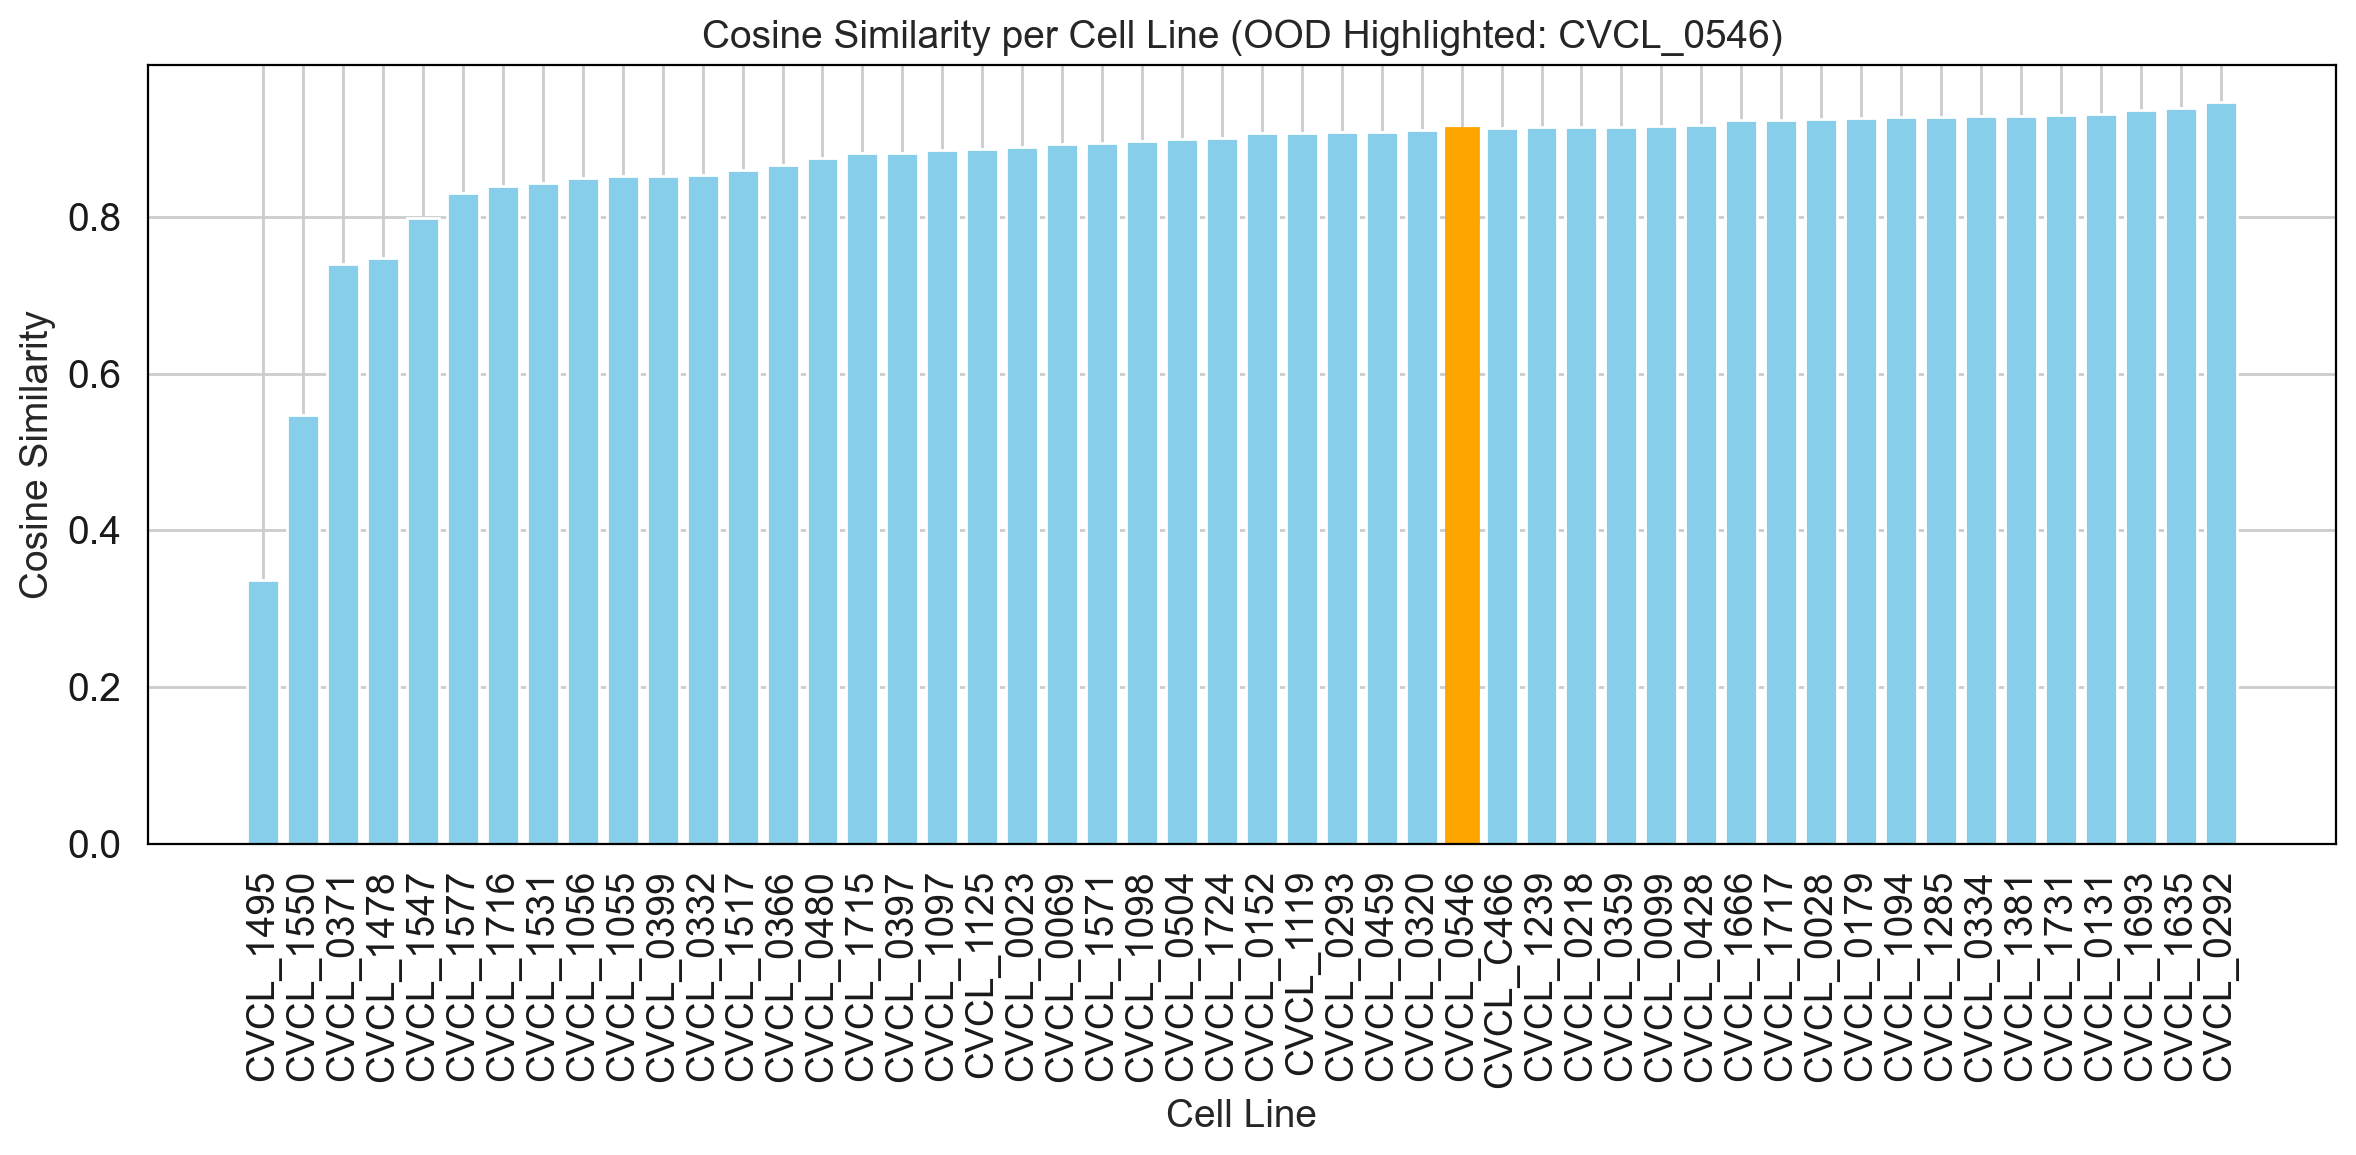

In [121]:
cosine_per_cell = df.groupby('cell_type')['cosine_sim'].mean()
cosine_per_cell = cosine_per_cell.sort_values()

plt.figure(figsize=(12, 6))
bars = plt.bar(cosine_per_cell.index, cosine_per_cell.values, color='skyblue')

# Highlight OOD in orange
for bar, cell in zip(bars, cosine_per_cell.index):
    if cell == ood_cell_line:
        bar.set_color('orange')

plt.title(f"Cosine Similarity per Cell Line (OOD Highlighted: {ood_cell_line})")
plt.ylabel("Cosine Similarity")
plt.xlabel("Cell Line")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### R² score 
(coefficient of determination) measures how much of the variance in the observed data is explained by the predictions.

R² > 0.5: Generally good alignment.

R²=Perfect prediction (predicted values match true values exactly).

In [131]:
mean_r2_mean_deg = df['r2_mean_deg'].mean()
print("Mean R² (mean expression) across all cell lines:", mean_r2_mean_deg)
r2_mean_per_cell = df.groupby('cell_type')['r2_mean_deg'].mean().sort_values()

plt.figure(figsize=(12, 6))
bars = plt.bar(r2_mean_per_cell.index, r2_mean_per_cell.values, color='skyblue')

# Highlight OOD cell line
ood_cell_line = 'CVCL_0546'
for bar, cell in zip(bars, r2_mean_per_cell.index):
    if cell == ood_cell_line:
        bar.set_color('orange')

plt.axhline(0, color='red', linestyle='--', label='R² = 0')
plt.title(f"R² (Mean DEG Expression) per Cell Line (OOD Highlighted: {ood_cell_line})")
plt.ylabel("R² (mean DEG expression)")
plt.xlabel("Cell Line")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


Mean R² (mean expression) across all cell lines: 0.47214875370264053


###  E-distance (energy distance)

Distance between two probability distributions (e.g., predicted vs observed gene expression distributions).

Smaller values close to 0 indicate good alighnment.

Mean E-Distance across all cell lines: 0.15055705744178627


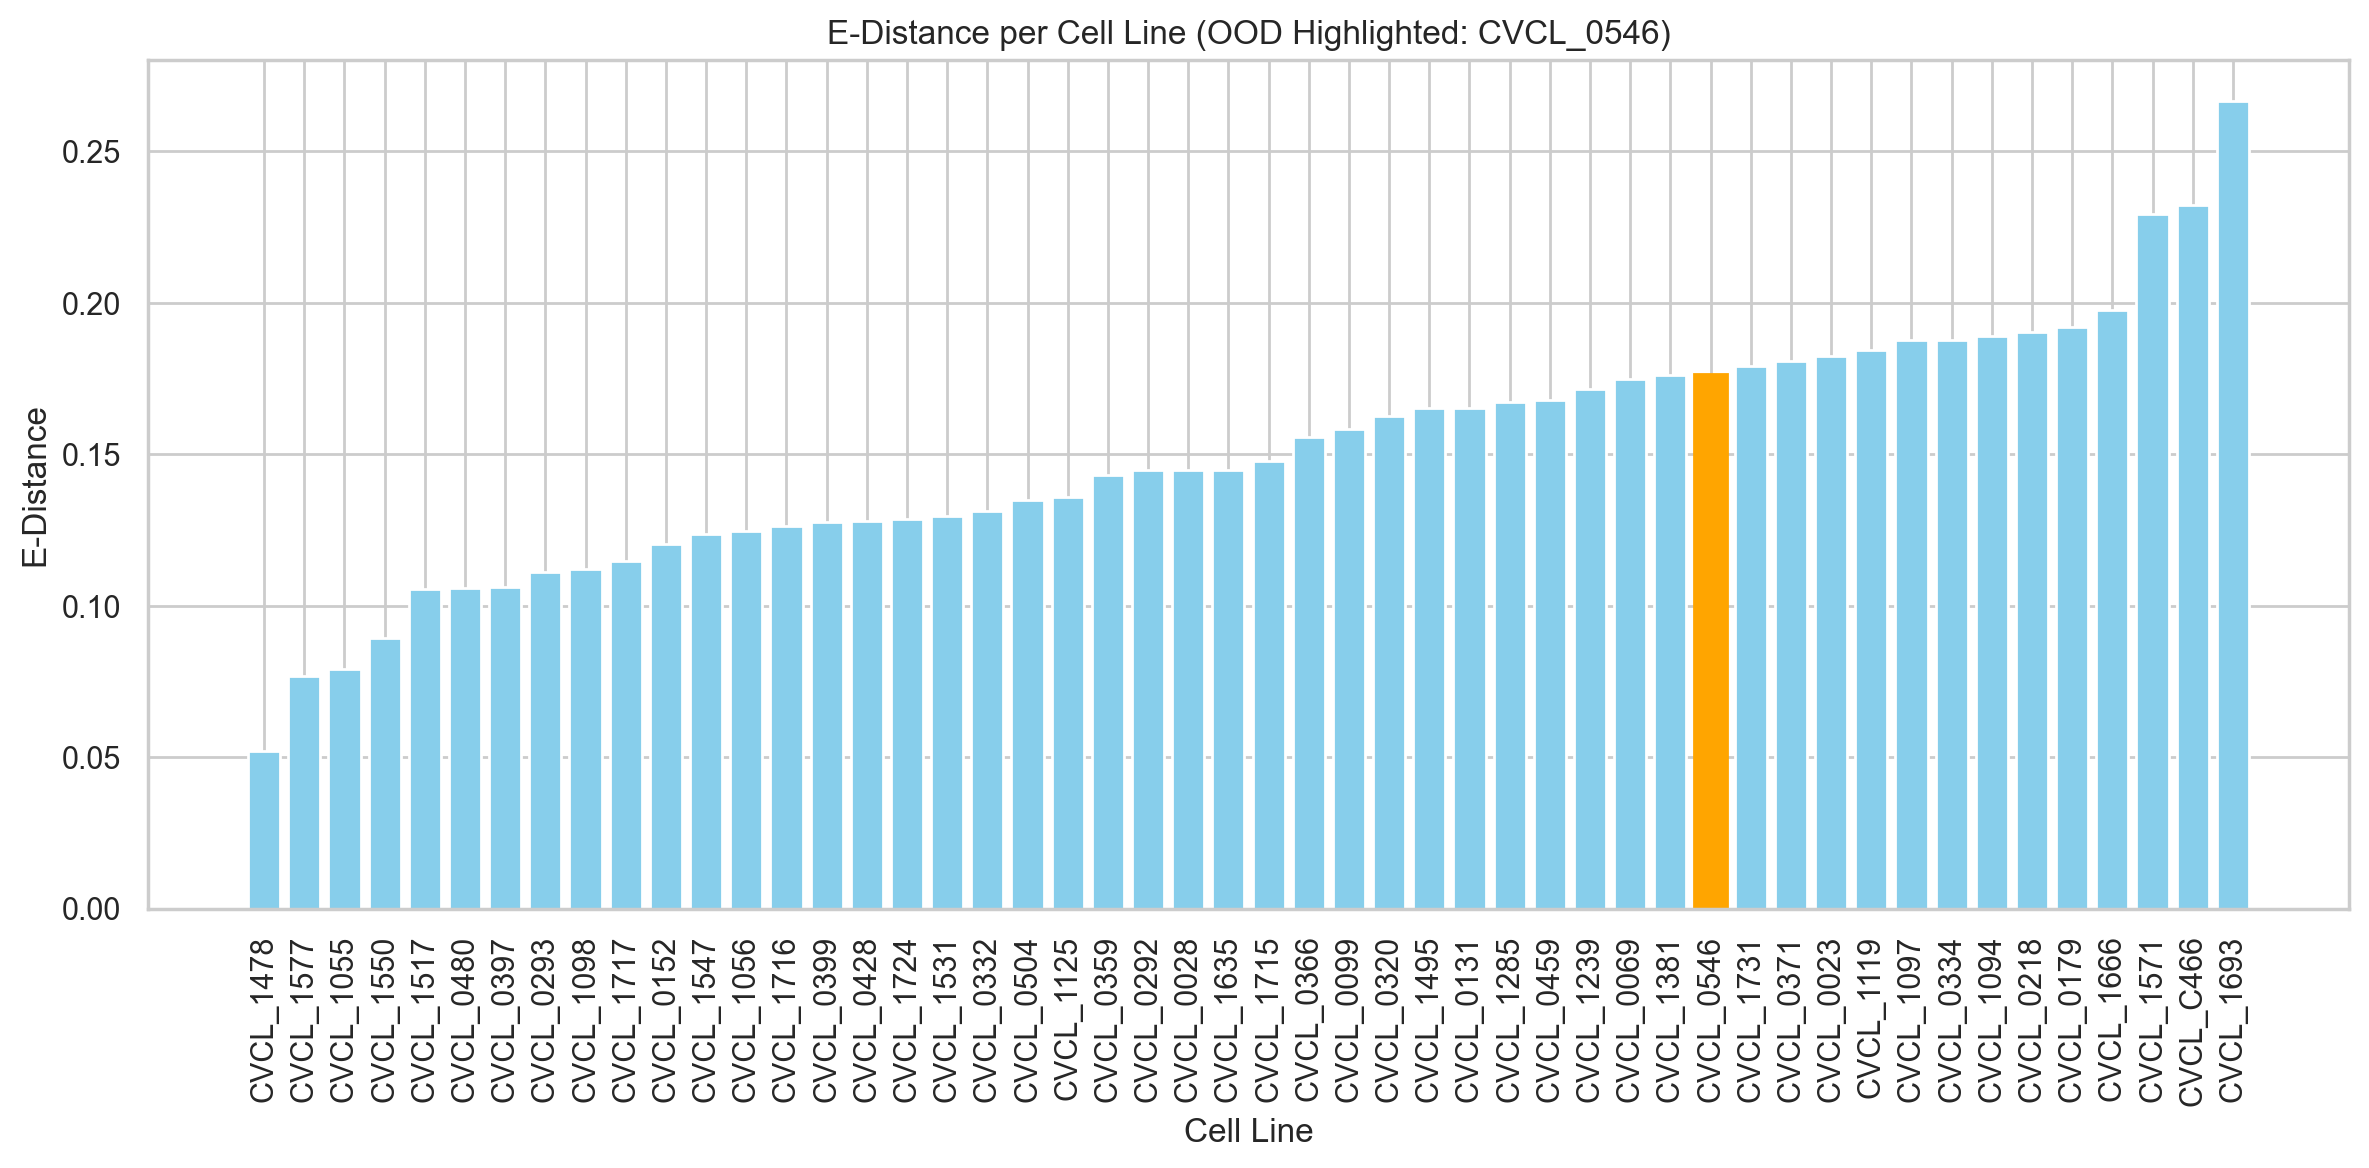

In [132]:
mean_e_dist = df['e_distance'].mean()
print("Mean E-Distance across all cell lines:", mean_e_dist)
e_dist_per_cell = df.groupby('cell_type')['e_distance'].mean()
e_dist_per_cell = e_dist_per_cell.sort_values()

plt.figure(figsize=(12, 6))
bars = plt.bar(e_dist_per_cell.index, e_dist_per_cell.values, color='skyblue')

# Highlight OOD cell line
for bar, cell in zip(bars, e_dist_per_cell.index):
    if cell == ood_cell_line:
        bar.set_color('orange')

plt.title(f"E-Distance per Cell Line (OOD Highlighted: {ood_cell_line})")
plt.ylabel("E-Distance")
plt.xlabel("Cell Line")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Visialization of results

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named `df`

# Convert to long format
df_melted = df.melt(
    id_vars=["condition", "cell_type", "n_top_deg"],
    value_vars=[
        "r2_mean_deg", "r2_var_deg",
        "r2_mean_lfc_deg", "r2_var_lfc_deg"
    ],
    var_name="metric",
    value_name="R2_score"
)

# Plot
sns.set(style="whitegrid", context="notebook")
g = sns.catplot(
    data=df_melted,
    x="n_top_deg", y="R2_score",
    hue="cell_type",
    col="metric",
    kind="bar",
    col_wrap=2,
    height=4, aspect=1.5,
    palette="Set2",
    sharey=False
)

g.set_titles("{col_name}")
g.set_axis_labels("Top DEGs", "R² Score")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("CPA R² Scores Across Metrics and Cell Types")
plt.show()


## Plotting: Compare OOD vs ID performance

In [ ]:
# Assume df already exists and contains R² results
# Define OOD cell line
ood_cell_line = "CVCL_0546"

# Mark whether each row is OOD or not
df['is_ood'] = df['cell_type'] == ood_cell_line

# Define metrics to visualize
metrics = ['r2_mean_deg', 'r2_var_deg', 'r2_mean_lfc_deg', 'r2_var_lfc_deg']
ncols = 2
nrows = (len(metrics) + 1) // ncols

# Create subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
axs = axs.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axs[i]
    summary = df.groupby(['is_ood', 'cell_type'])[metric].mean().reset_index()
    summary['OOD status'] = summary['is_ood'].map({True: 'OOD', False: 'ID'})
    
    for ood_status, group in summary.groupby('OOD status'):
        ax.bar(group['cell_type'], group[metric], label=ood_status, alpha=0.7)

    ax.set_title(f"{metric} by Cell Line")
    ax.set_ylabel("R² Score")
    ax.set_xticklabels(group['cell_type'], rotation=45, ha='right')
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


### CPA Prediction vs True for Stimulated per Cell Line
Diagonal alignment → Good agreement between CPA predictions and true data.

Points above the line → CPA overestimates gene expression.

Points below the line → CPA underestimates gene expression.

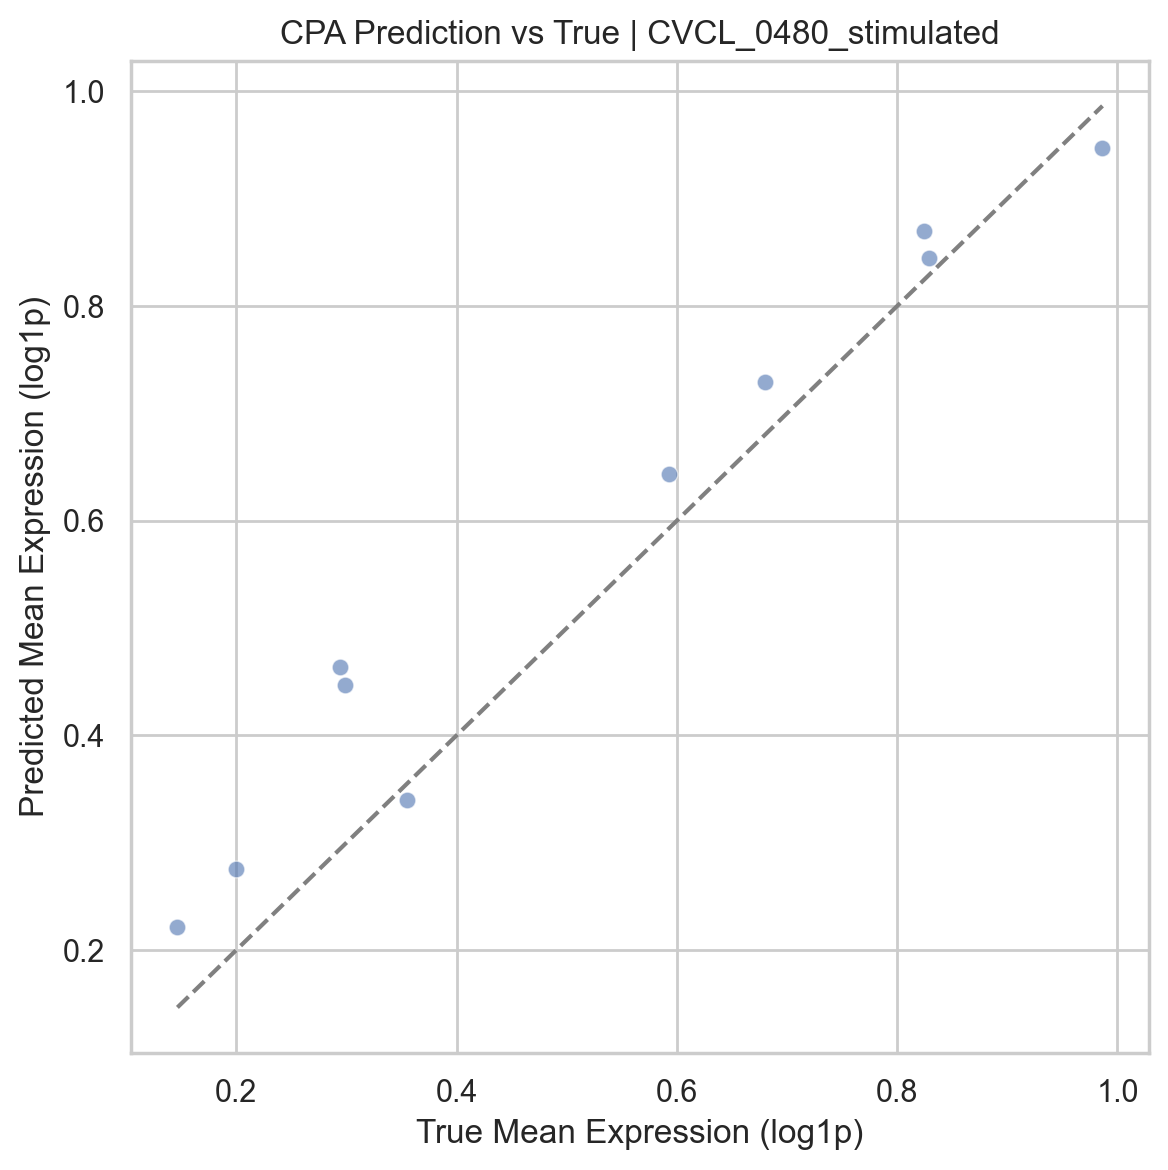

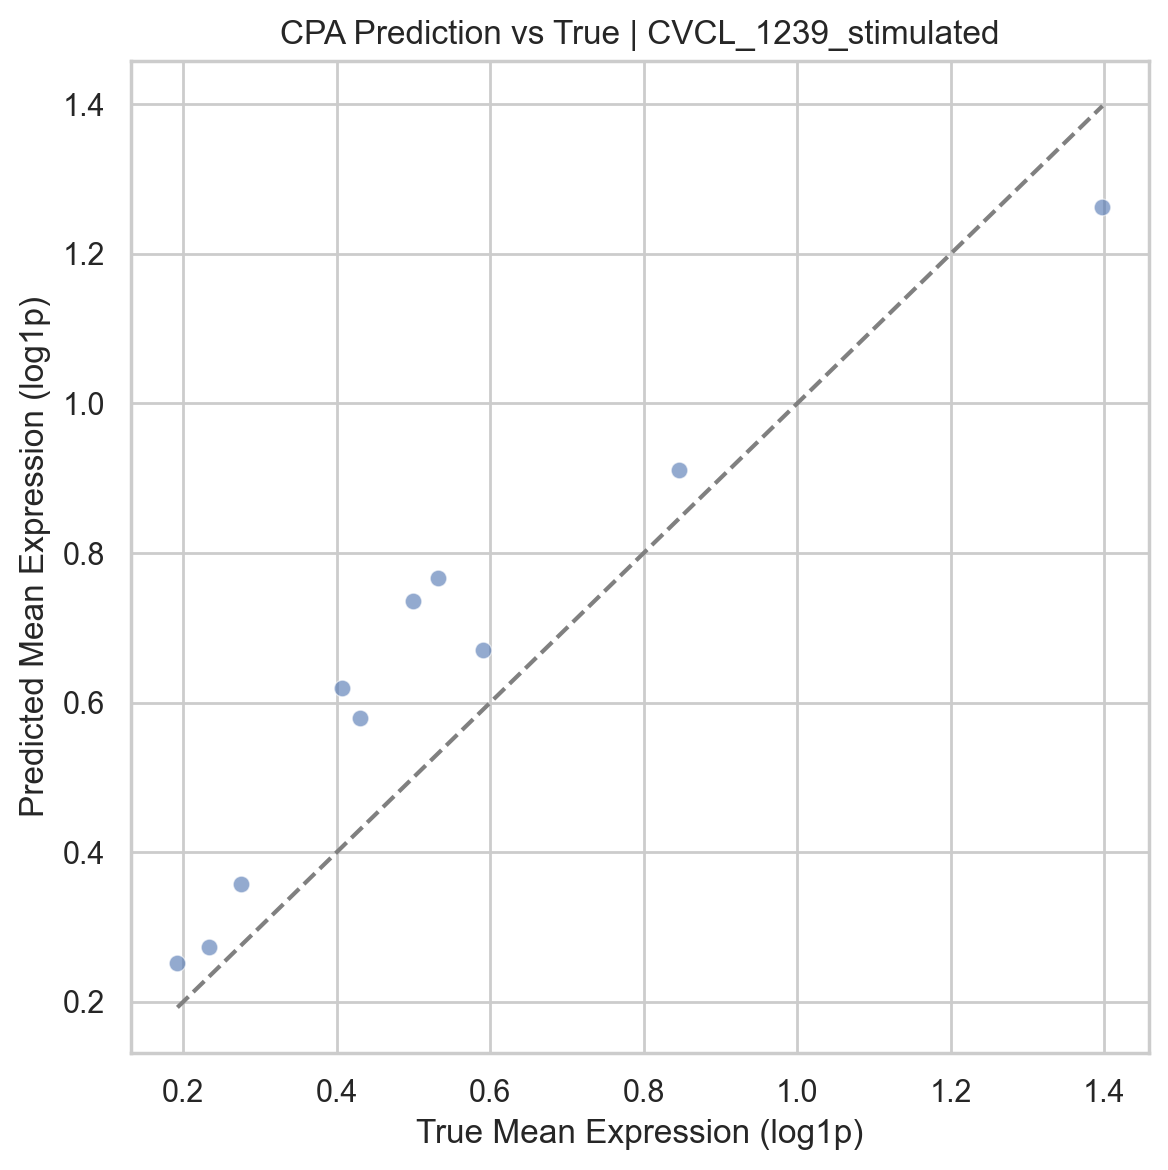

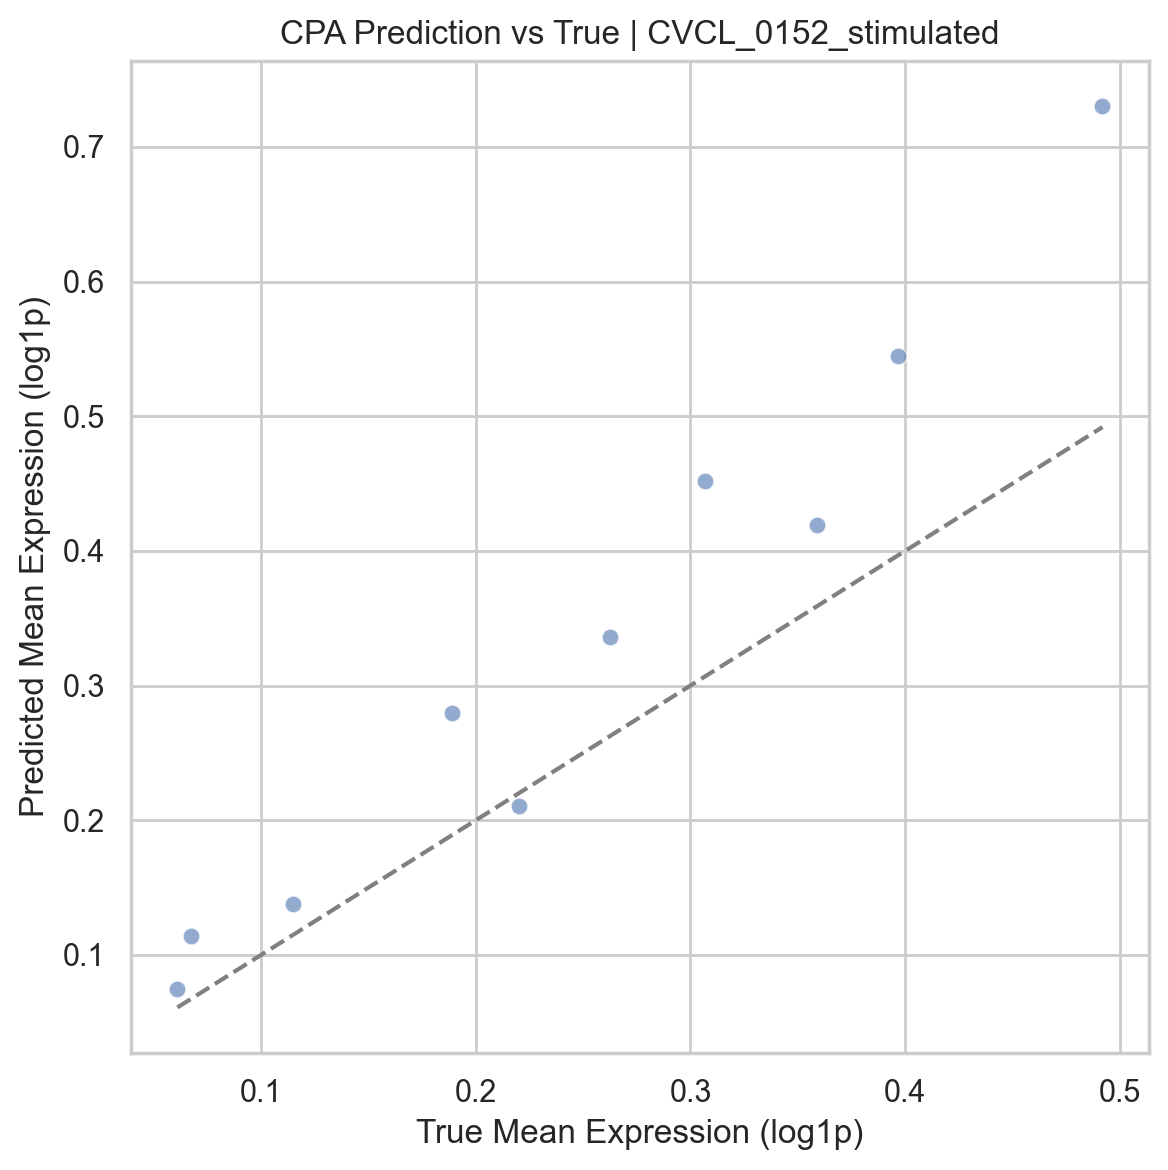

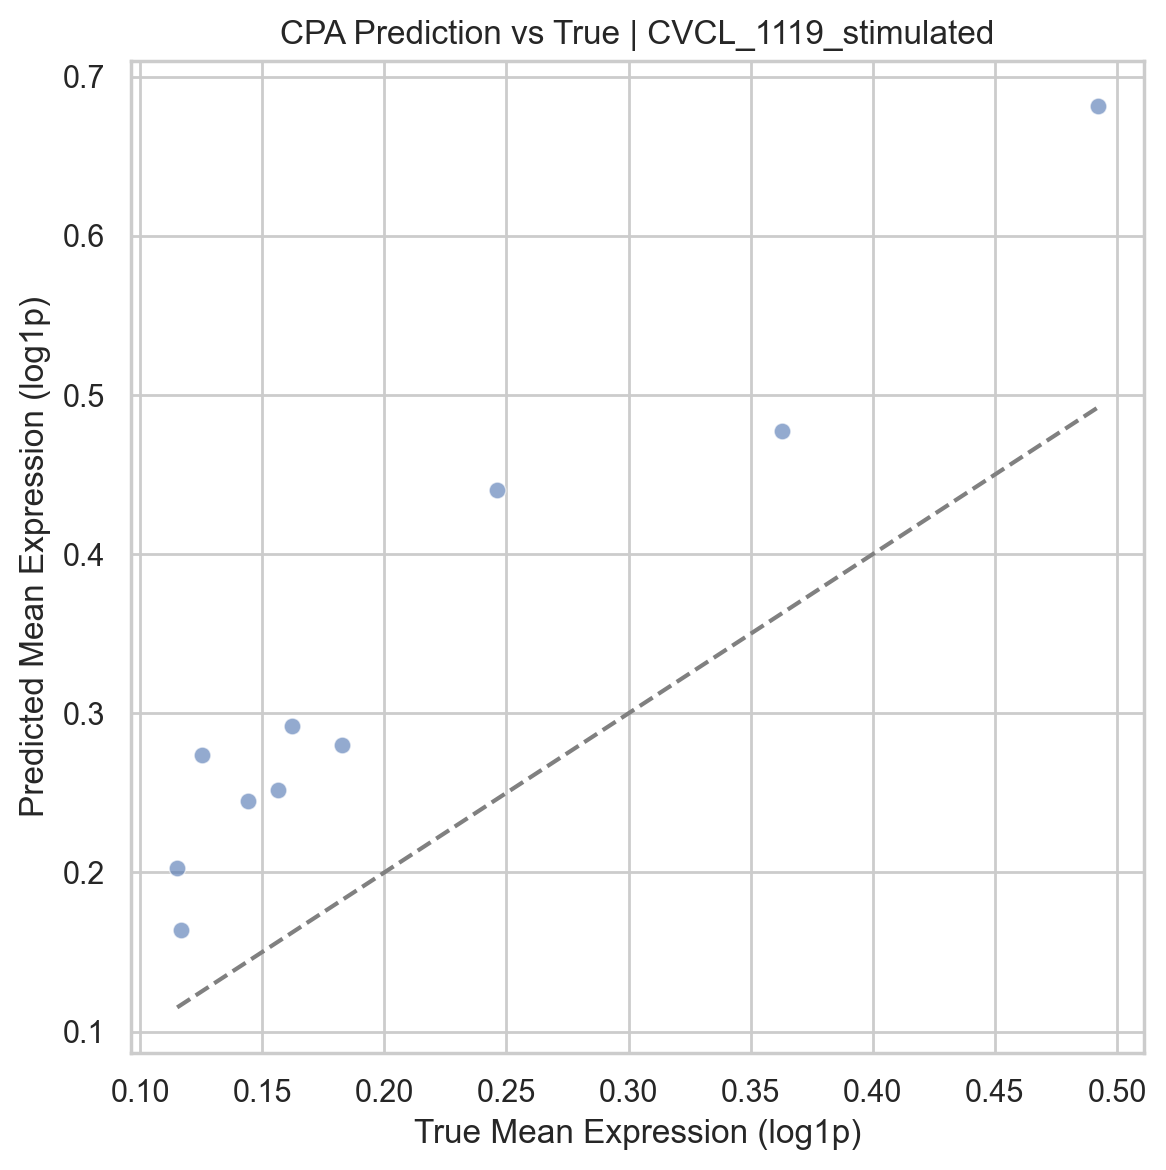

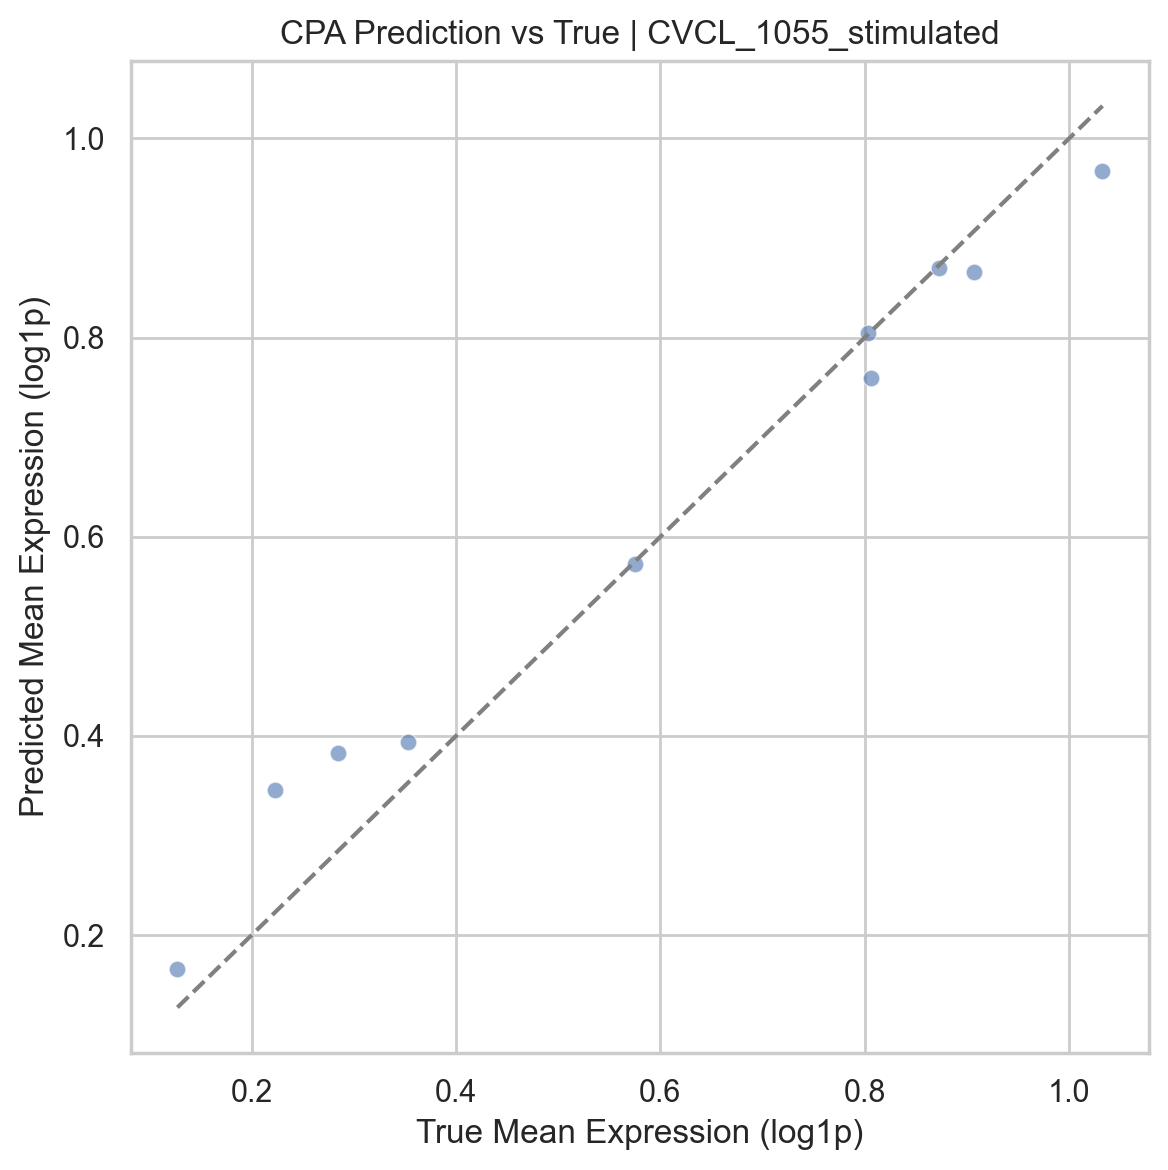

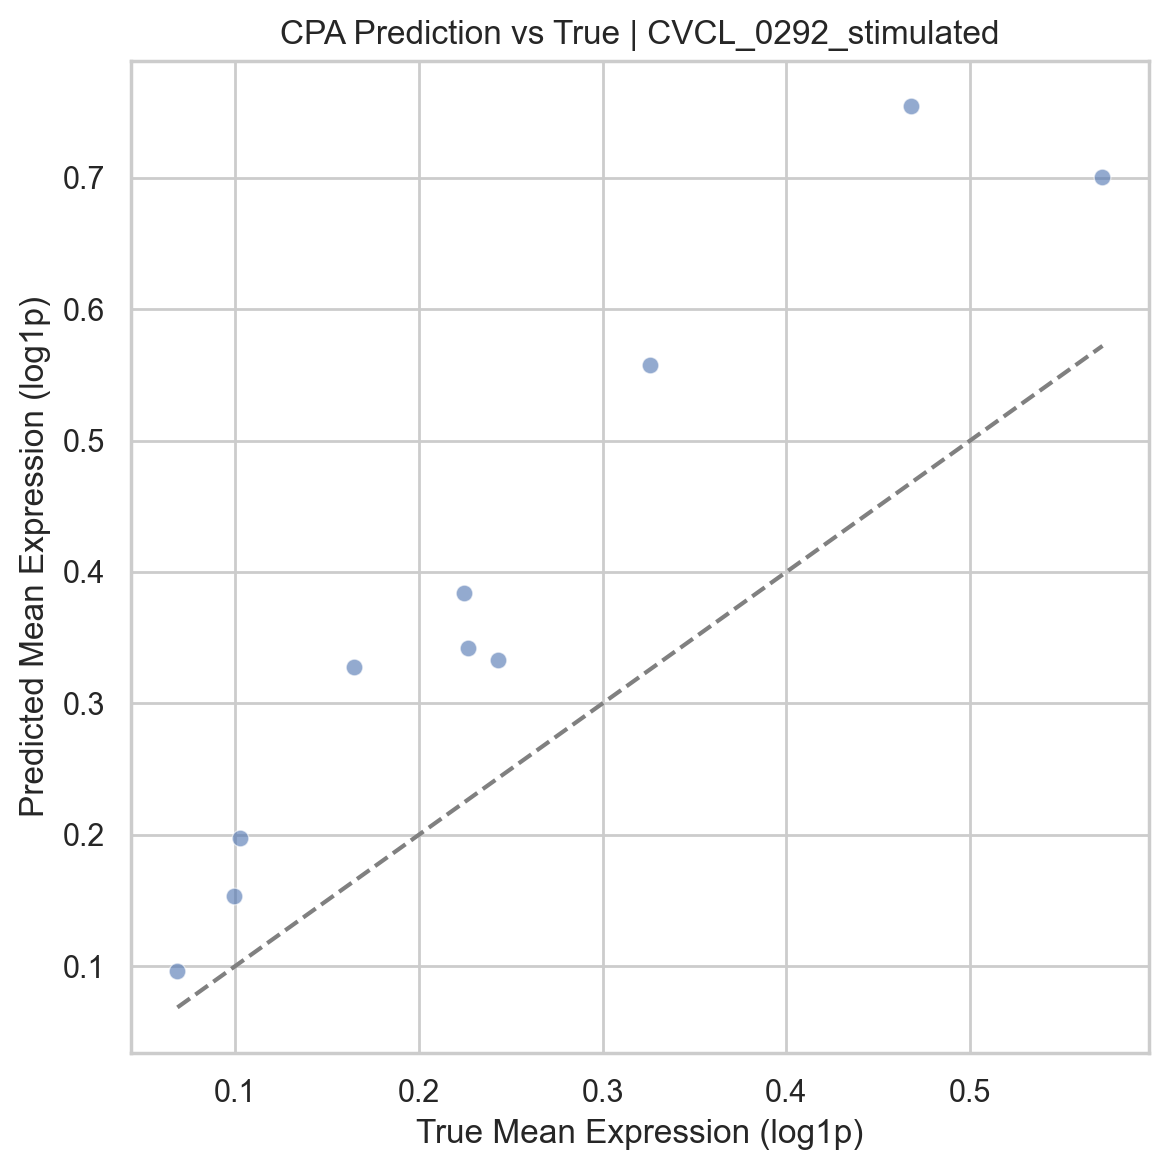

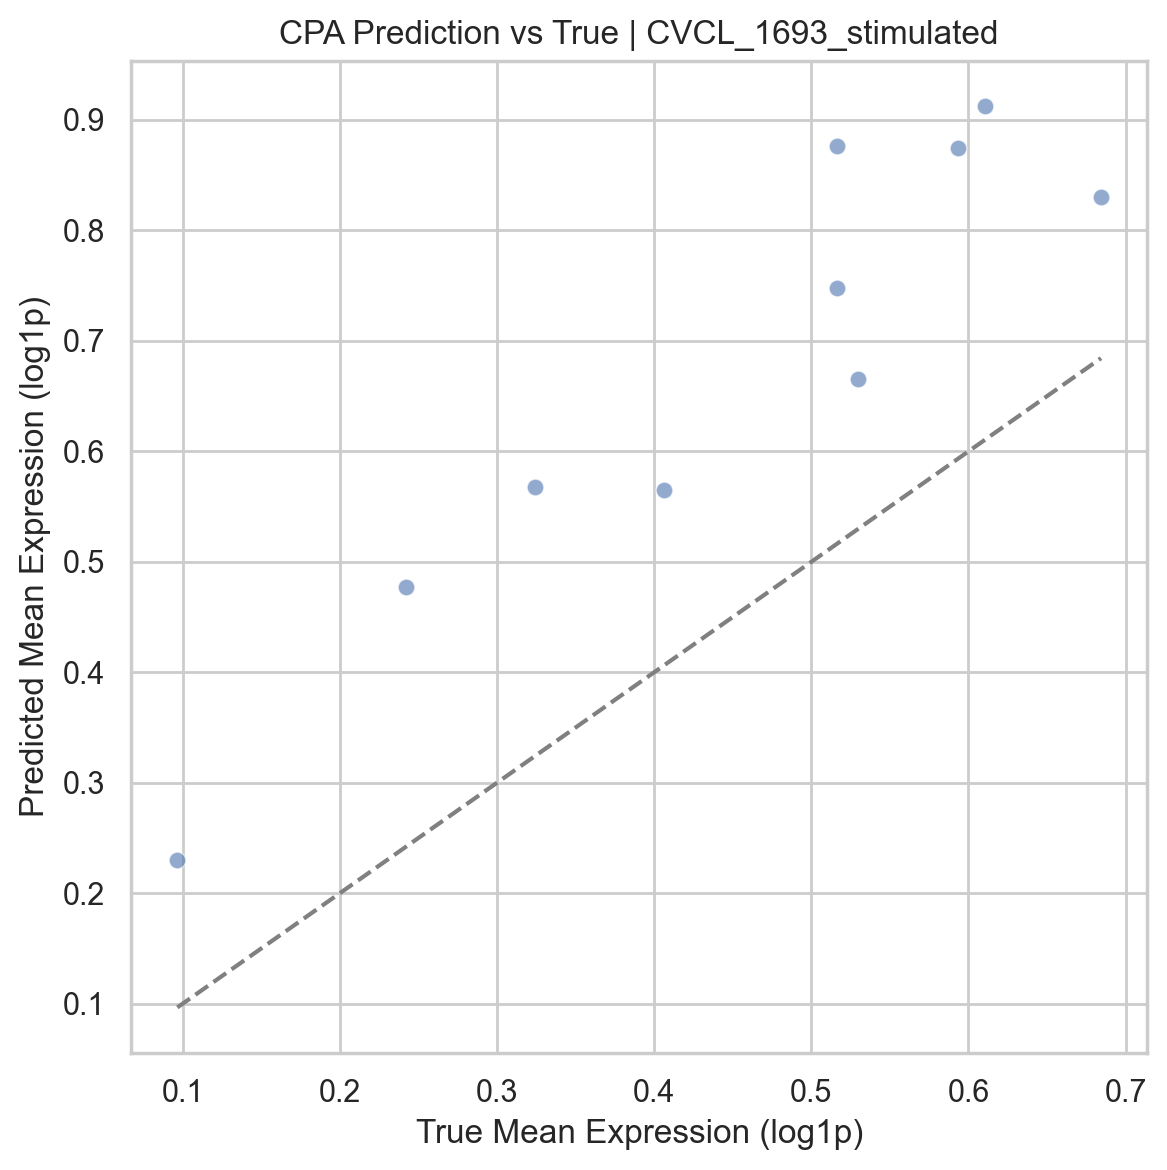

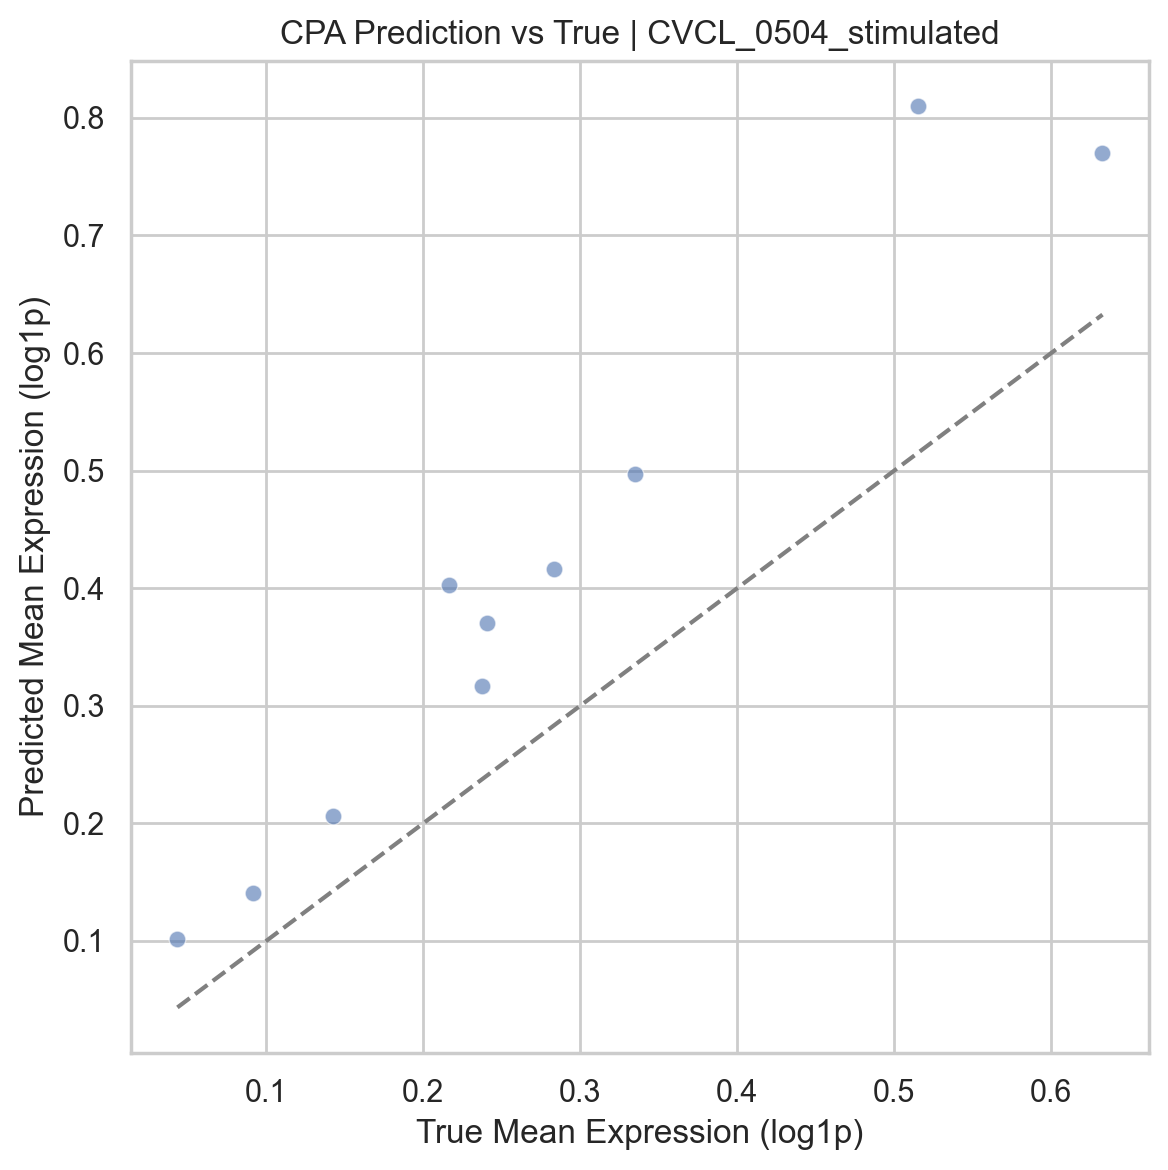

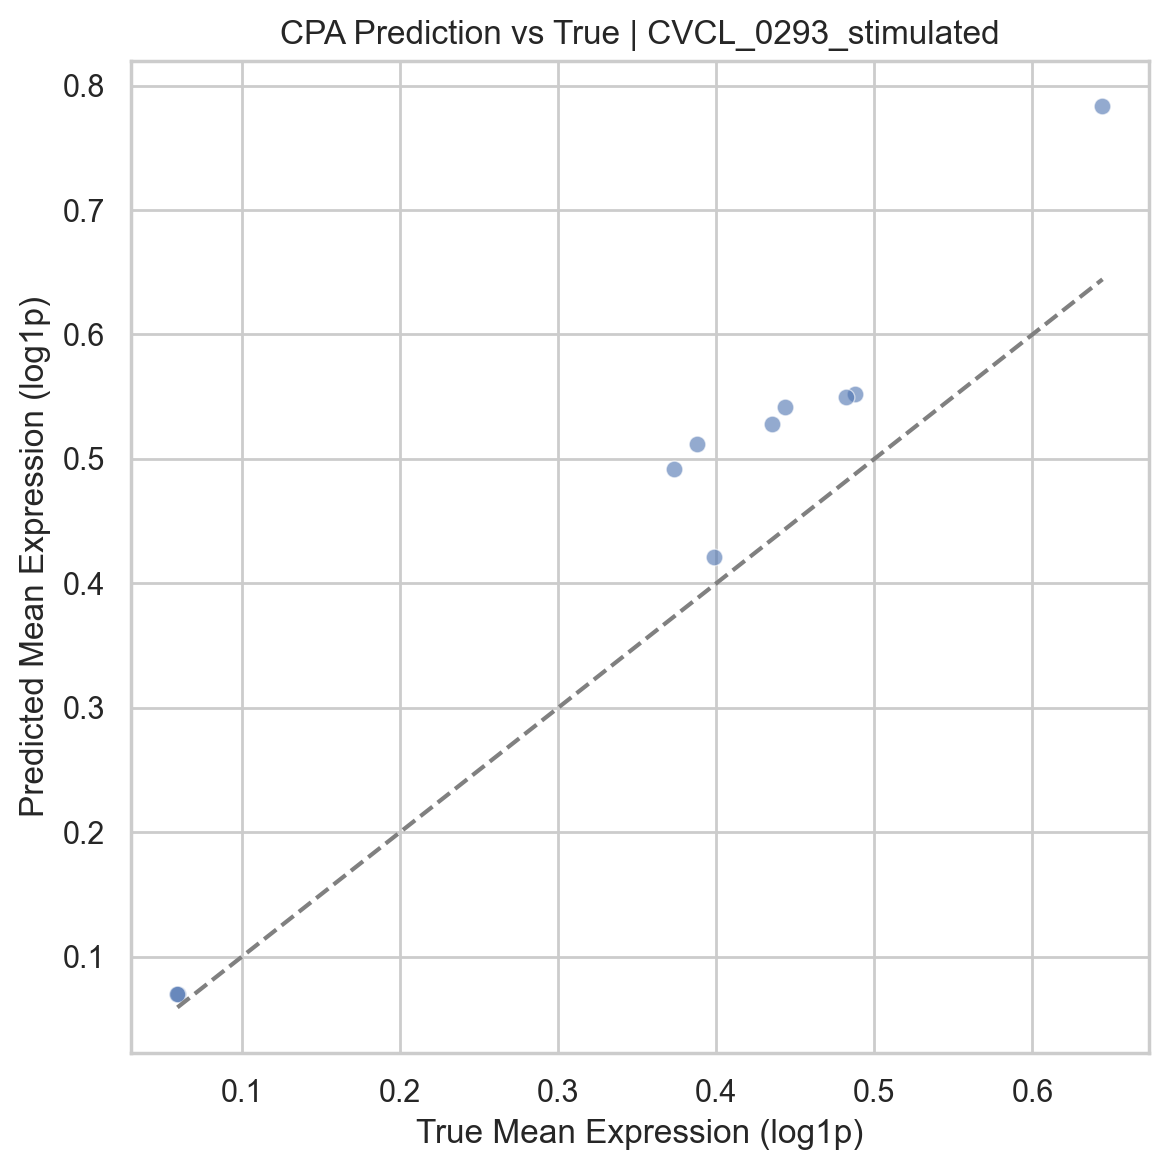

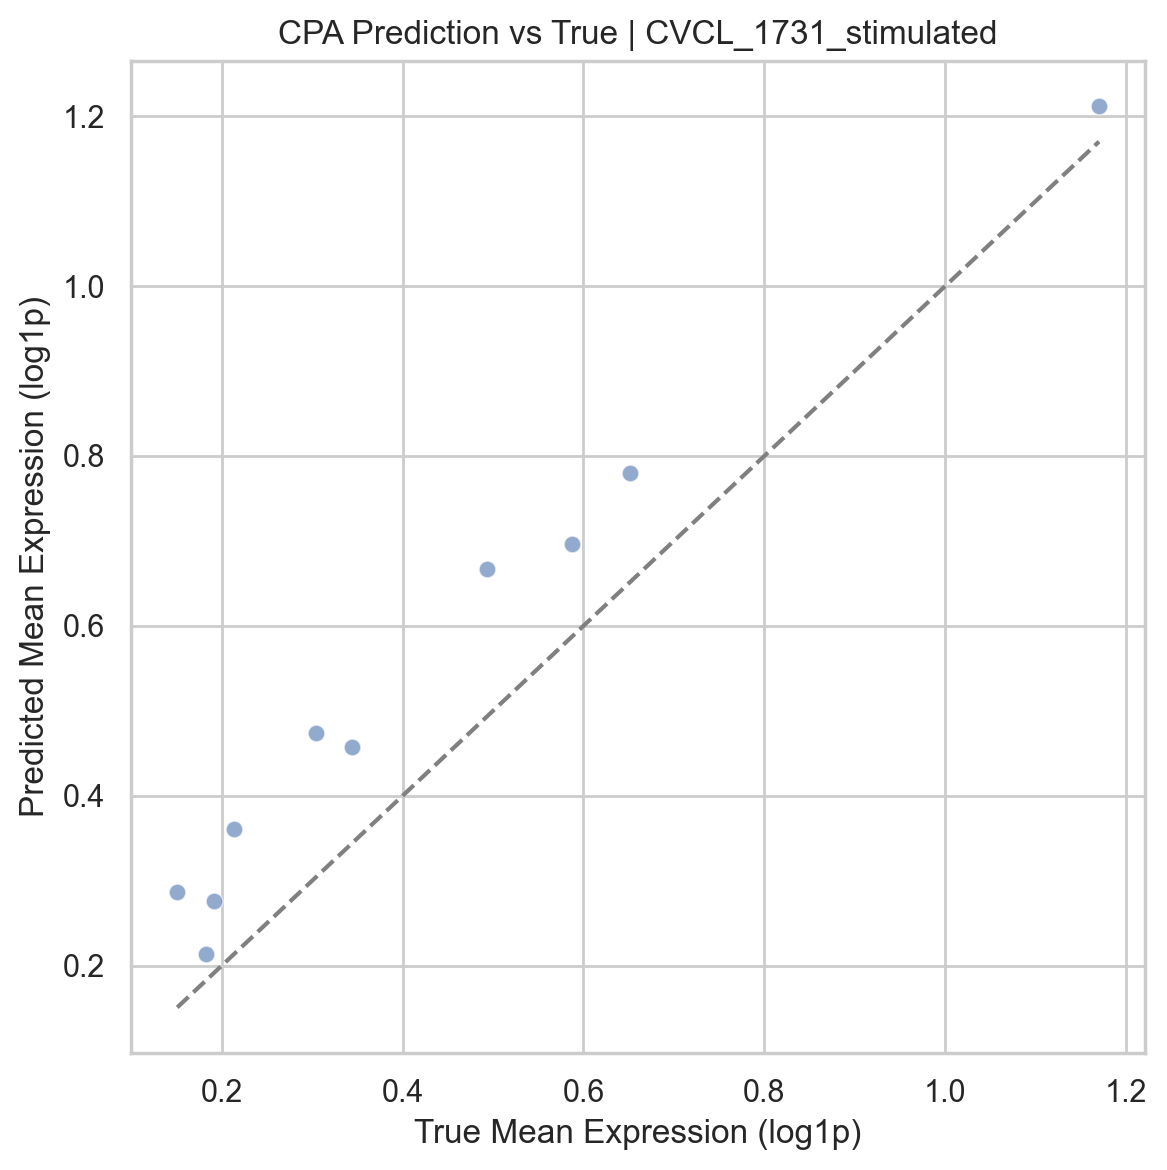

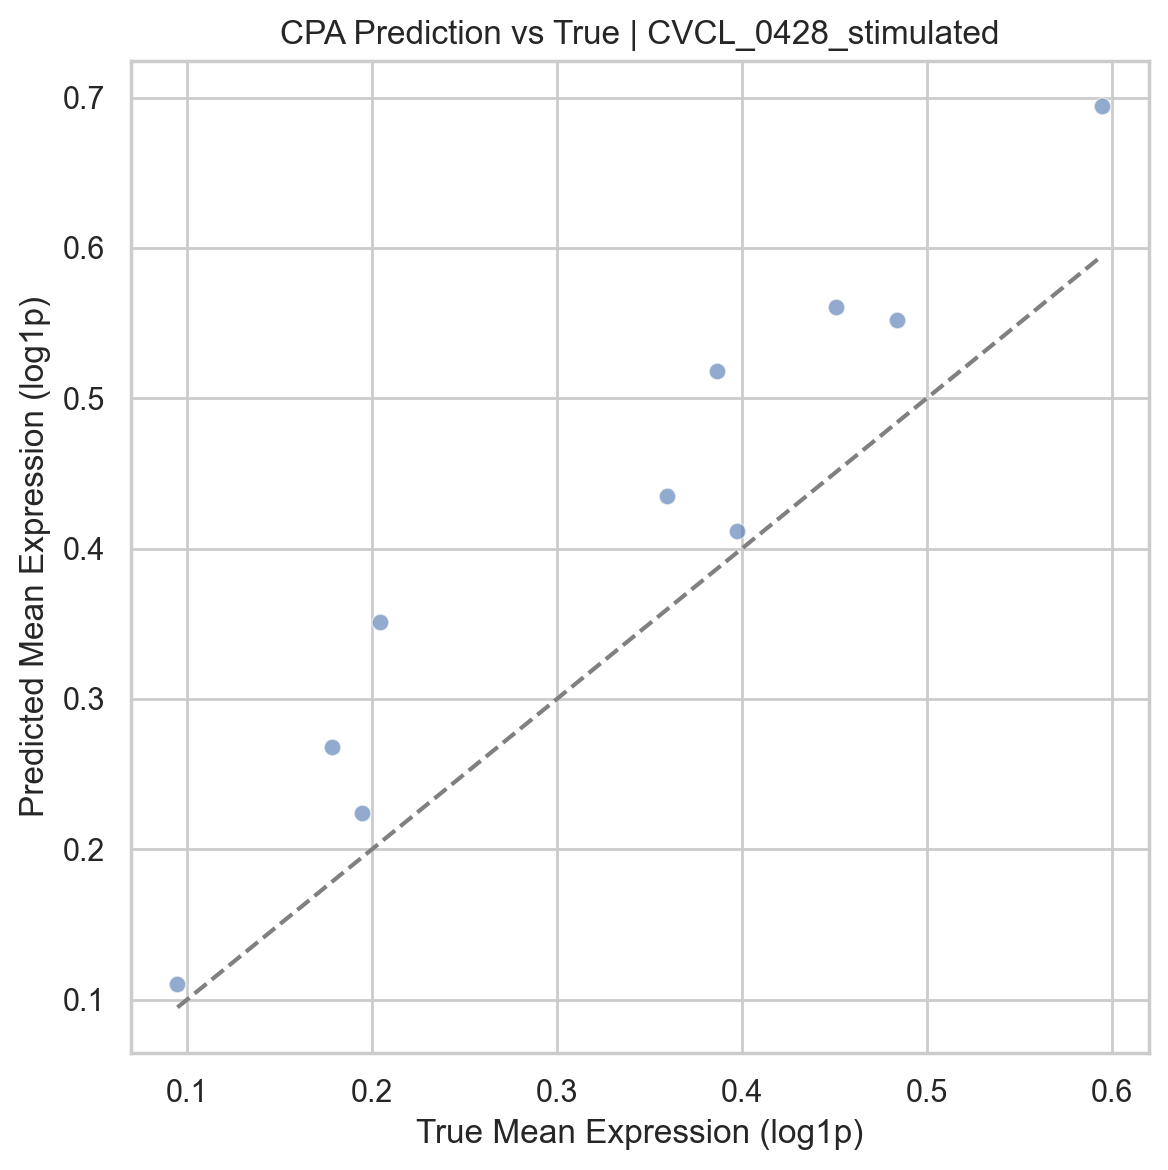

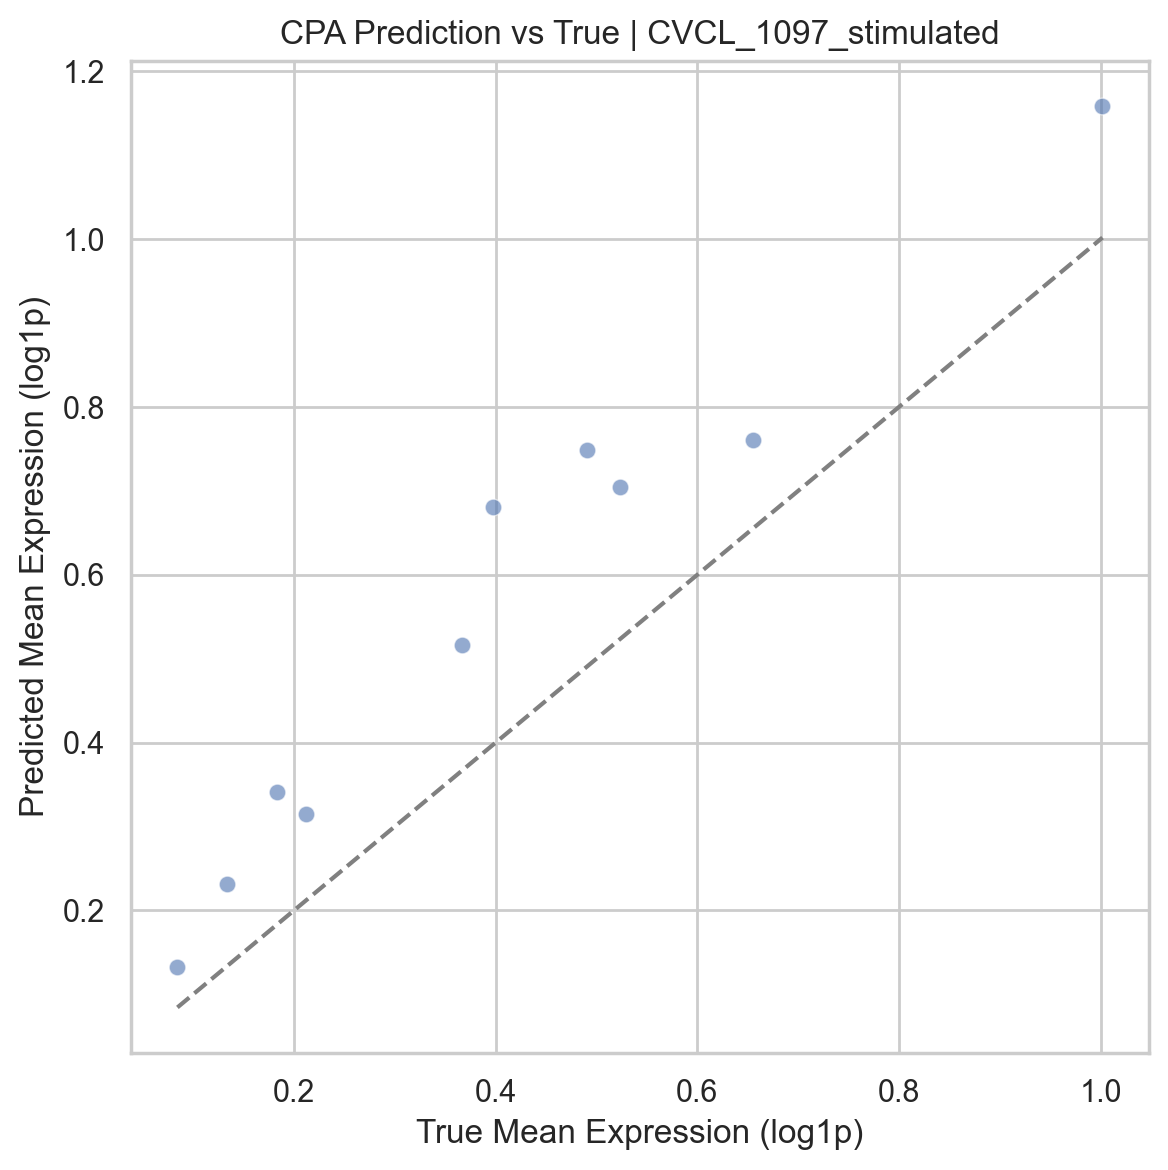

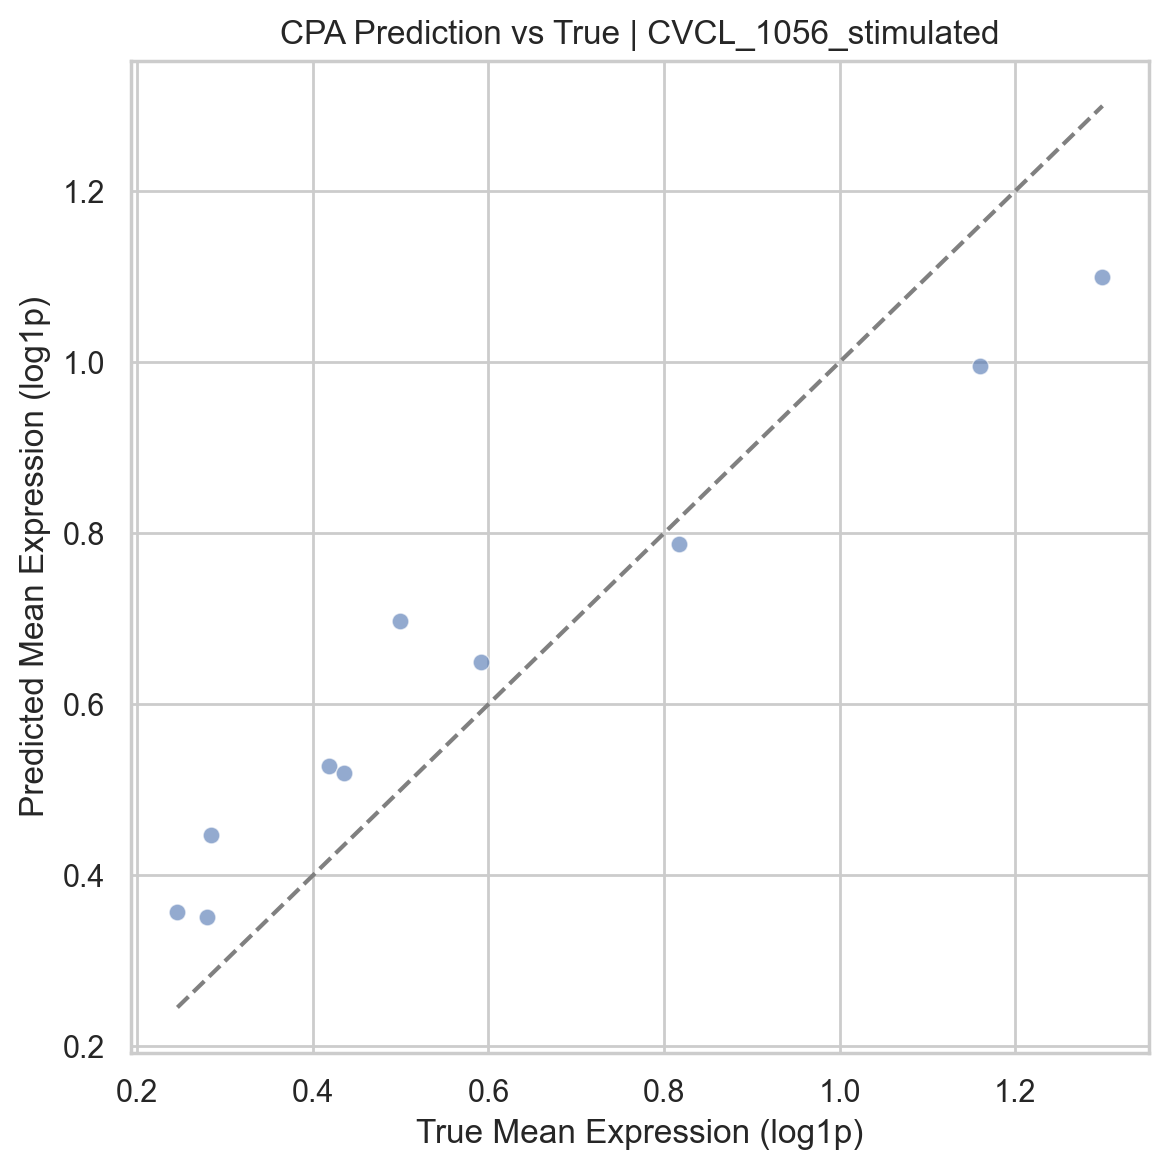

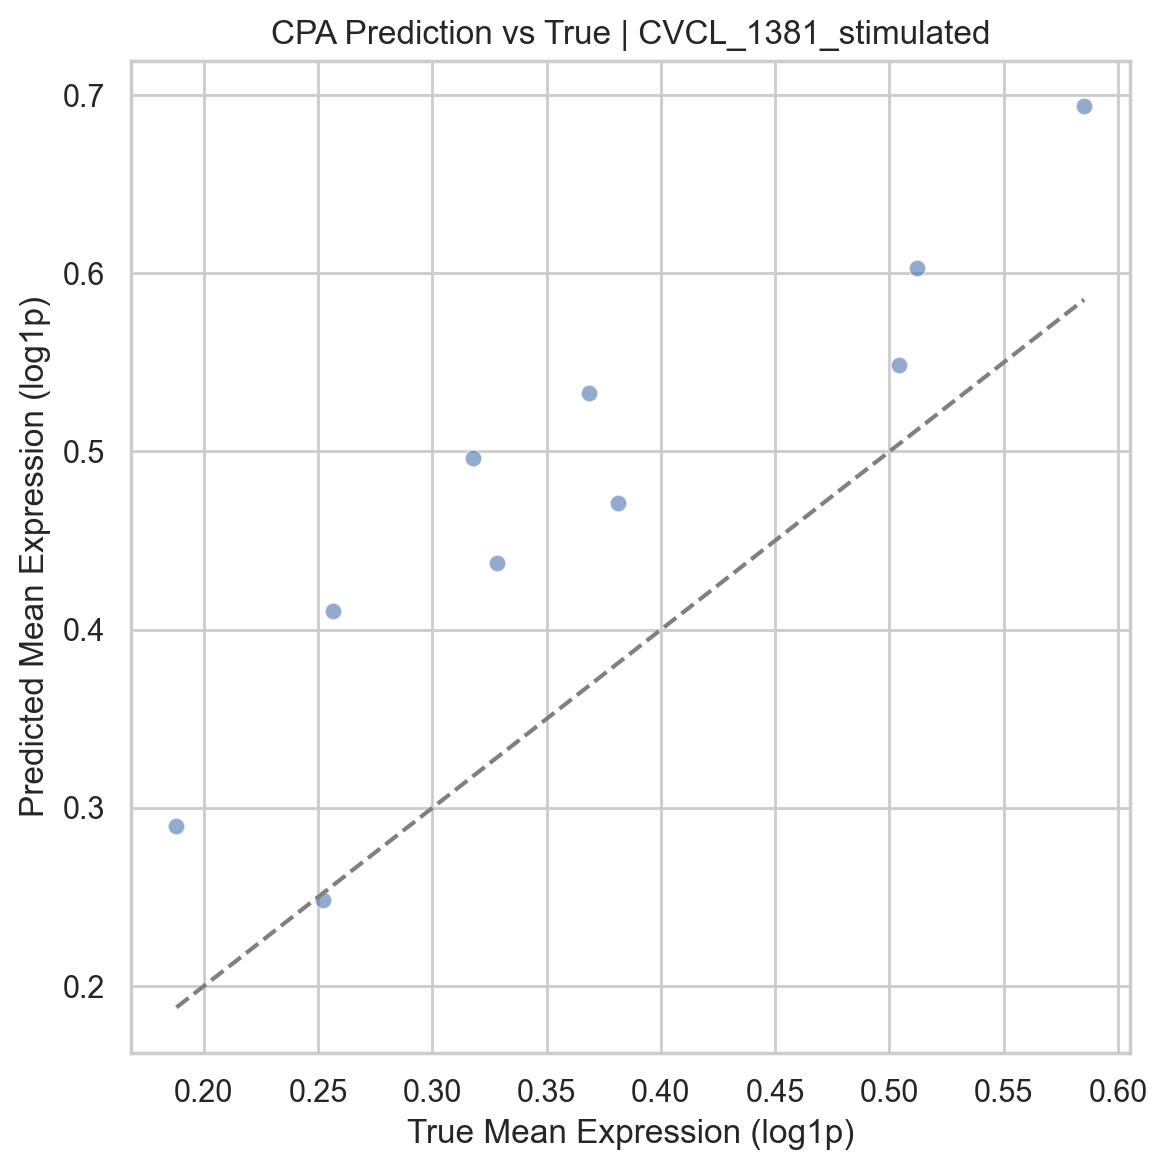

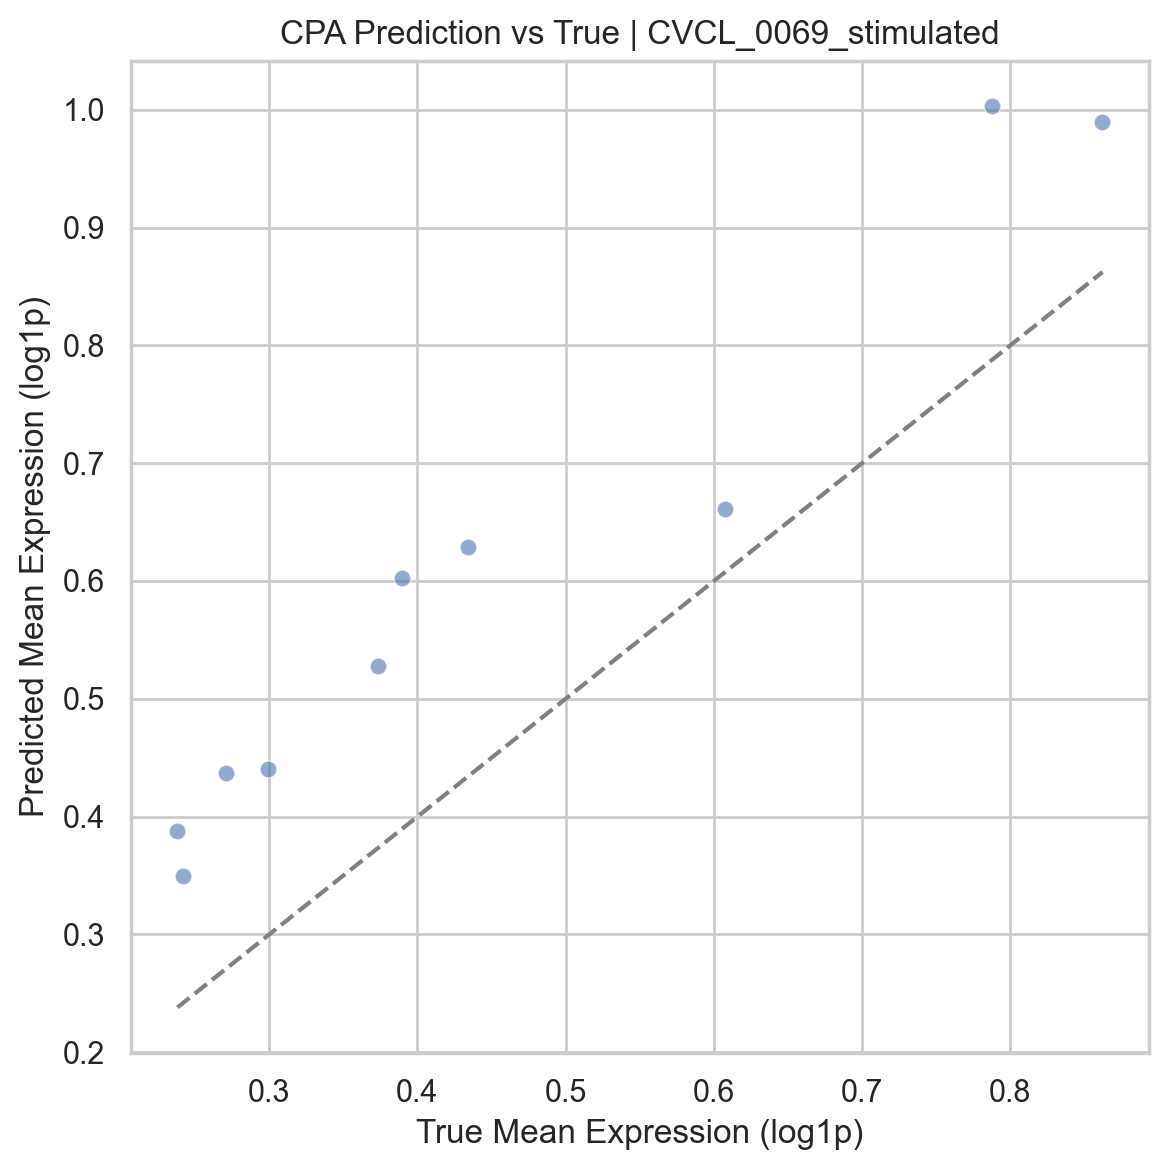

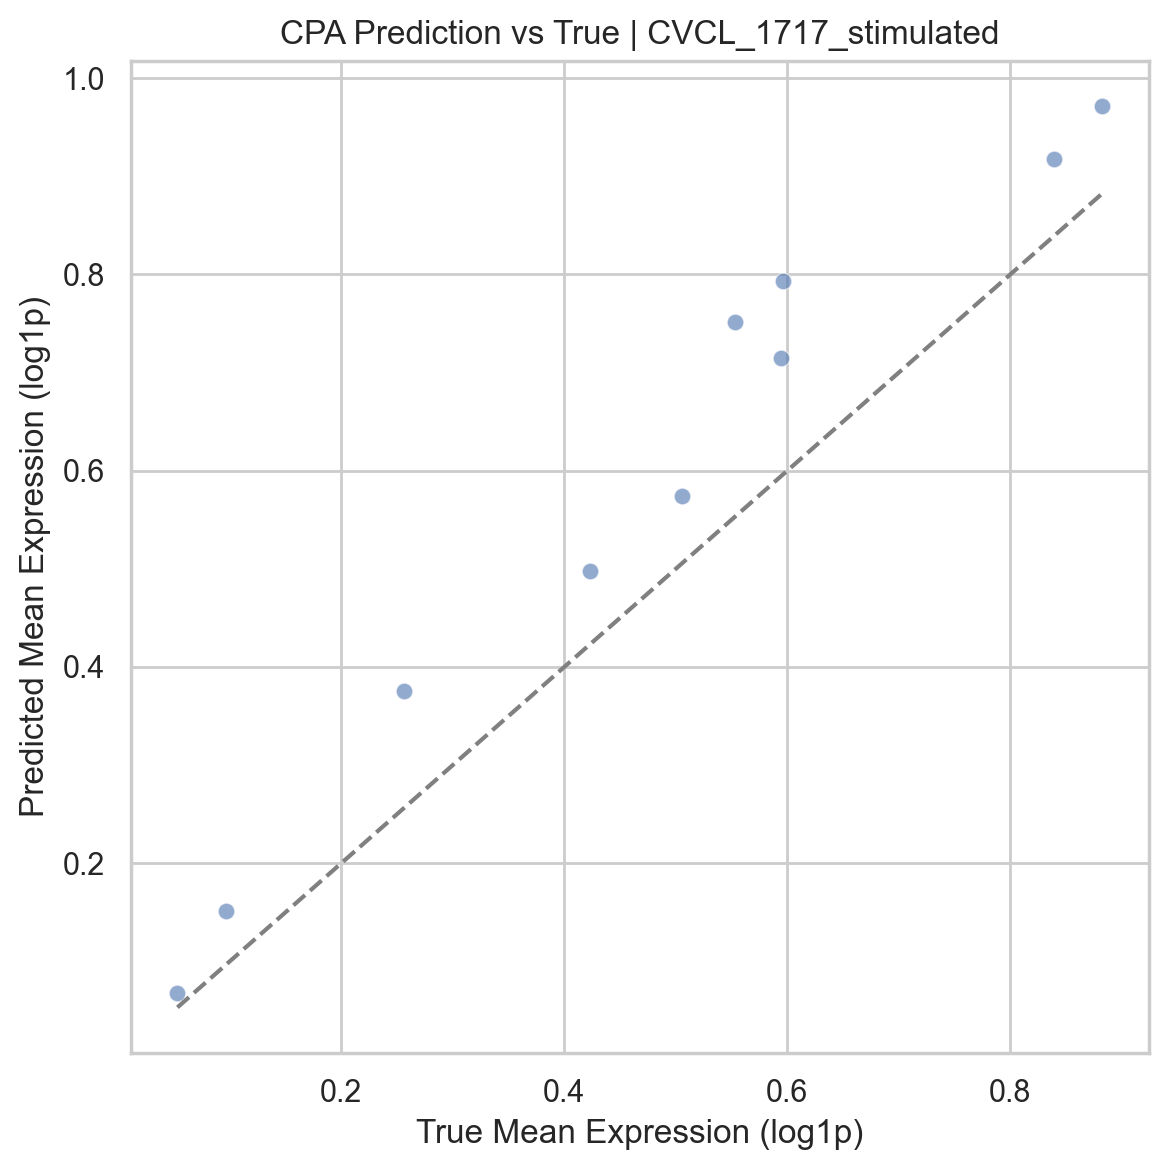

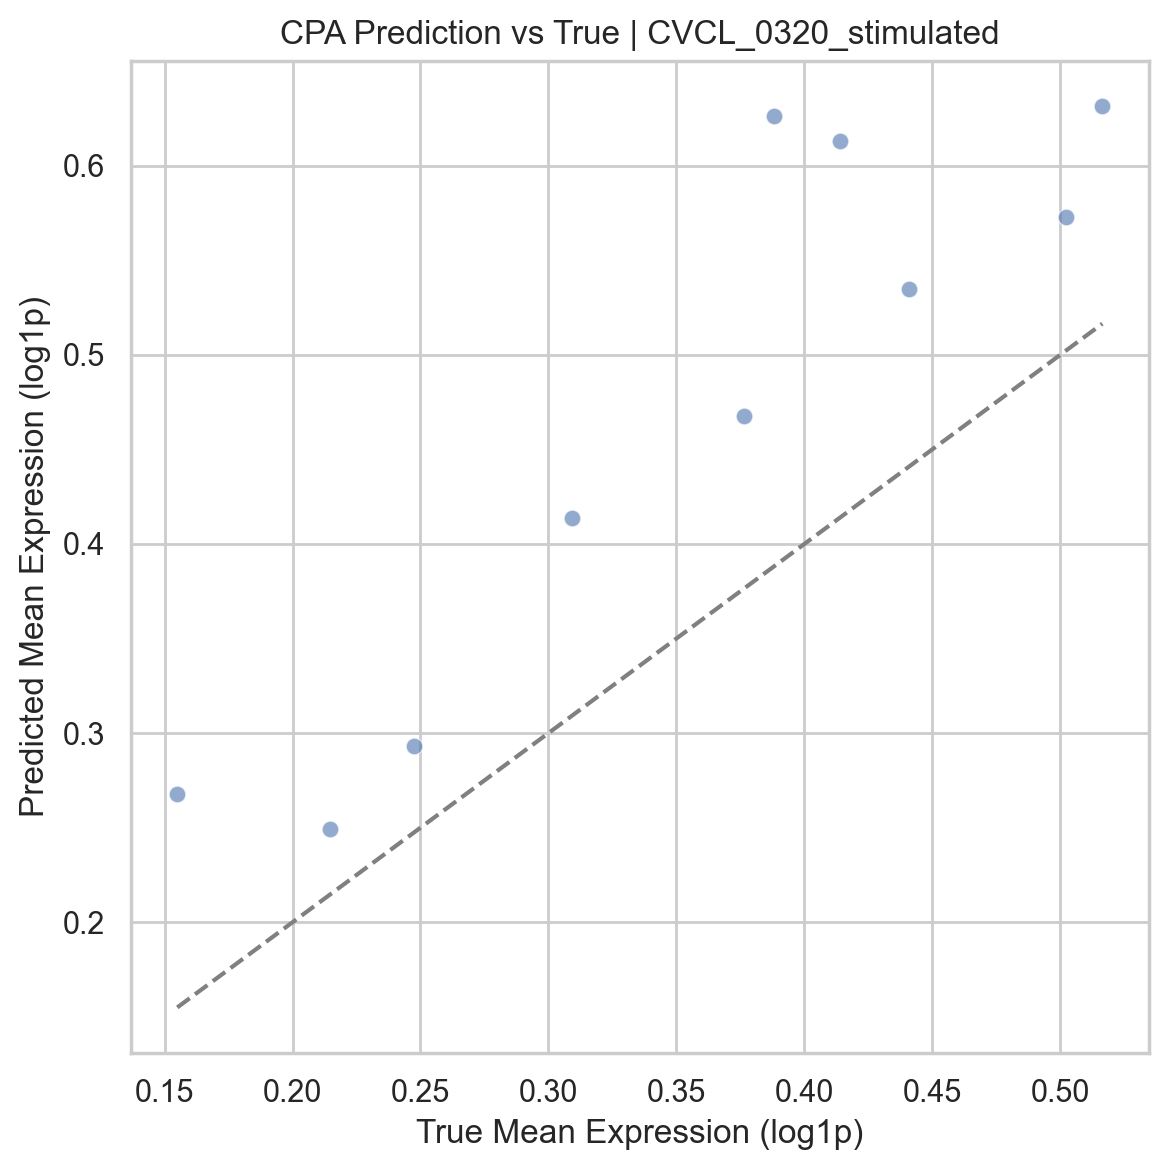

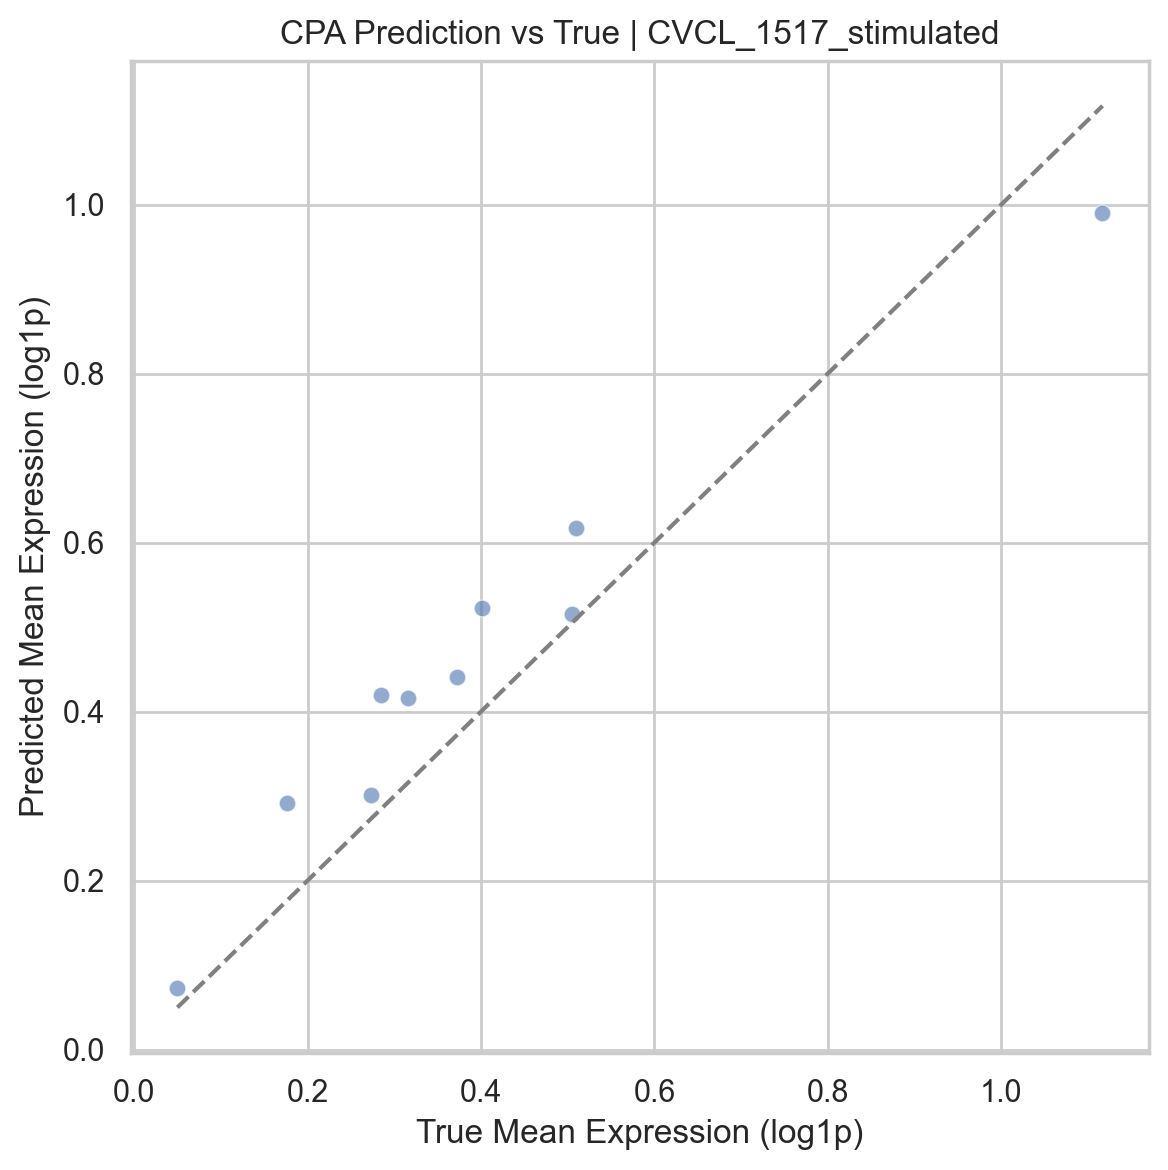

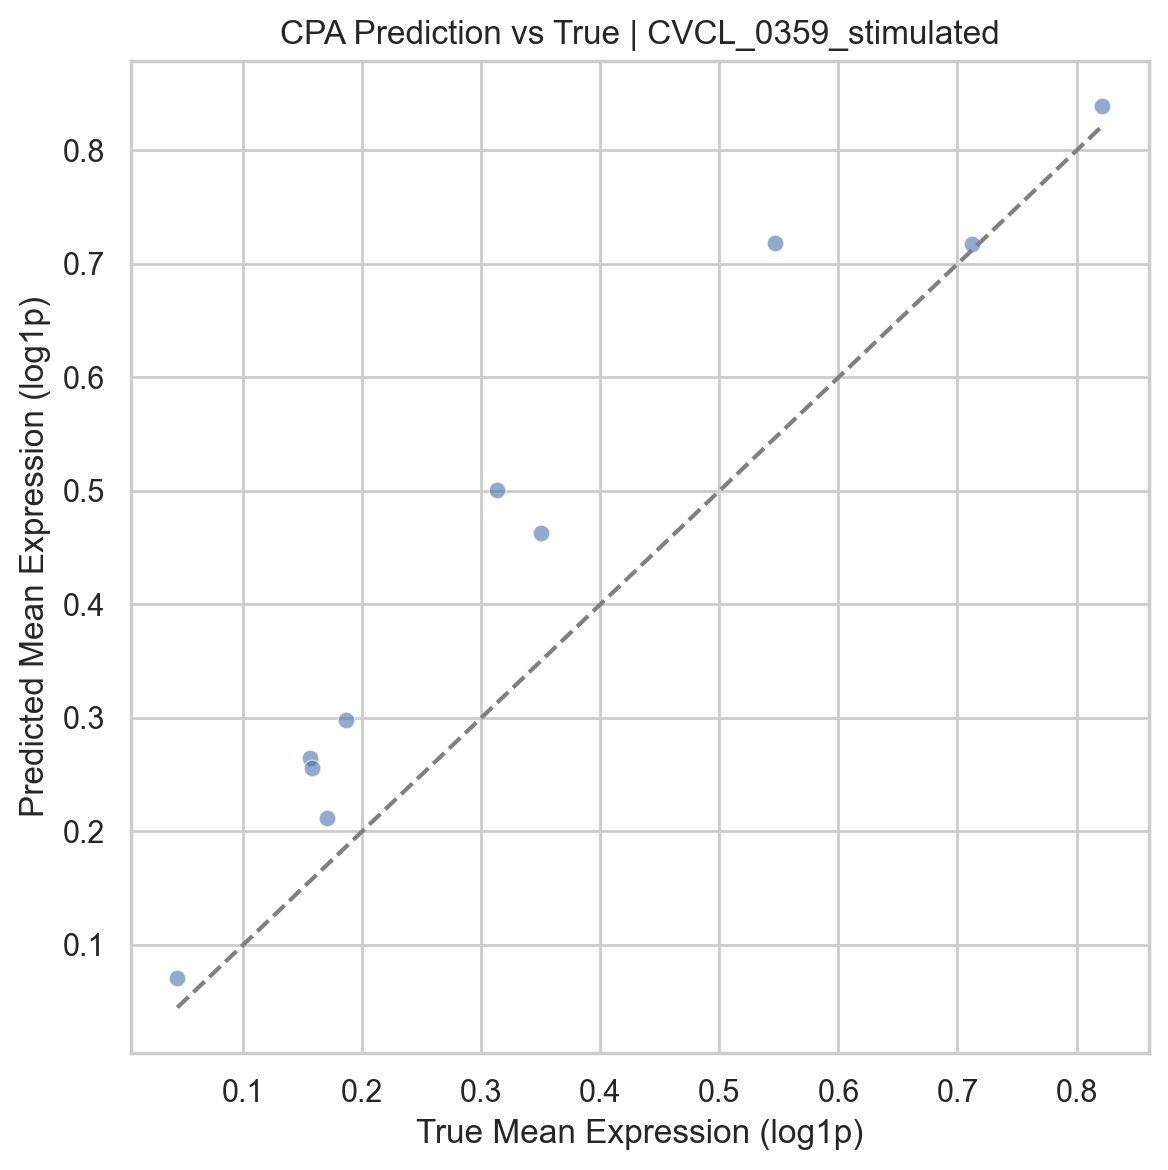

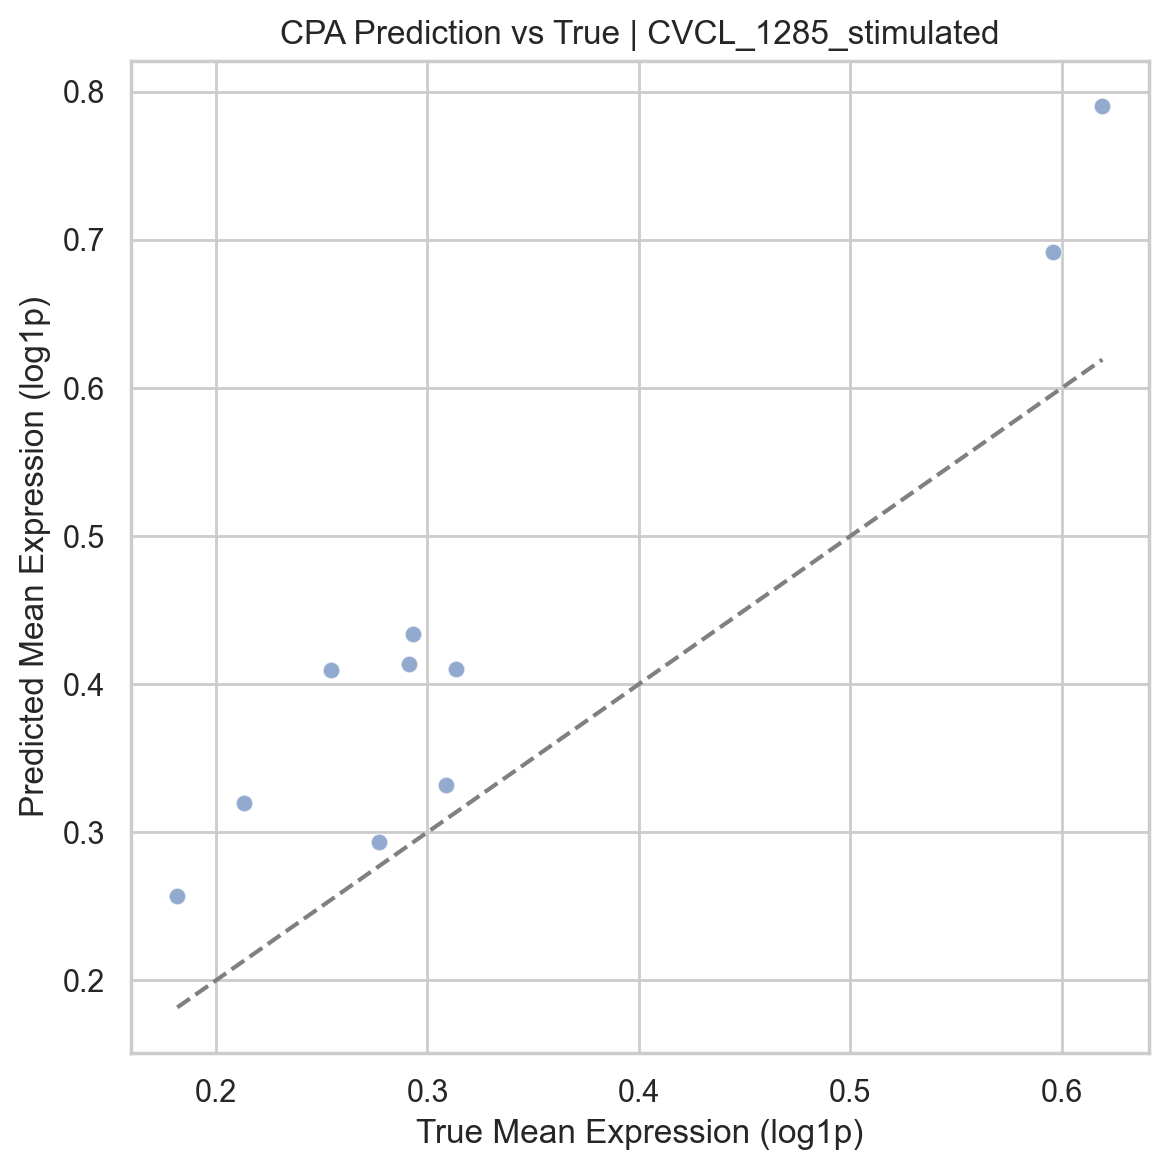

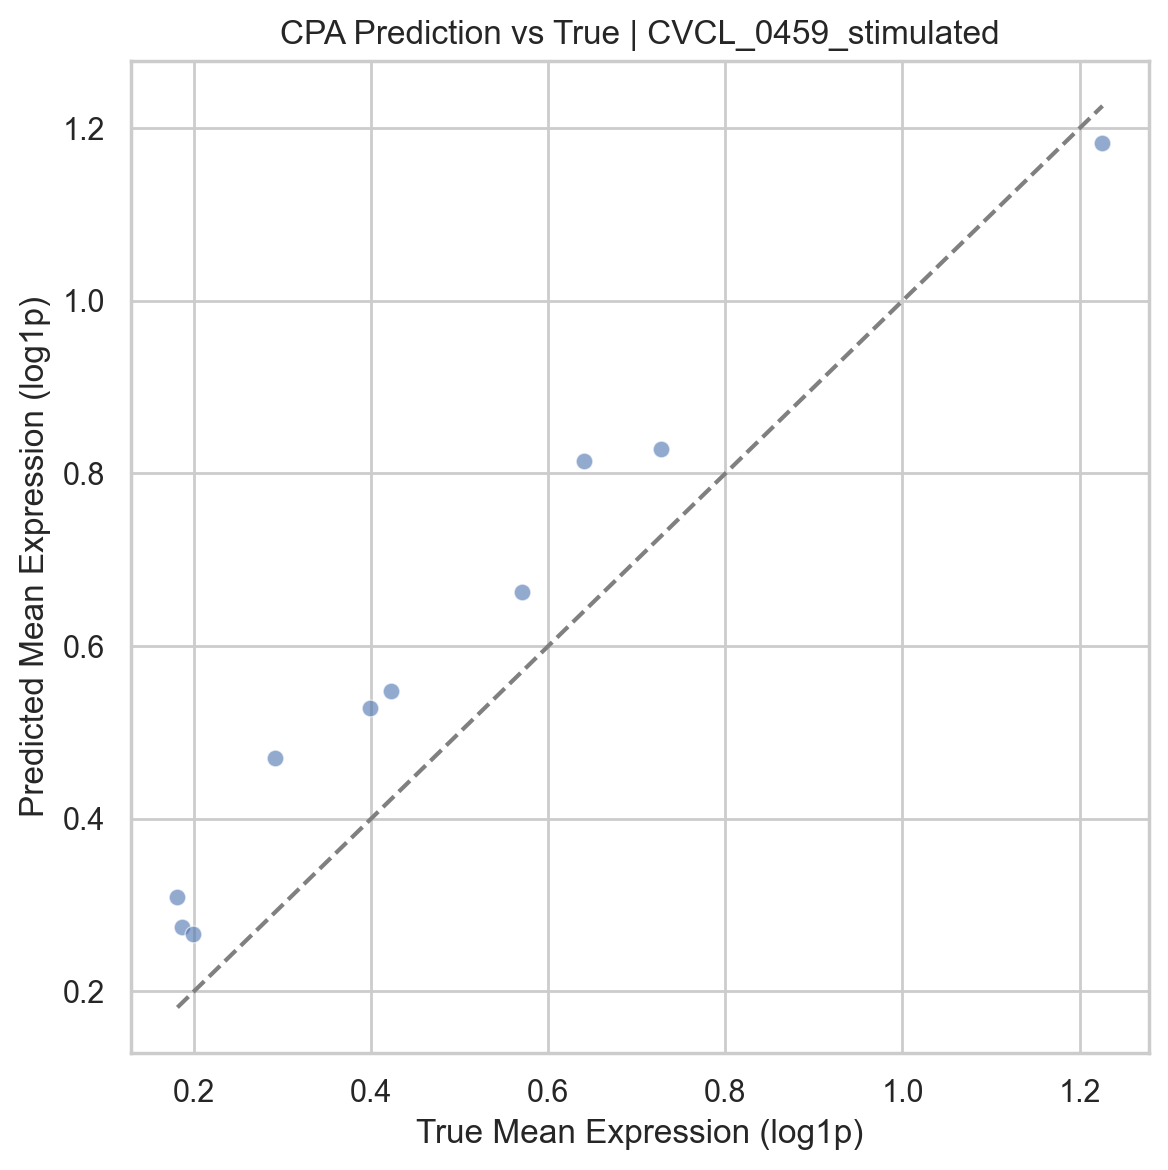

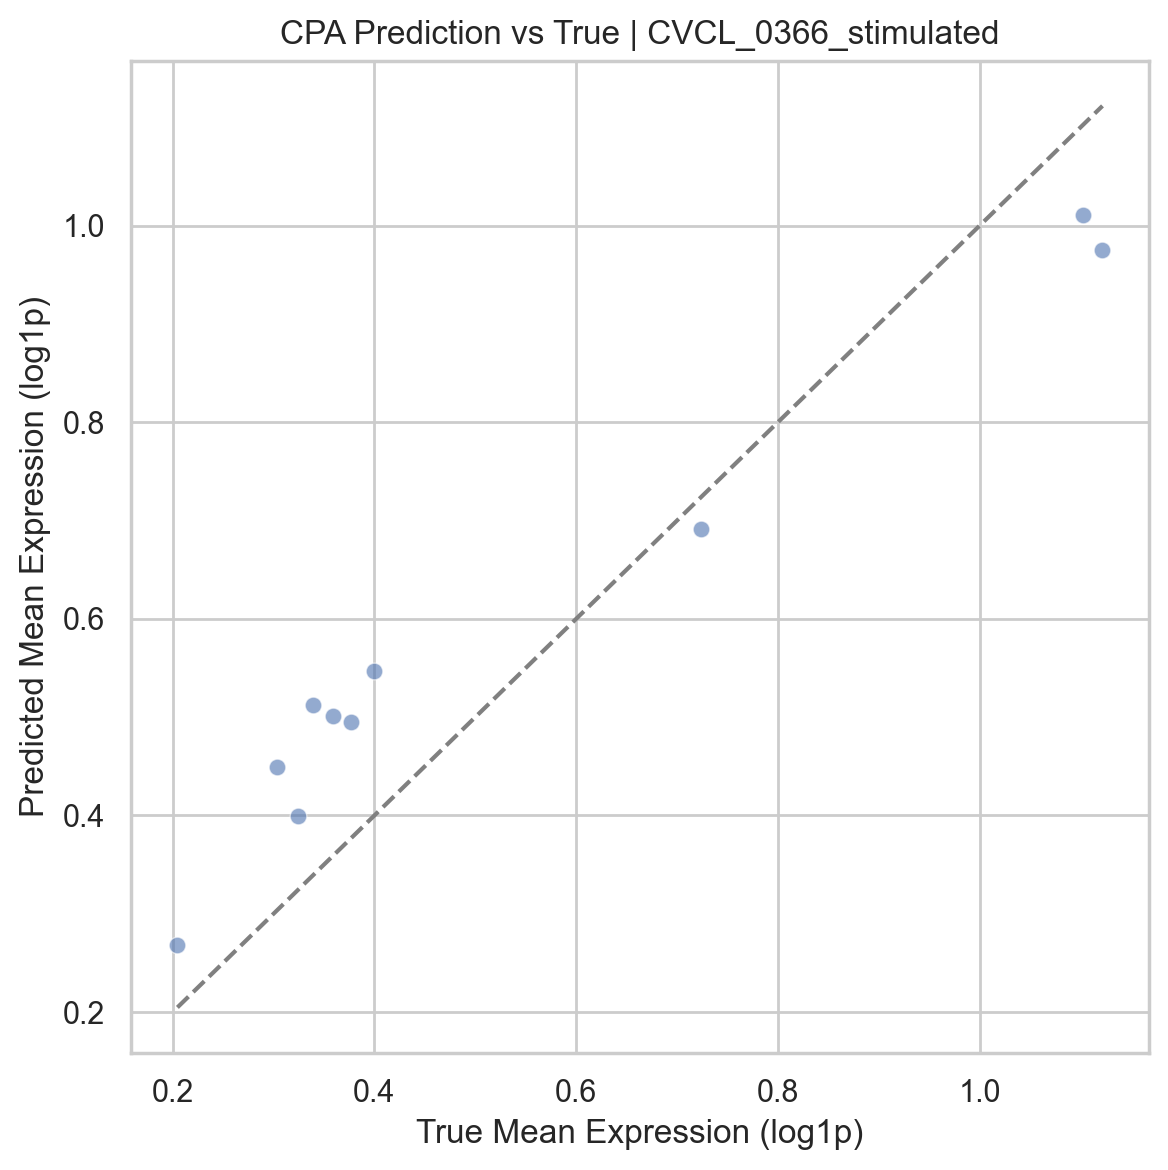

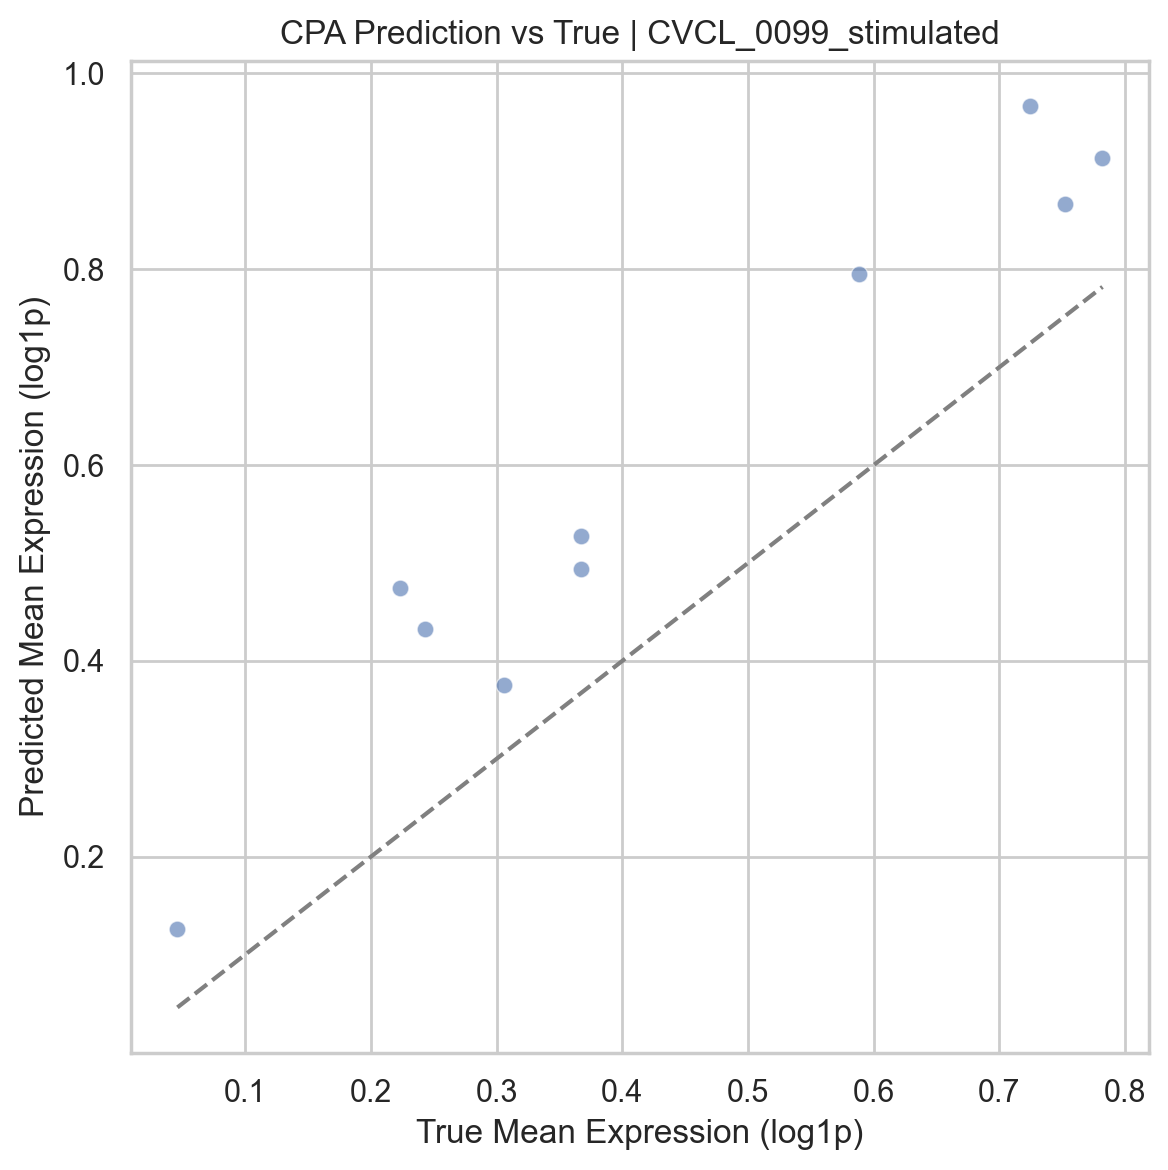

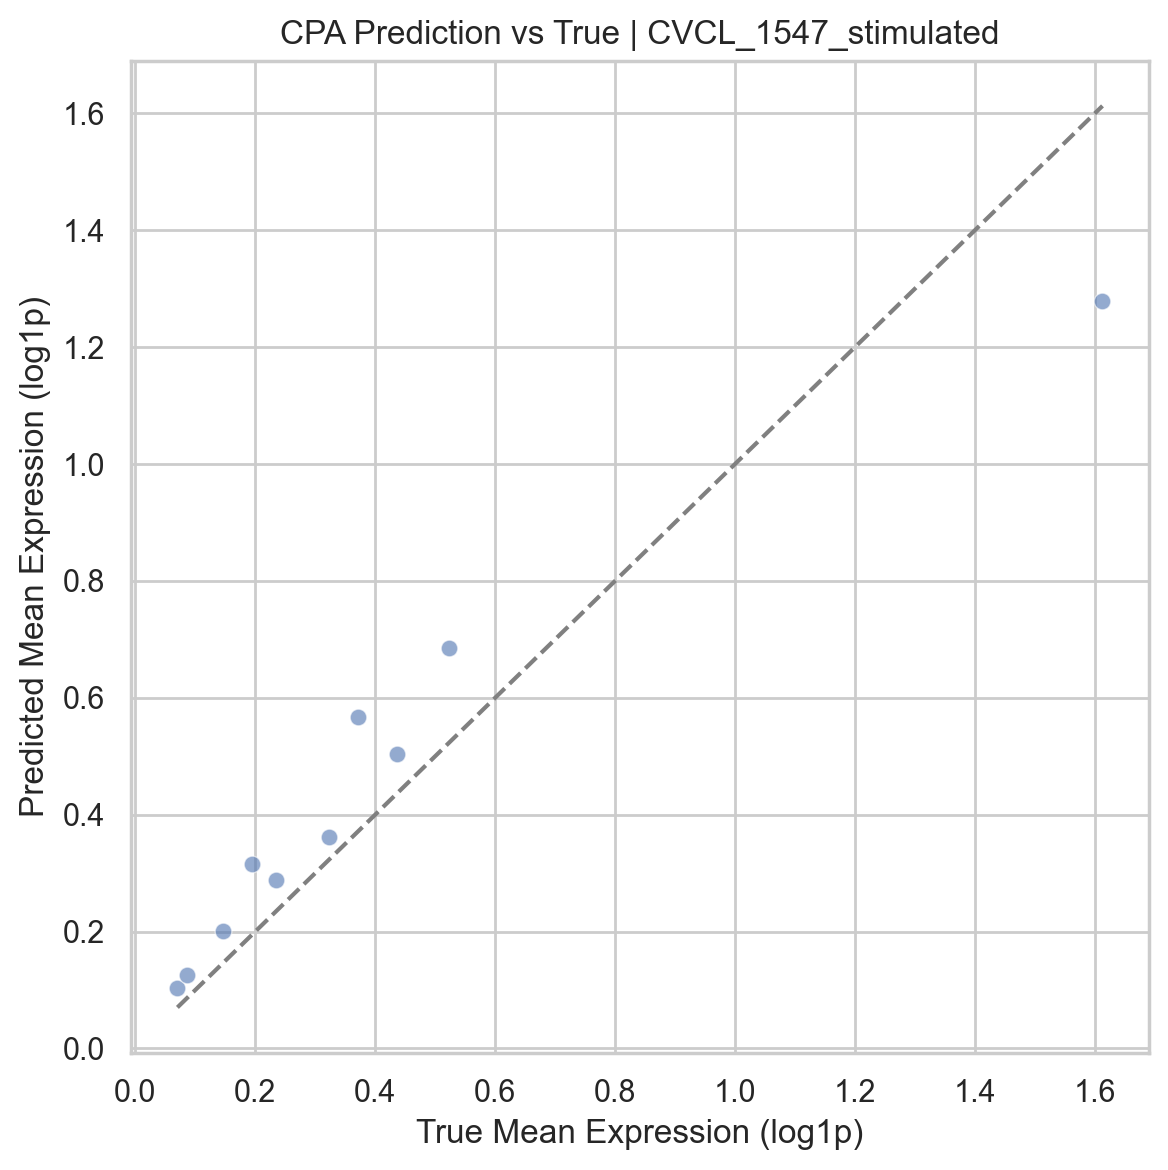

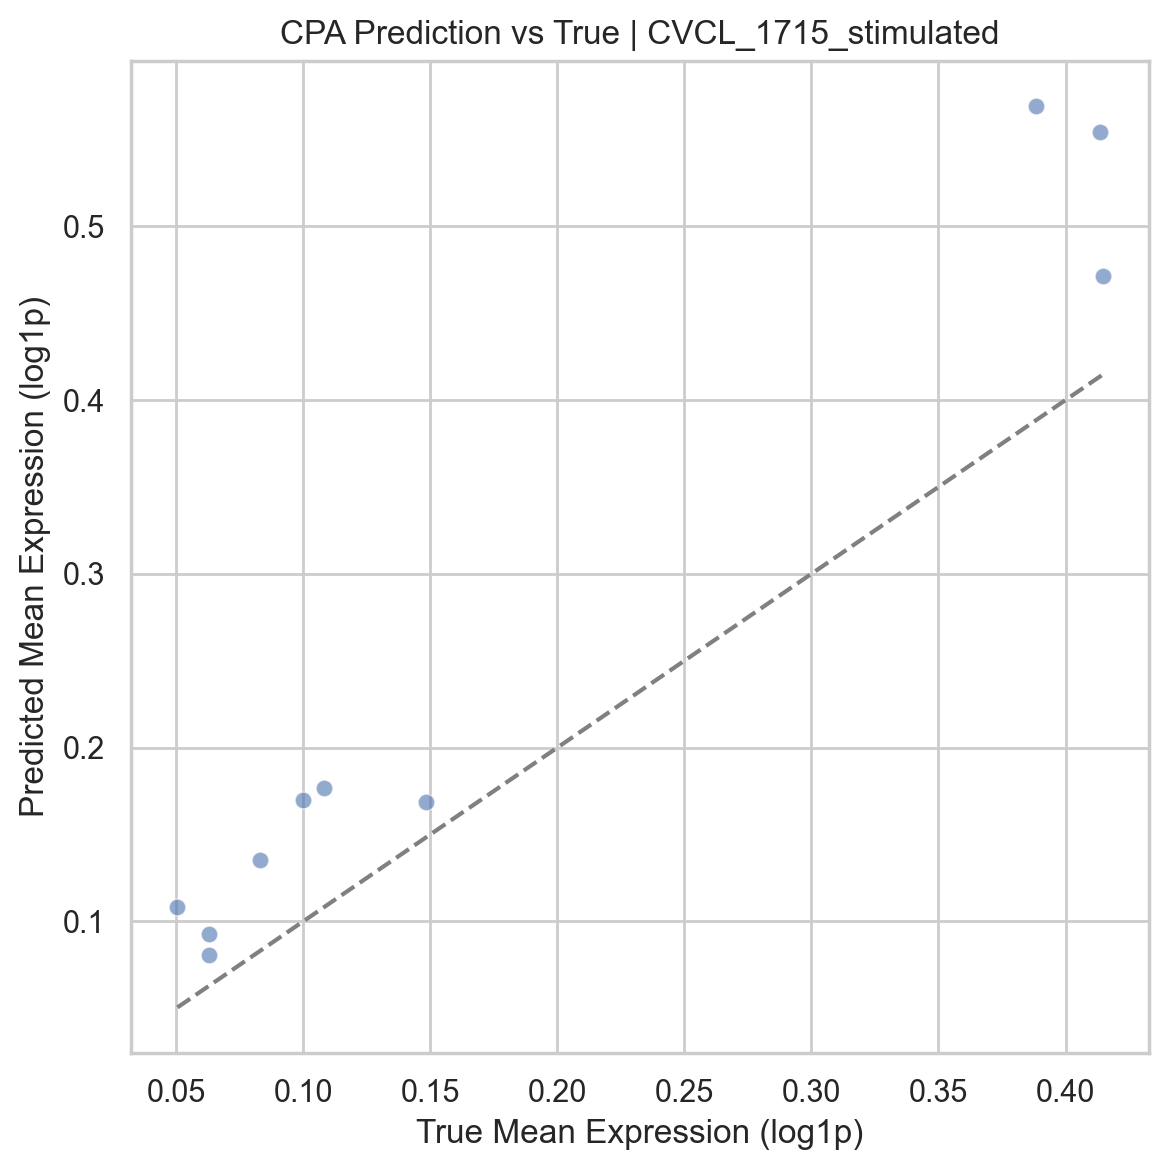

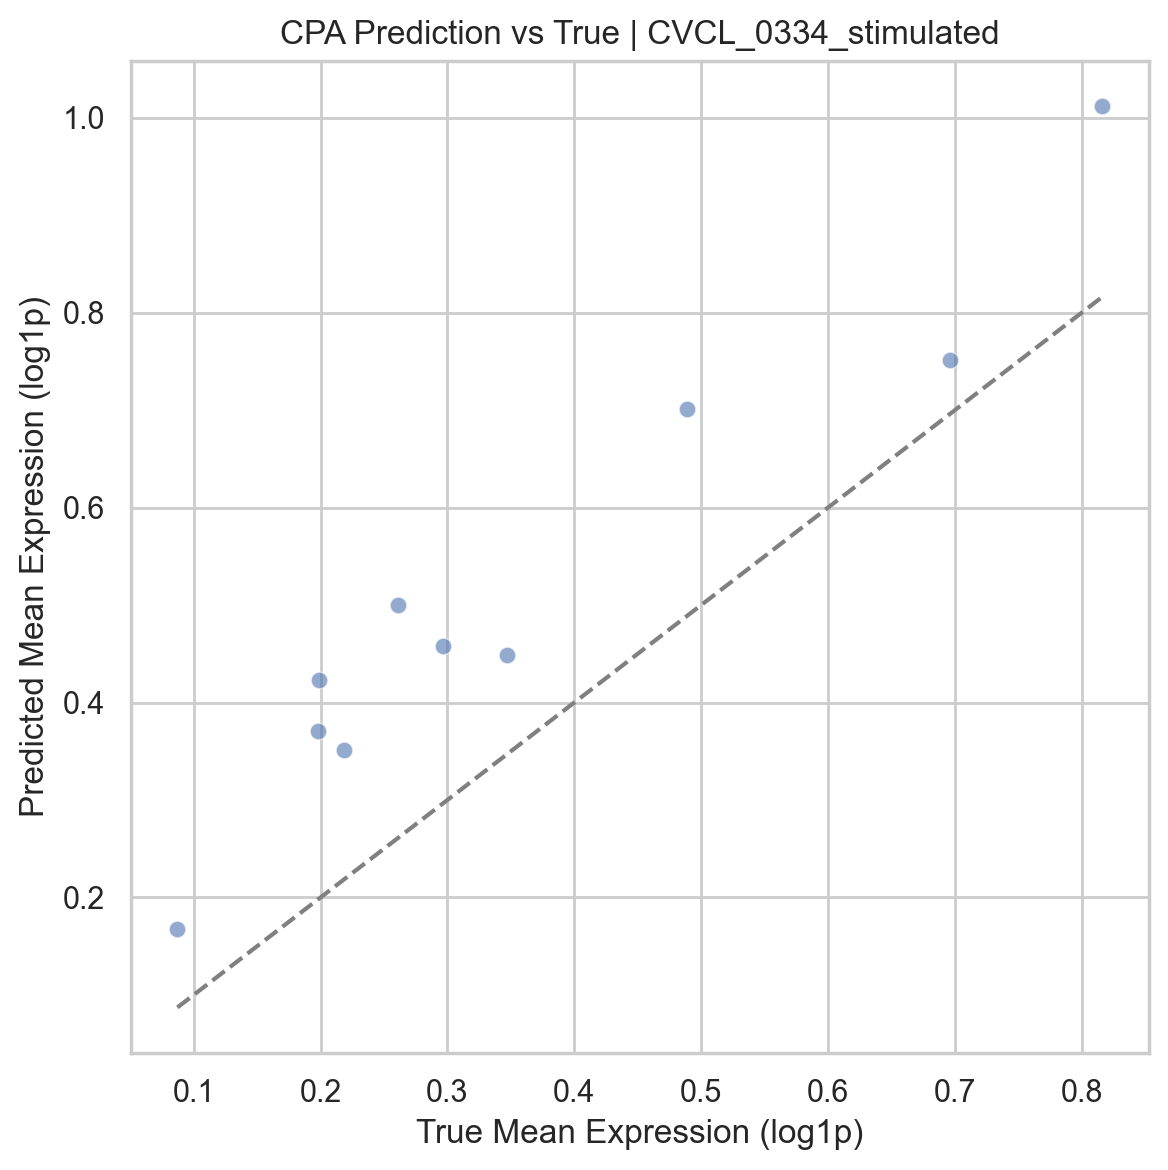

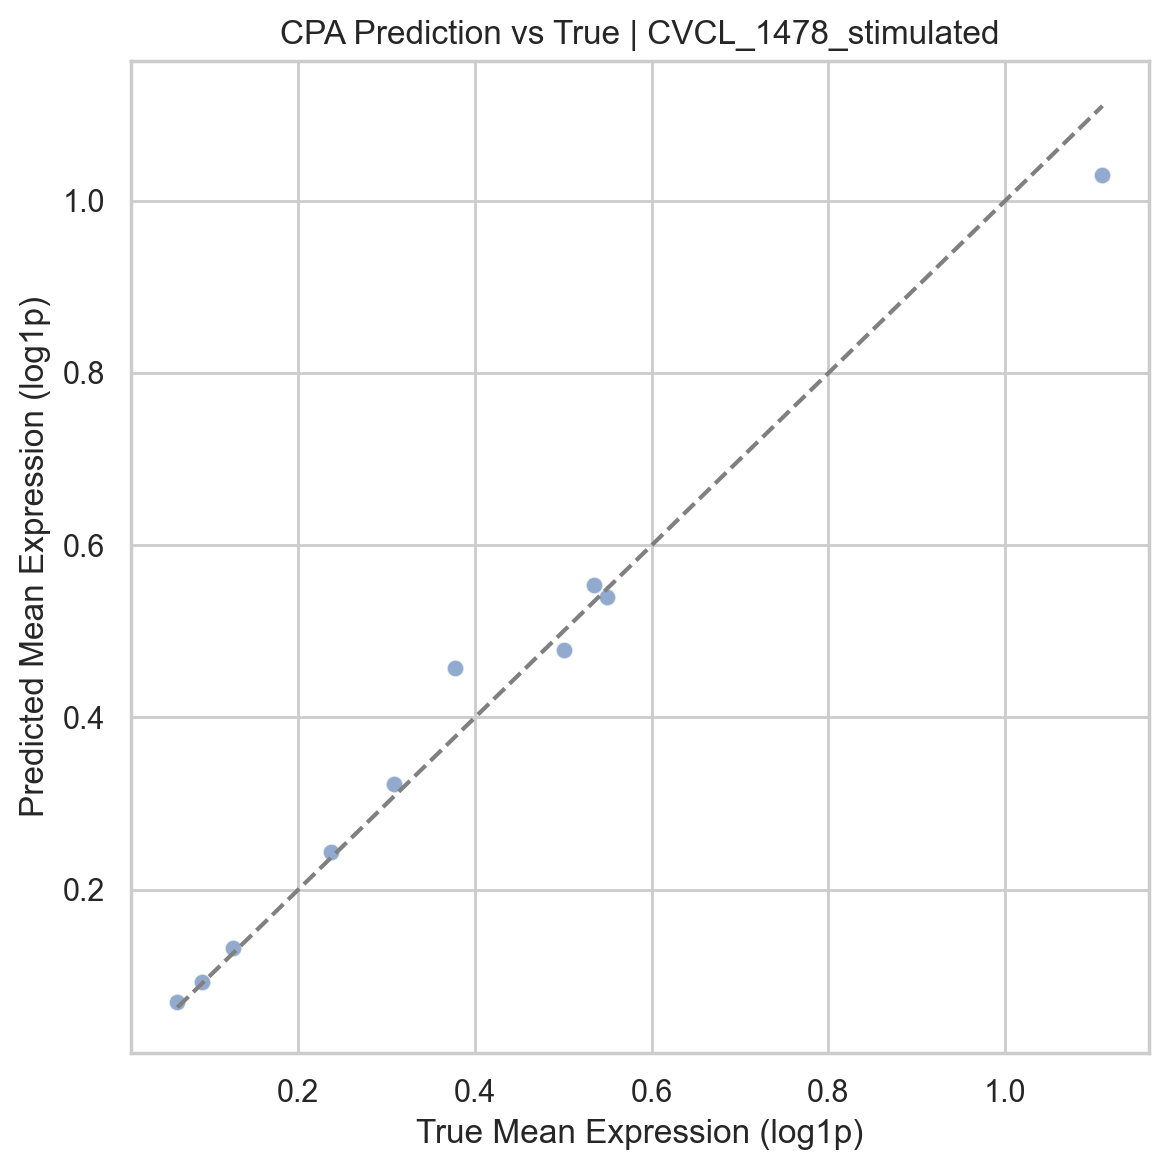

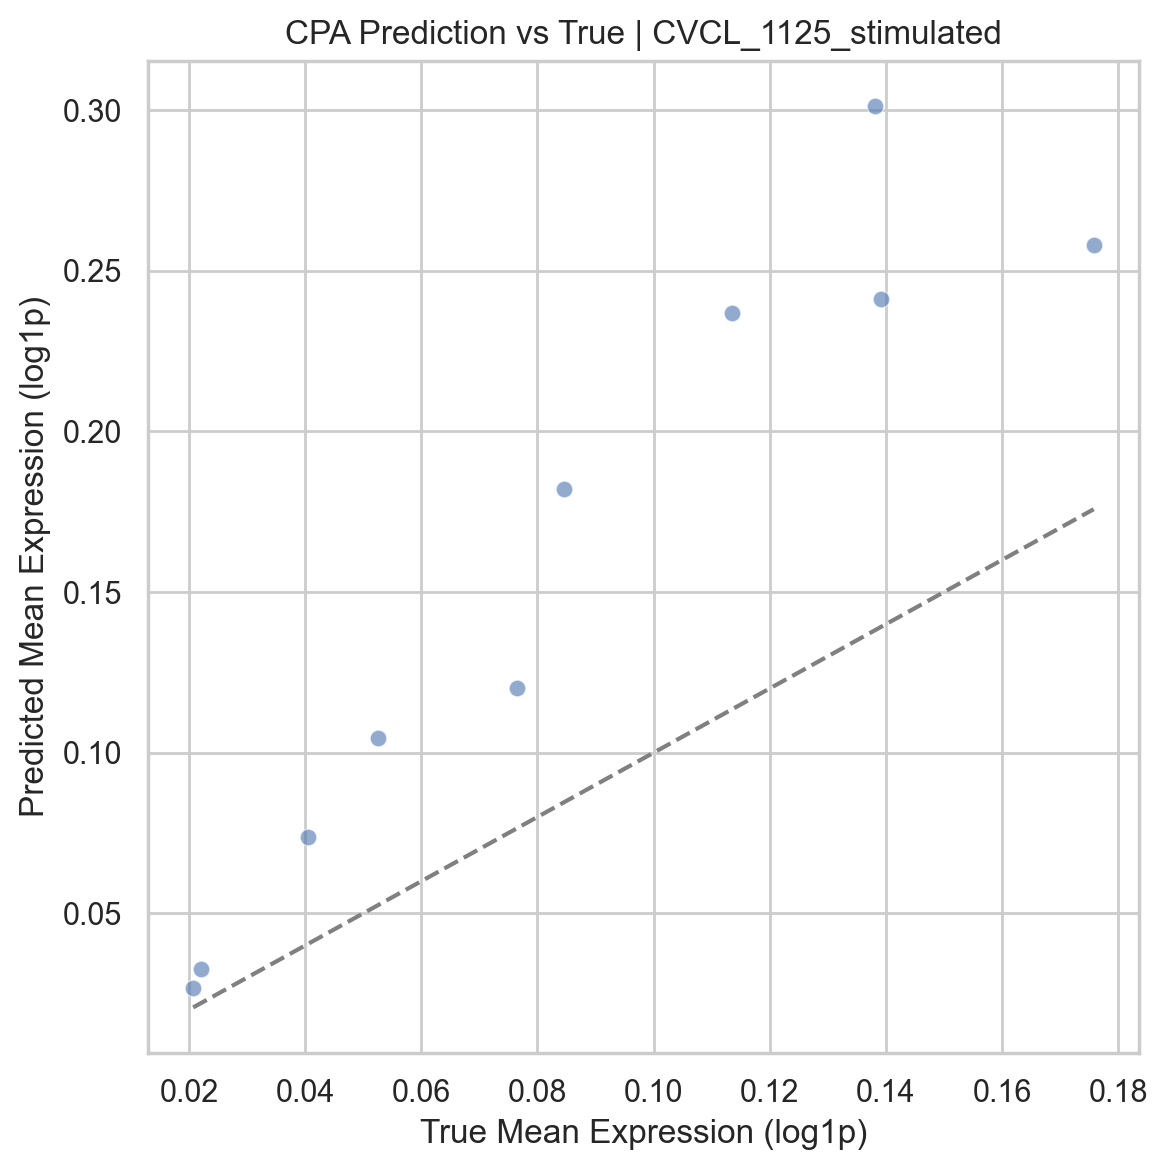

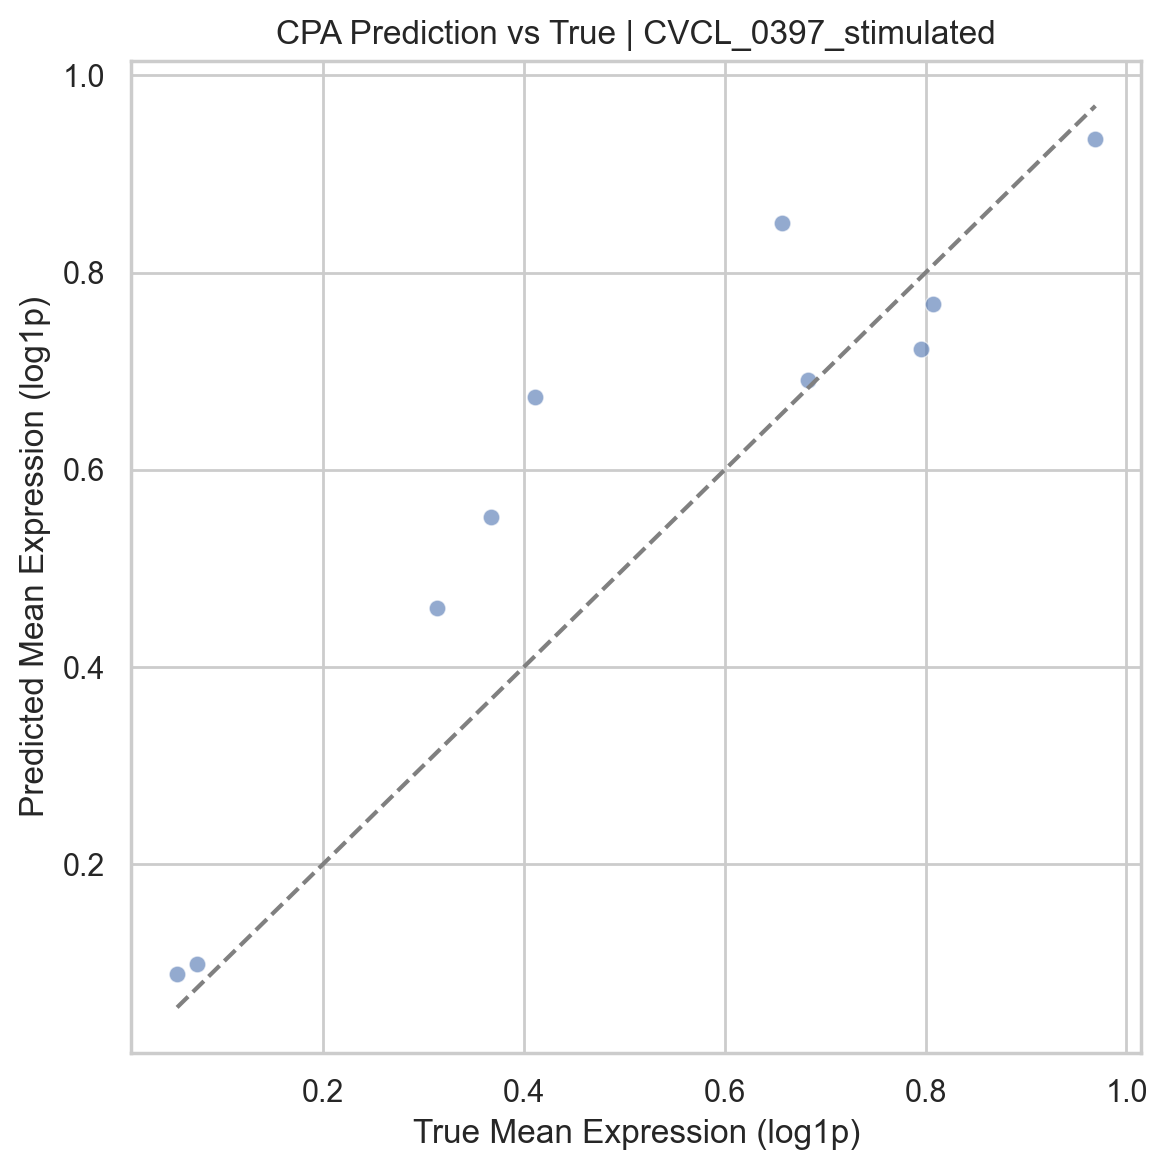

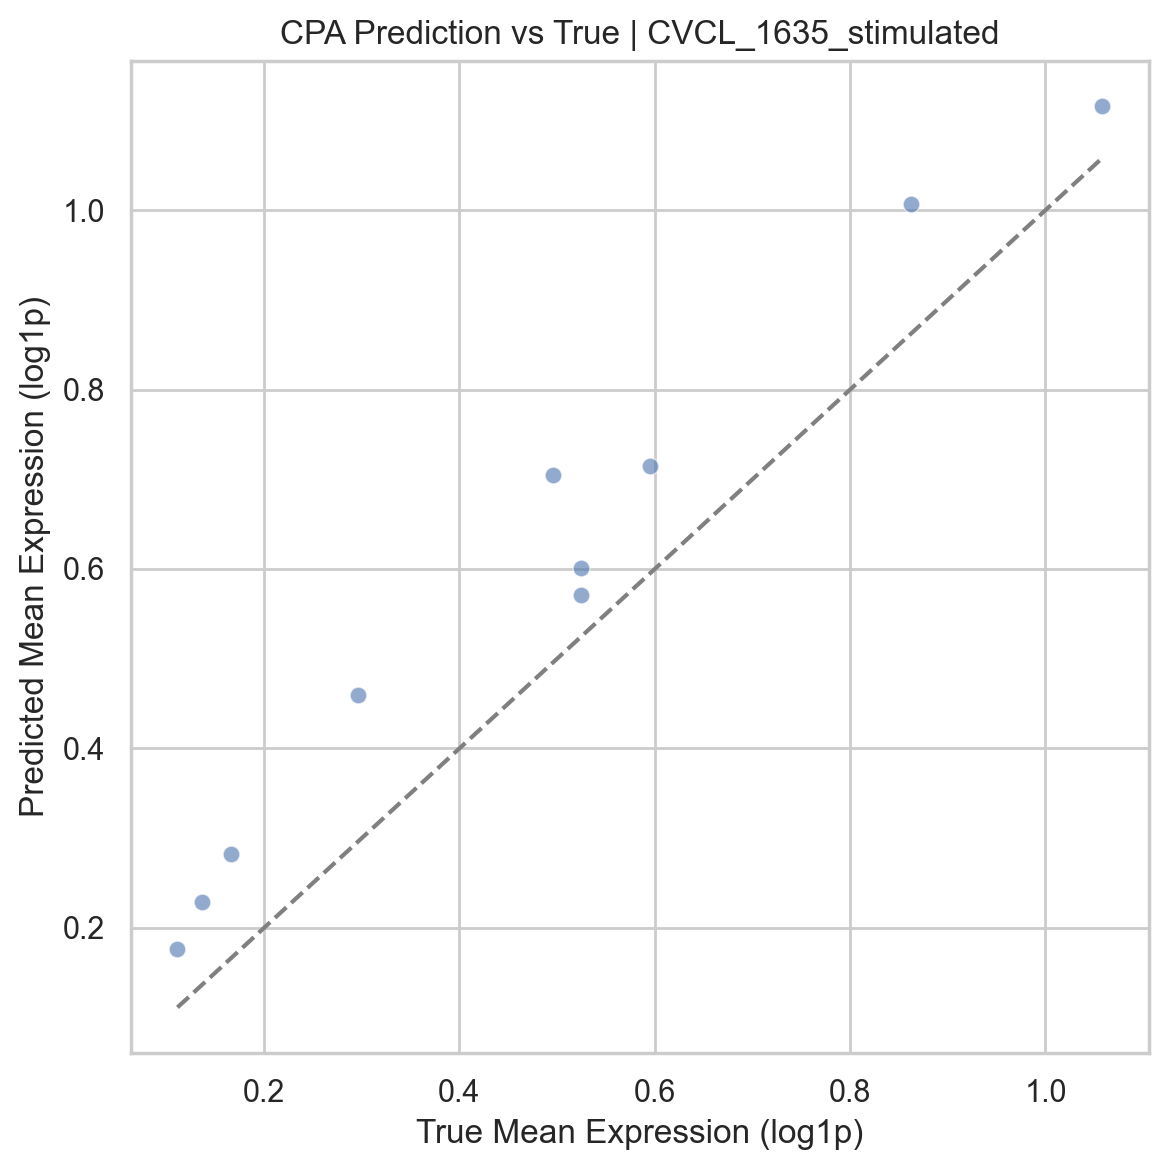

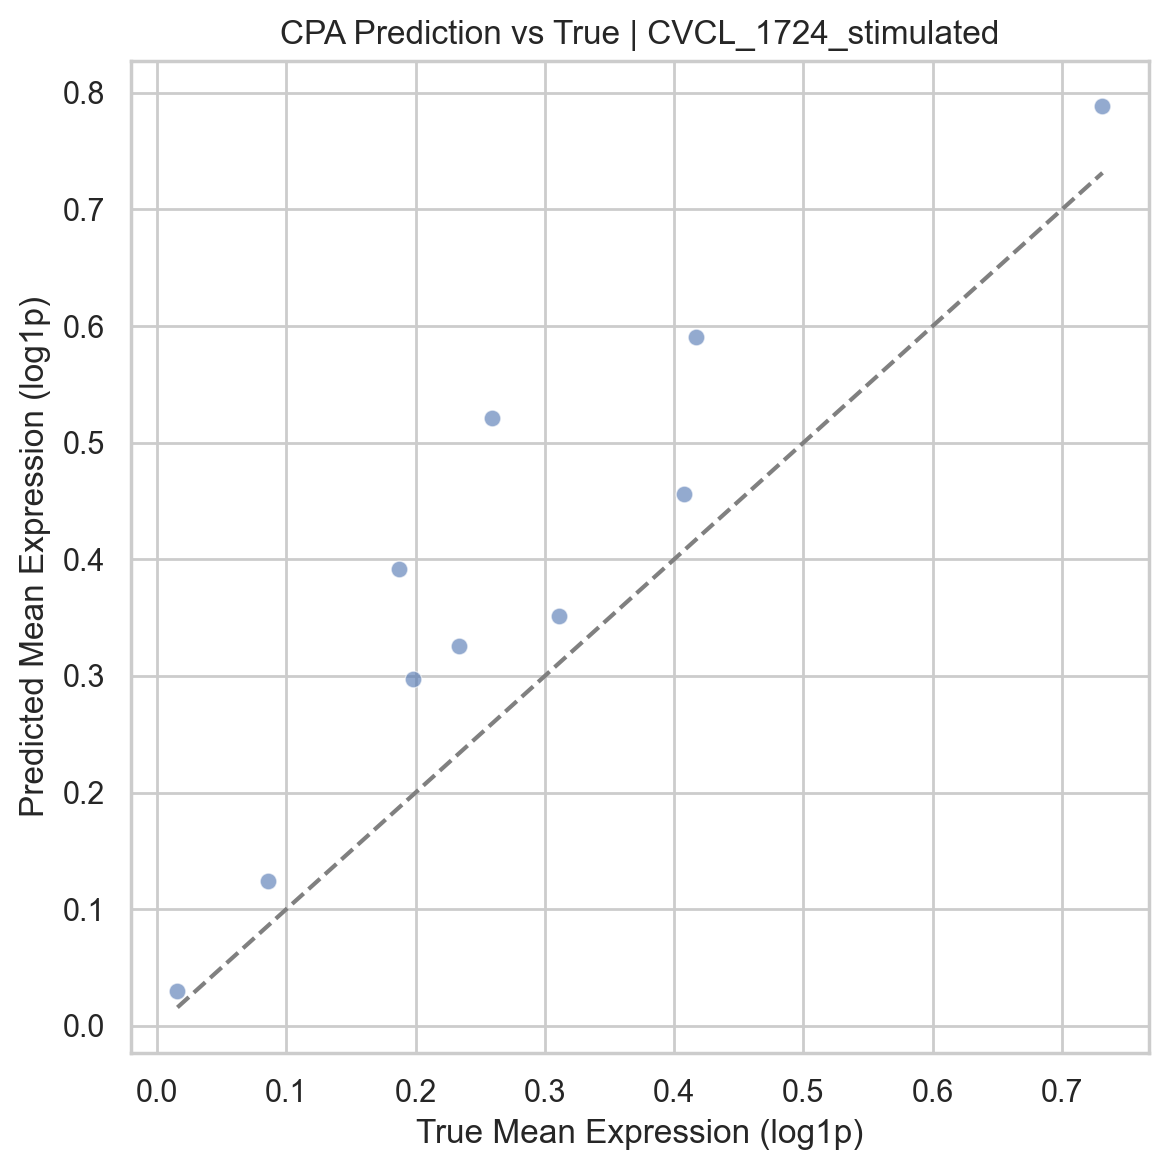

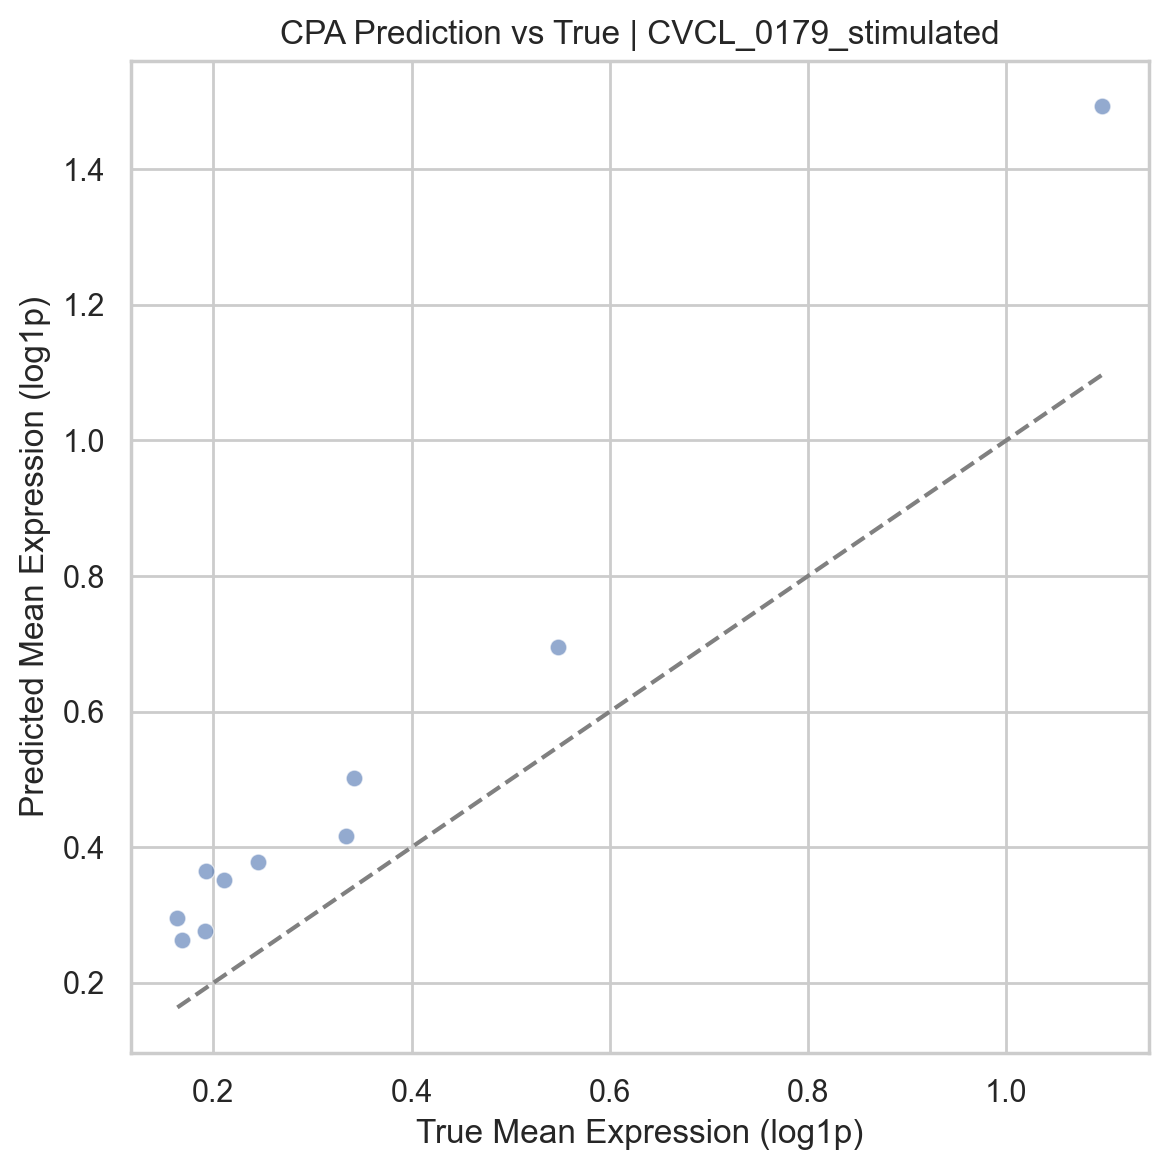

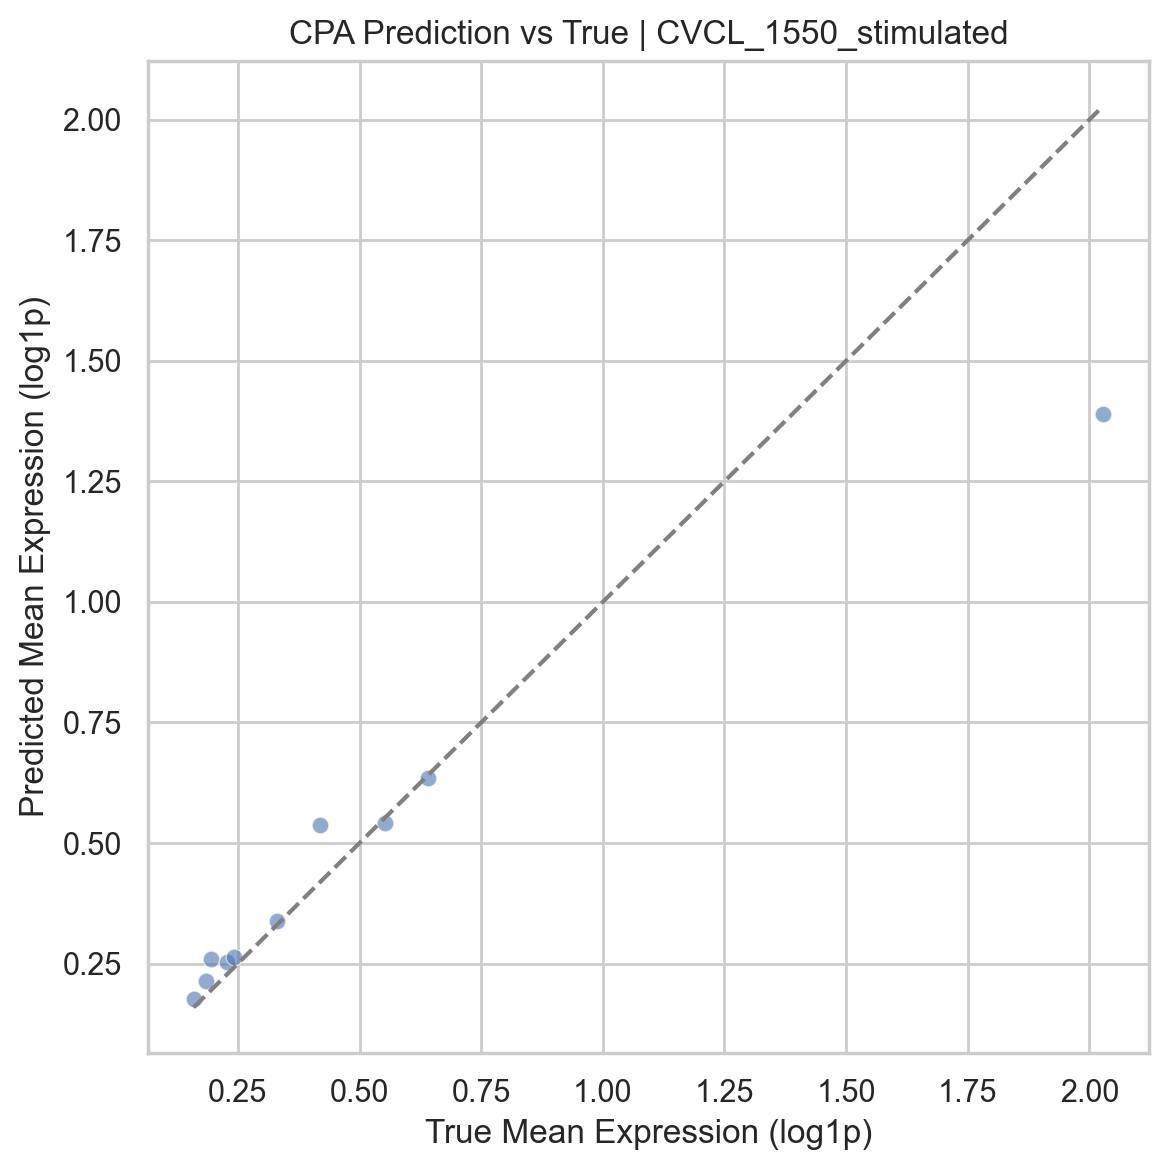

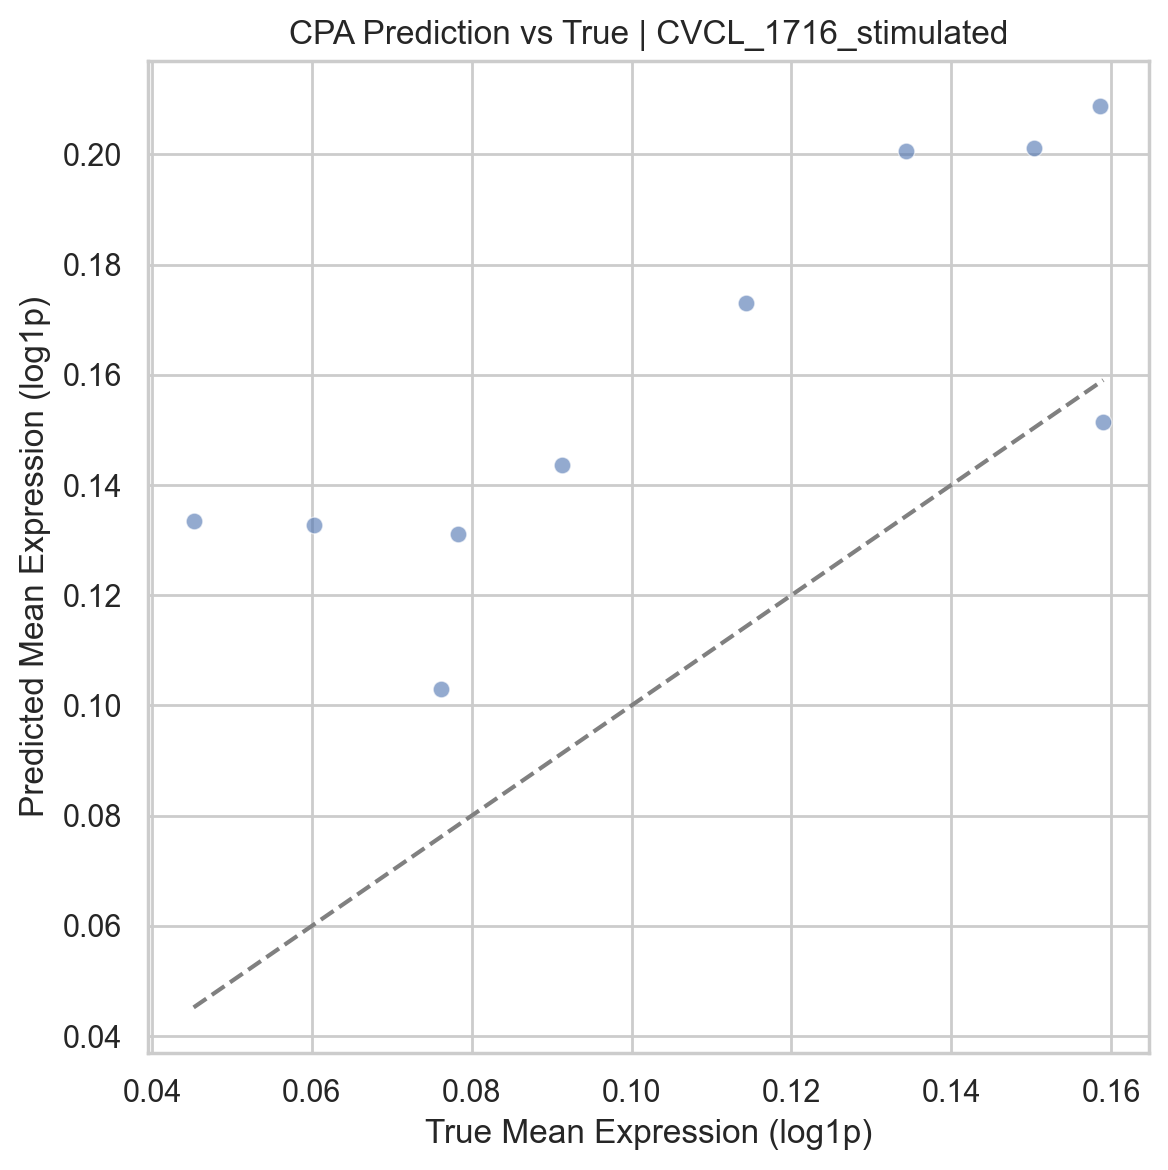

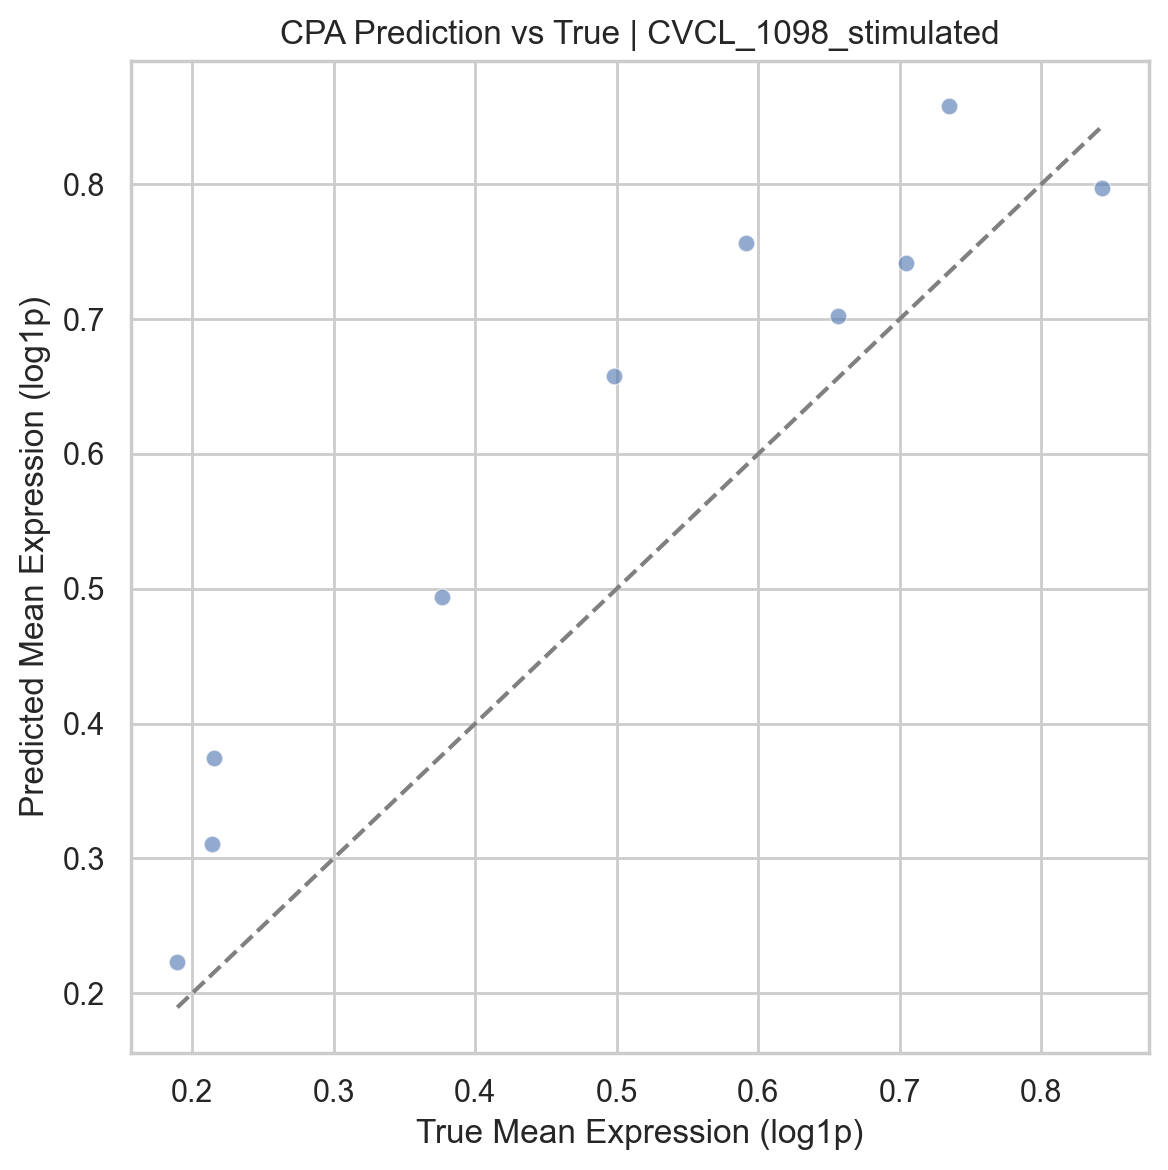

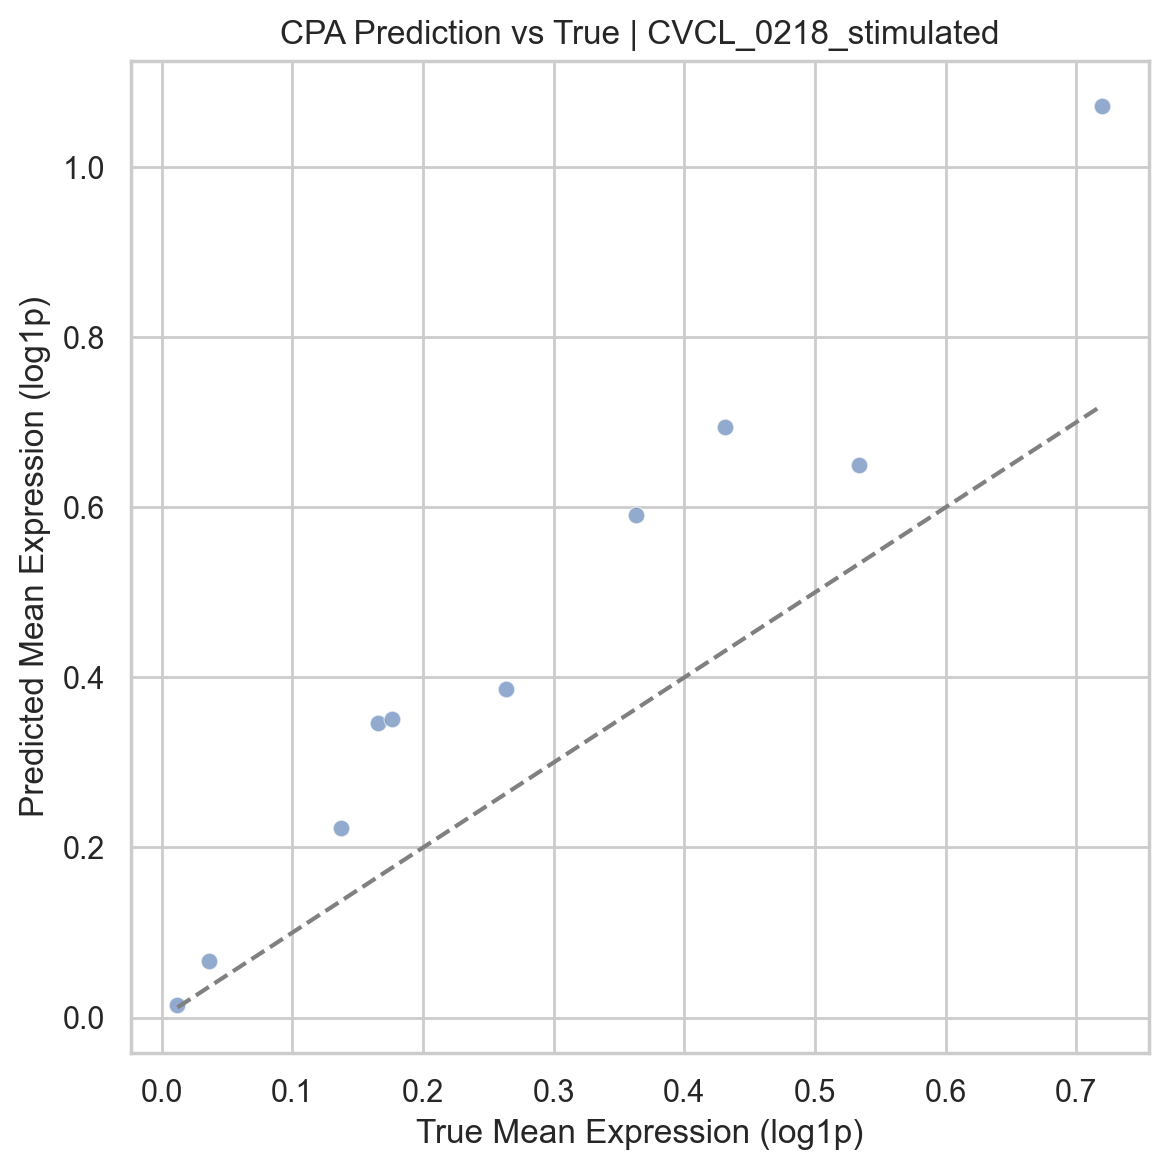

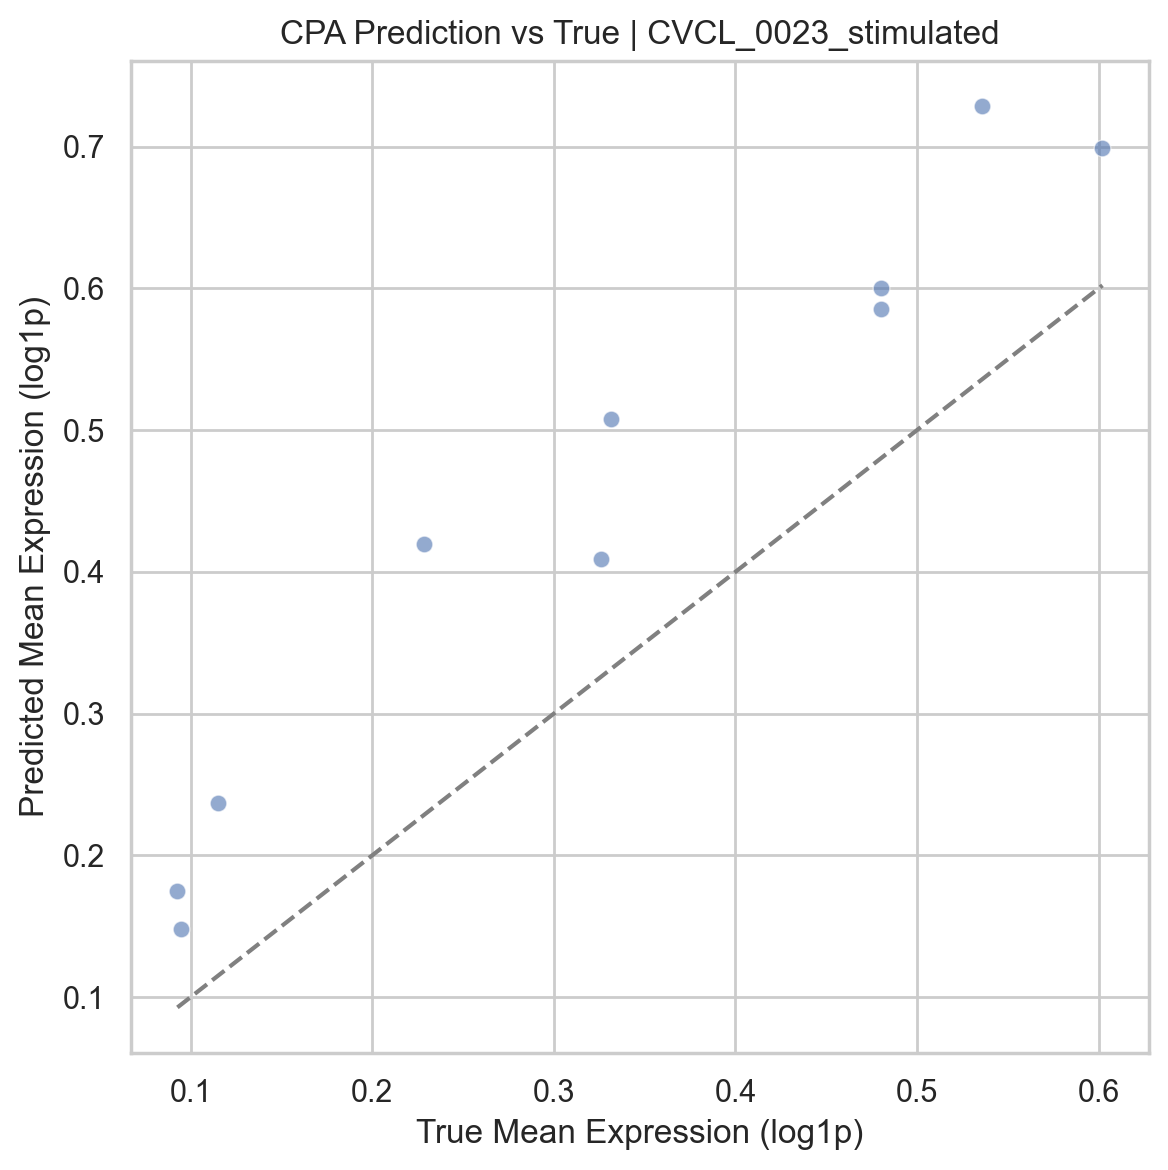

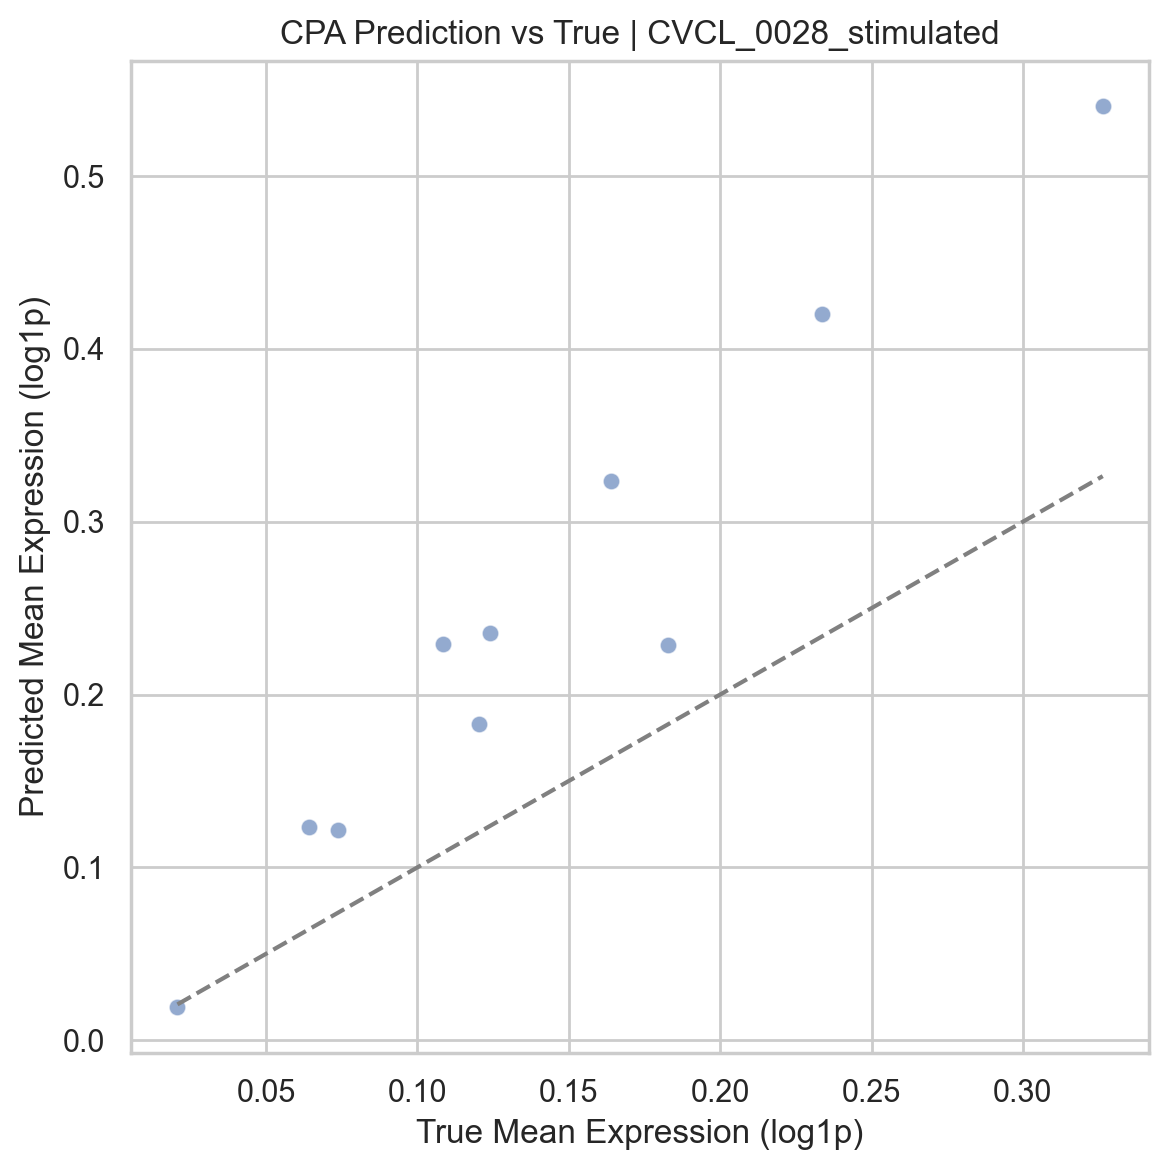

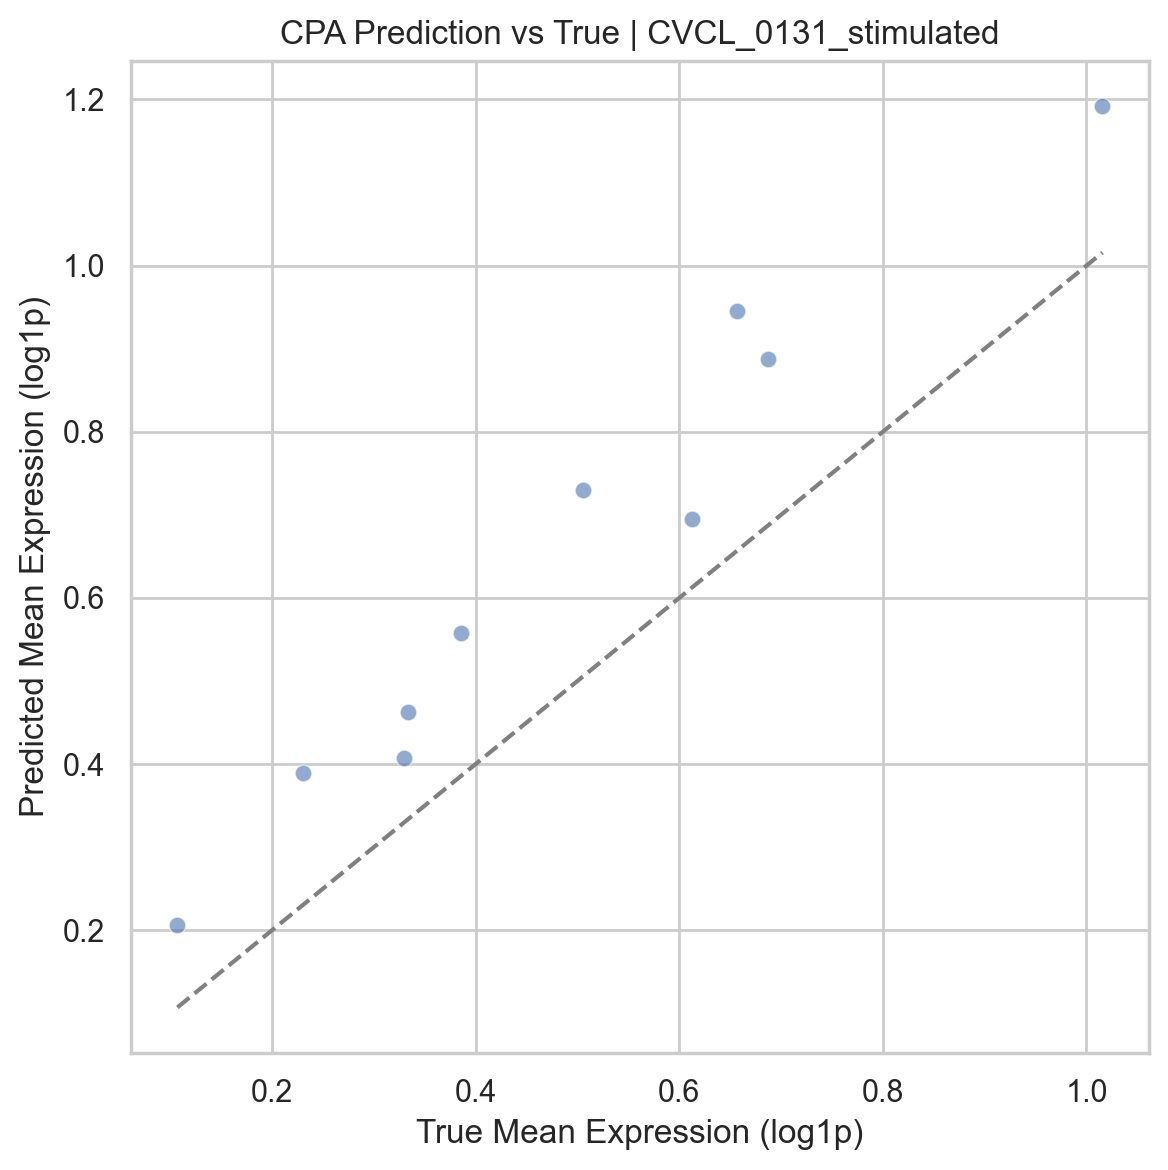

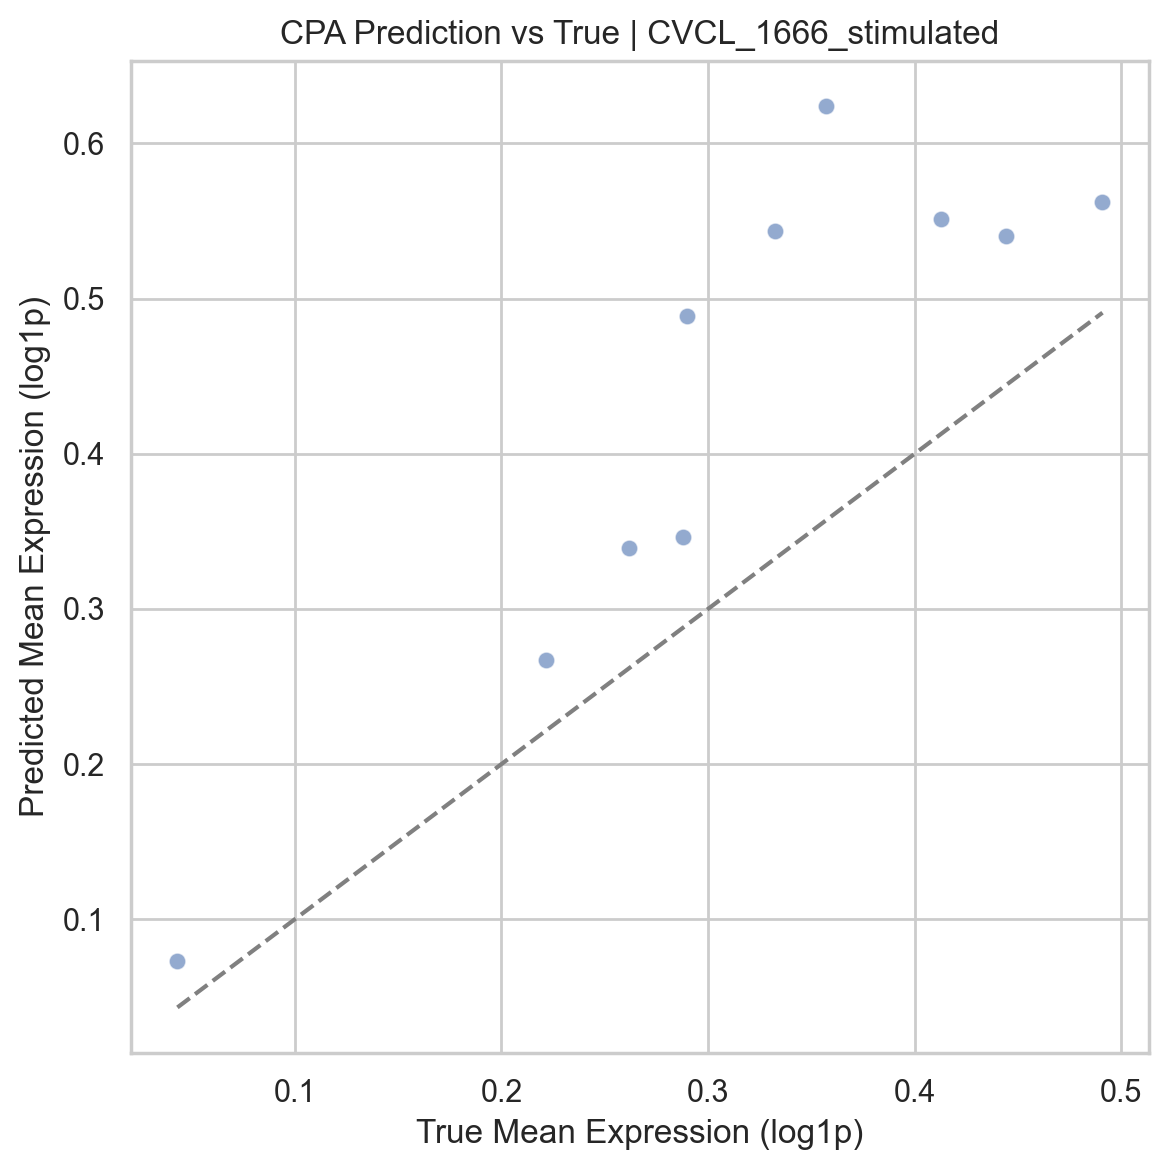

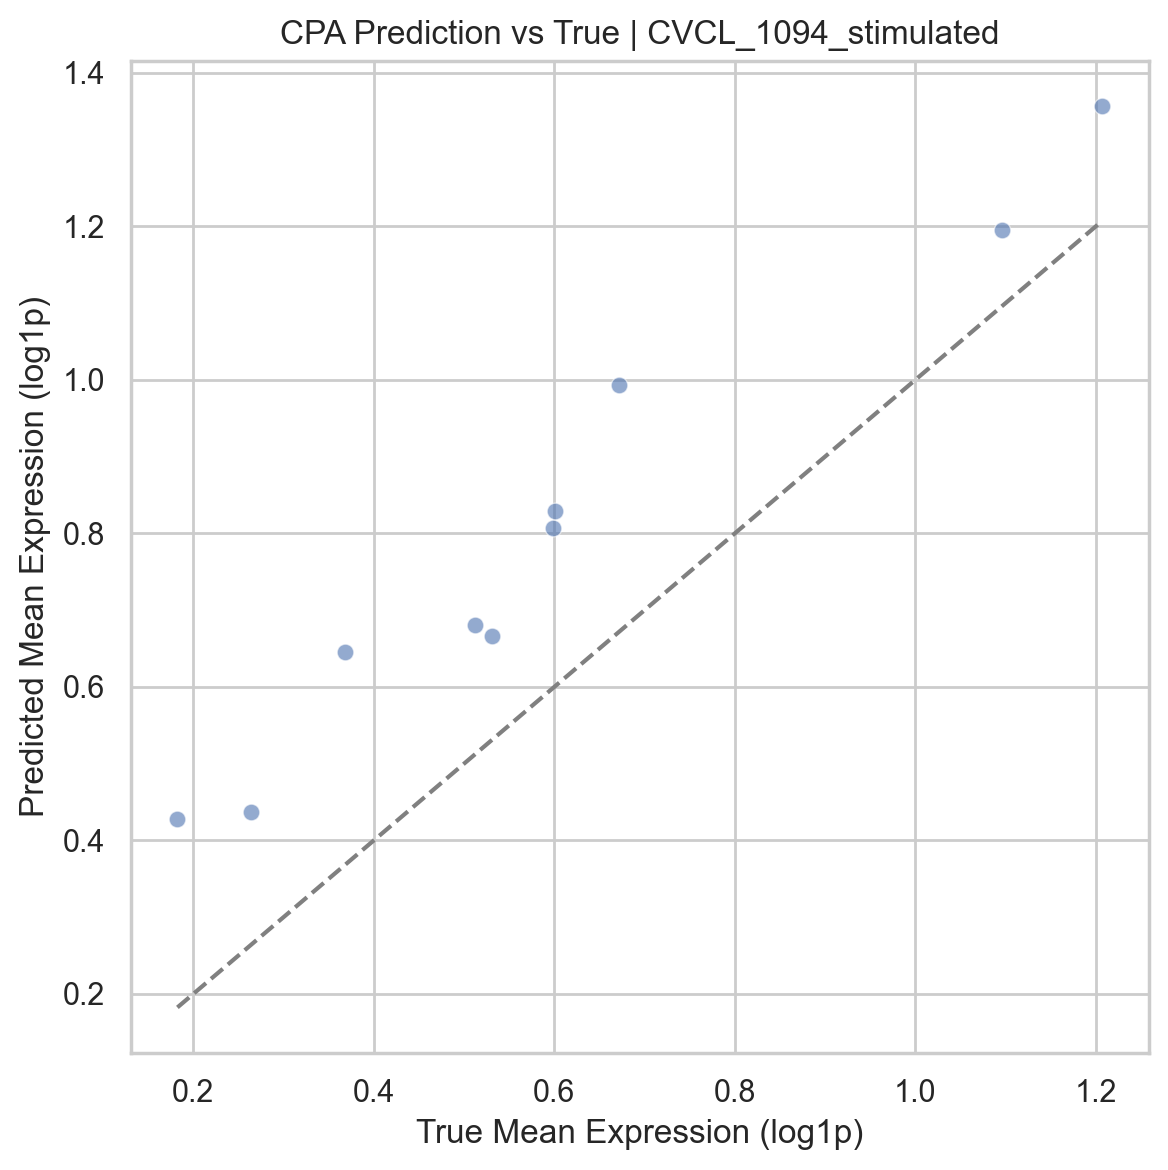

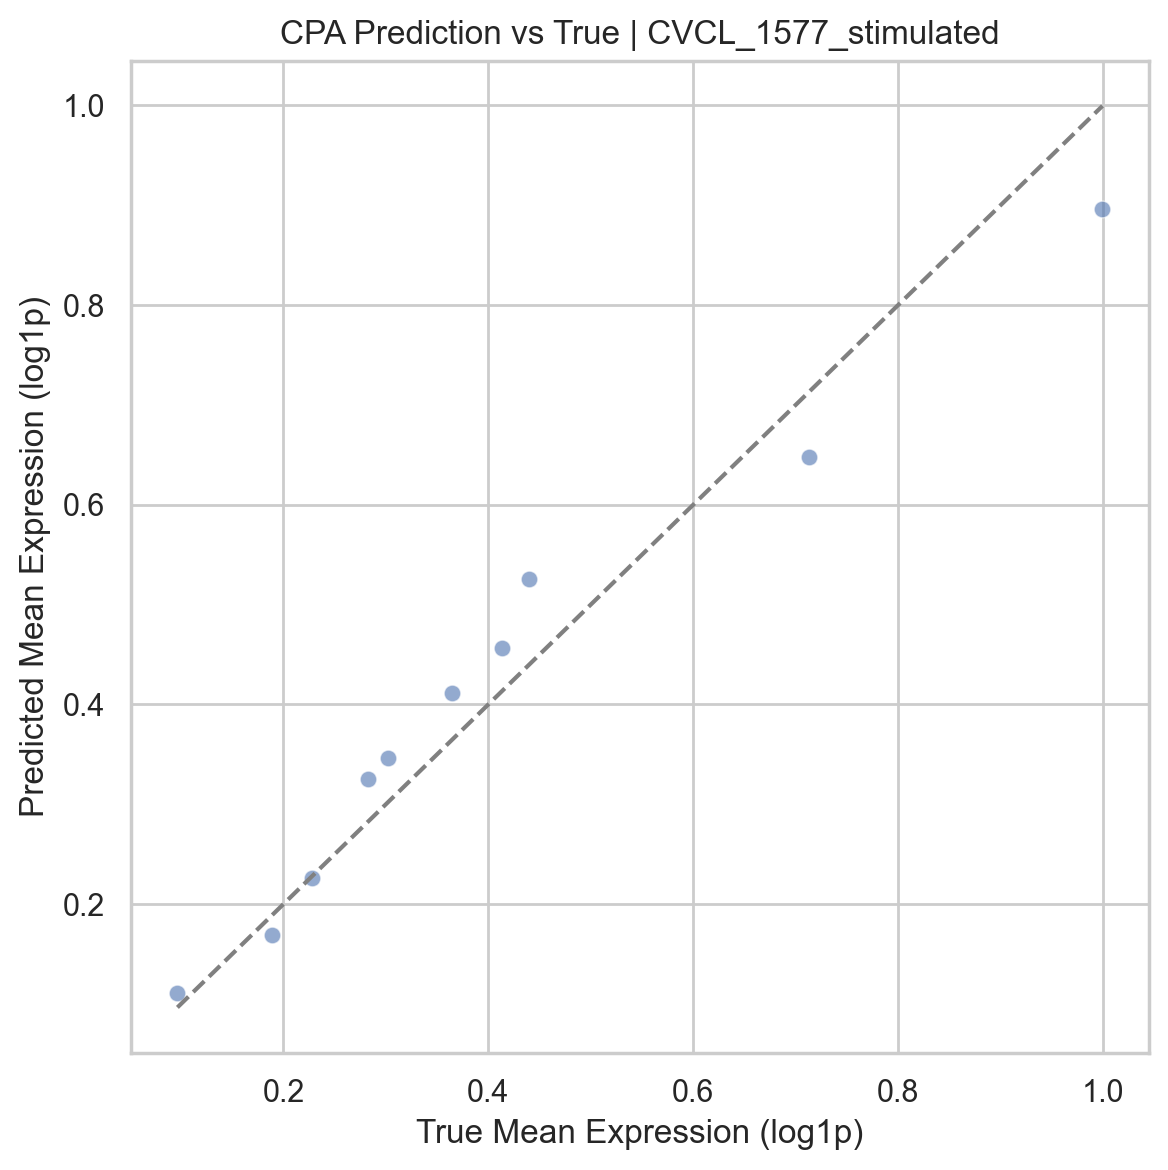

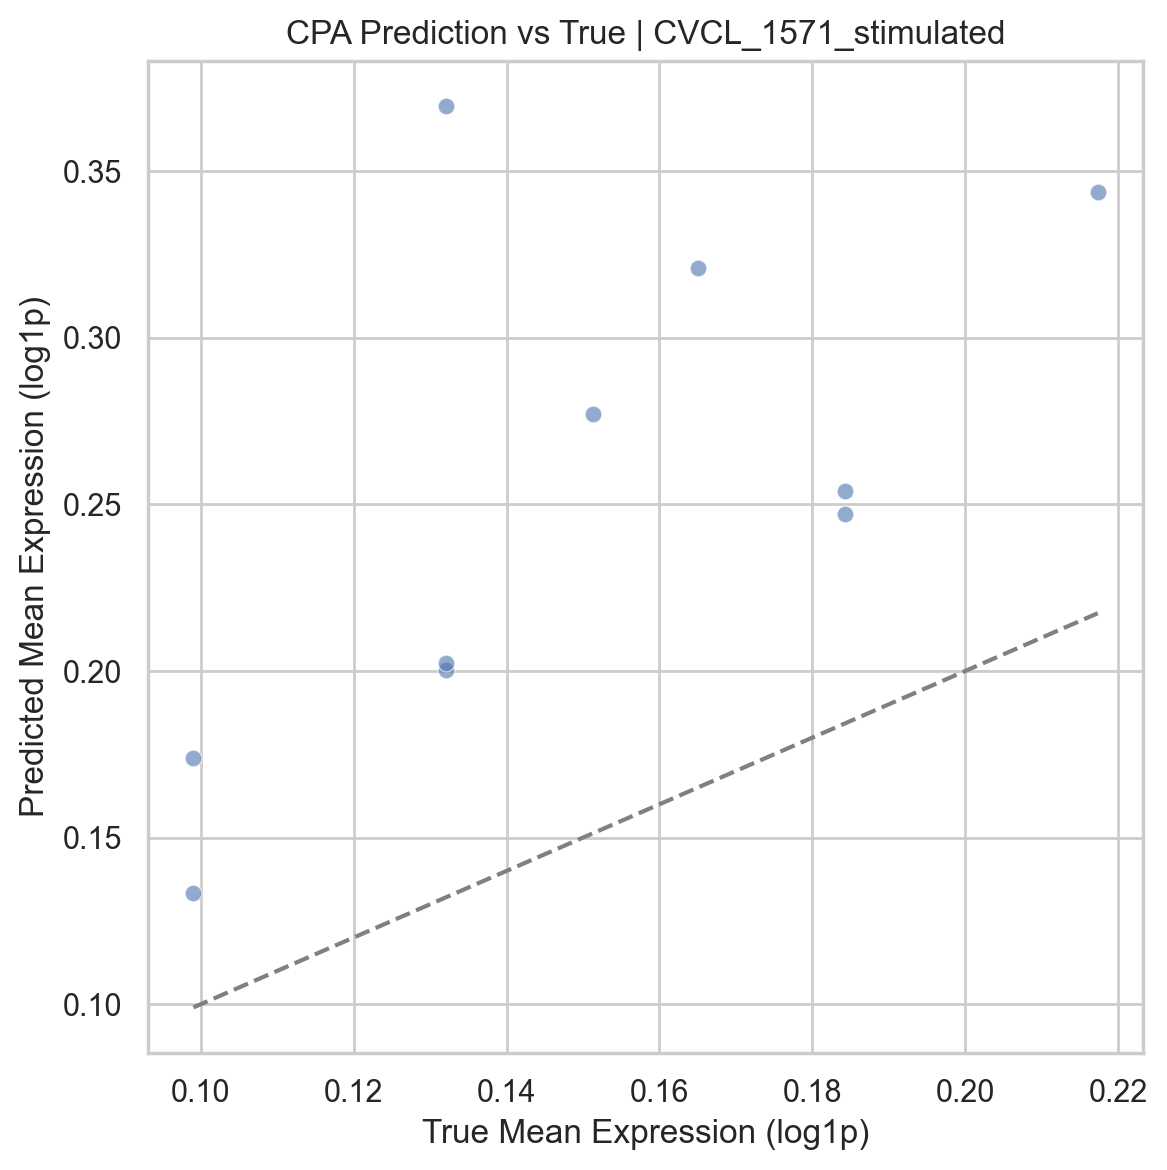

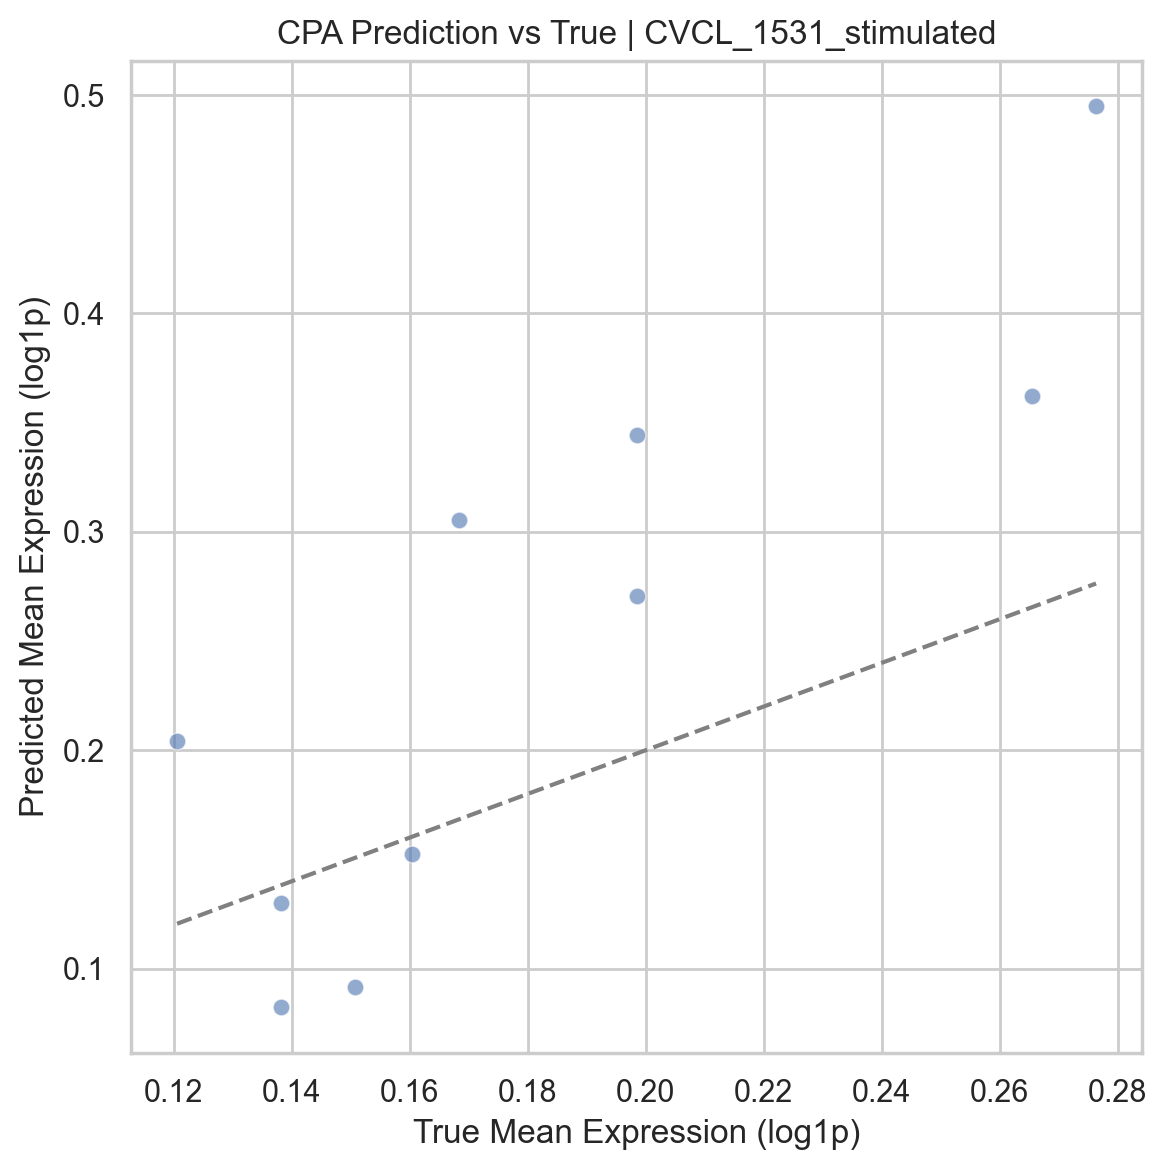

In [ ]:
# Loop through all stimulated conditions
for cat in adata.obs['cov_cond'].unique():
    if 'stimulated' not in cat:
        continue

    # Get control condition
    cov, condition = cat.rsplit('_', 1)
    deg_cat = f'{cat}'
    deg_list = adata.uns['rank_genes_groups'][deg_cat]['names']
    degs = np.where(np.isin(adata.var_names, deg_list[:10]))[0]  # Top 10 DEGs

    if len(degs) == 0:
        print(f"No DEGs found for {cat}")
        continue

    # Extract adatas
    cat_adata = adata[adata.obs['cov_cond'] == cat]
    x_true = cat_adata.layers['counts']
    x_pred = cat_adata.obsm['CPA_pred']

    # Log1p transform if needed
    x_true = np.log1p(x_true)
    x_pred = np.log1p(x_pred)

    # Subset to DEGs
    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]

    # Convert mean to dense arrays
    true_mean = np.asarray(x_true_deg.mean(0)).flatten()
    pred_mean = np.asarray(x_pred_deg.mean(0)).flatten()

    # Plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=true_mean, y=pred_mean, alpha=0.6)
    plt.plot([true_mean.min(), true_mean.max()],
             [true_mean.min(), true_mean.max()],
             linestyle='--', color='gray')
    plt.xlabel("True Mean Expression (log1p)")
    plt.ylabel("Predicted Mean Expression (log1p)")
    plt.title(f"CPA Prediction vs True | {cat}")
    plt.tight_layout()
    plt.show()
